In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#%cd /content/drive/MyDrive/

# Home Credit Cash loans/Cash loans 24か月

In [3]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 2080 Ti


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16338951437778494546
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9399762944
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14285823421288757856
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:22:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3597677018502648733
 physical_device_desc: "device: 1, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 2144165316]

In [5]:
import cupy as cp
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_moons

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from keras.layers import Dense, Dropout
from keras.models import Sequential

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

from tqdm import tqdm

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
app_hc_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_hc_c-c-domein_axis-24-monthes.csv')
app_hc_test_origin =  pd.read_csv('./home-credit-default-risk/datasets/app_test_hc_c-c-domein_axis-24-monthes.csv')
app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

## applicationの欠損値を補完

In [7]:
# applicationの欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
app_train_origin_replace = pd.DataFrame(imputer.fit_transform(app_train_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace = pd.DataFrame(imputer.fit_transform(app_test_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_16  \
0               0.0  ...               0.0               0.0   
1               0.0  ...               0.0               0.0   
2               0.0  ...               0.0               0.0   
3               0.0  ...               0.0               0.0   
4               0.0  ...               0.0               0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  \
0                   0.000000                    0.000000     0.036147   
1                   0.000000                    3.000000     0.077973   
2                   0.000000                    4.000000     0.105202   
3                   0.000000                    3.000000     0.031123   
4                   0.010242                    1.748333     0.051266   

   DAYS_EMPLOYED_PERCENT  credit_annuity_ratio  credit_goods_price_ratio  \
0               0.121044             19.775662                    1.2640   
1               0.247398             74.467617                    1.2376   
2               0.222477              1.934735                    1.0528   
3               0.133515              6.378867                    1.0000   
4               0.168021             15.997755                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 91 columns]

In [8]:
# 欠損値を補完した列を再結合
app_train_origin[replace_columns] = app_train_origin_replace[replace_columns]
app_test_origin[replace_columns] = app_test_origin_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [9]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

## OriginデータのCOPY

In [10]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
app_hc_train = app_hc_train_origin.copy()
app_hc_test = app_hc_test_origin.copy()
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [11]:
app_br_train = app_hc_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_hc_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

19552

In [12]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 前処理

In [13]:
app_hc_train = app_hc_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_hc_test = app_hc_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

19552

In [14]:
# trainへマージ
app_train = pd.merge(app_train, app_hc_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_hc_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [15]:
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  hc_cc_max_sk_dpd  hc_cc_min_sk_dpd  \
0               0.0  ...               NaN               NaN   
1               0.0  ...               NaN               NaN   
2               0.0  ...               0.0               0.0   
3               0.0  ...               NaN               NaN   
4               0.0  ...               NaN               NaN   

   hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  hc_cc_cnt_sk_dpd  hc_cc_stddev_sk_dpd  \
0               NaN               NaN               NaN                  NaN   
1               NaN               NaN               NaN                  NaN   
2               0.0               0.0             336.0                  0.0   
3               NaN               NaN               NaN                  NaN   
4               NaN               NaN               NaN                  NaN   

   hc_cc_stddev_pop_sk_dpd  hc_cc_var_pop_sk_dpd  hc_cc_var_samp_sk_dpd  \
0                      NaN                   NaN                    NaN   
1                      NaN                   NaN                    NaN   
2                      0.0                   0.0                    0.0   
3                      NaN                   NaN                    NaN   
4                      NaN                   NaN                    NaN   

   hc_cc_variance_samp_sk_dpd  
0                         NaN  
1                         NaN  
2                         0.0  
3                         NaN  
4                         NaN  

[5 rows x 183 columns]

### name_contract_type

In [16]:
columns = ['name_contract_type']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_max_amt_annuity

In [17]:
app_train[['TARGET', 'hc_cc_max_amt_annuity']].corr()

TARGET  hc_cc_max_amt_annuity
TARGET                 1.000000              -0.043579
hc_cc_max_amt_annuity -0.043579               1.000000

The correlation between hc_cc_max_amt_annuity and the TARGET is -0.0436
Median value for loan that was not repaid = 23872.0275
Median value for loan that was repaid =     25739.3925


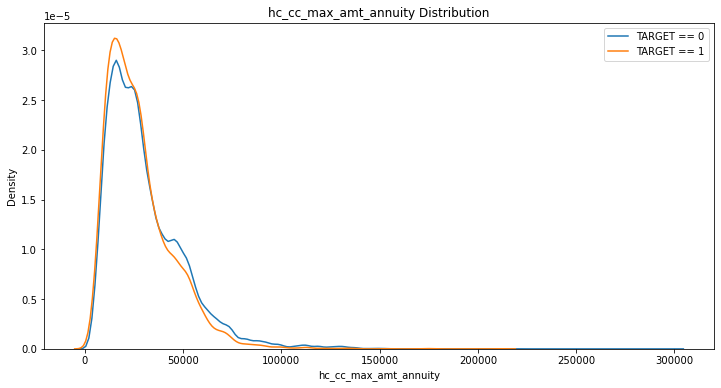

In [18]:
kde_target('hc_cc_max_amt_annuity', app_train)

In [19]:
app_train['hc_cc_max_amt_annuity'].isnull().sum()

196545

In [20]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_max_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_max_amt_annuity  
0  52.715068           27313.671276  
1  49.490411           21284.229171  
2  54.898630           23153.985000  
3  38.290411           45809.630604  
4  35.726027           30810.755800  

[5 rows x 92 columns]

In [21]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [22]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [23]:
app_train['hc_cc_max_amt_annuity'].isnull().sum()

0

In [24]:
app_train[['TARGET', 'hc_cc_max_amt_annuity']].corr()

TARGET  hc_cc_max_amt_annuity
TARGET                 1.000000              -0.026291
hc_cc_max_amt_annuity -0.026291               1.000000

In [25]:
## Yao-Johnson変換
num_cols = ['hc_cc_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_max_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_max_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_max_amt_annuity']].corr()

TARGET  hc_cc_max_amt_annuity
TARGET                 1.000000              -0.038351
hc_cc_max_amt_annuity -0.038351               1.000000

In [26]:
## 標準化
num_cols = ['hc_cc_max_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_max_amt_annuity', 'TARGET']].corr()

hc_cc_max_amt_annuity    TARGET
hc_cc_max_amt_annuity               1.000000 -0.038351
TARGET                             -0.038351  1.000000

The correlation between hc_cc_max_amt_annuity and the TARGET is -0.0384
Median value for loan that was not repaid = -0.1000
Median value for loan that was repaid =     -0.0052


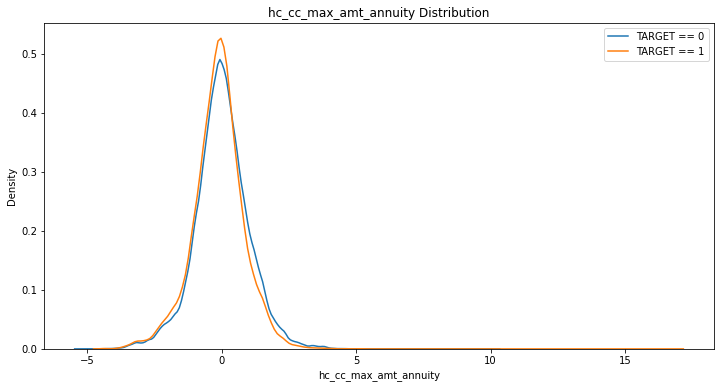

In [27]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_max_amt_annuity', app_train)

### hc_cc_min_amt_annuity

In [28]:
app_train[['TARGET', 'hc_cc_min_amt_annuity']].corr()

TARGET  hc_cc_min_amt_annuity
TARGET                 1.0000                -0.0416
hc_cc_min_amt_annuity -0.0416                 1.0000

The correlation between hc_cc_min_amt_annuity and the TARGET is -0.0416
Median value for loan that was not repaid = 18851.3550
Median value for loan that was repaid =     20287.1700


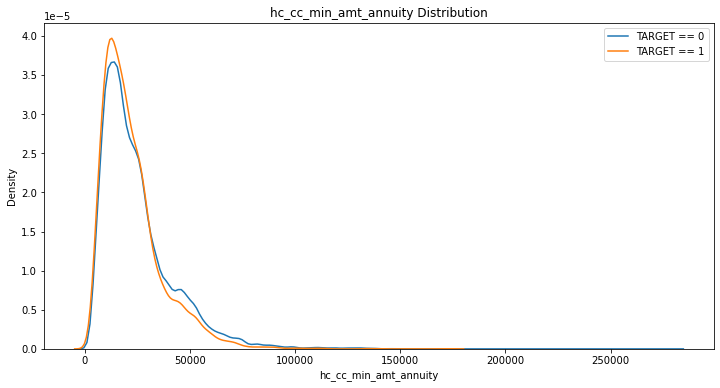

In [29]:
kde_target('hc_cc_min_amt_annuity', app_train)

In [30]:
app_train['hc_cc_min_amt_annuity'].isnull().sum()

196545

In [31]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_min_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_min_amt_annuity  
0  52.715068           21971.302008  
1  49.490411           17649.974534  
2  54.898630           23153.985000  
3  38.290411           40806.976280  
4  35.726027           27433.644174  

[5 rows x 92 columns]

In [32]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [33]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [34]:
app_train['hc_cc_min_amt_annuity'].isnull().sum()

0

In [35]:
app_train[['TARGET', 'hc_cc_min_amt_annuity']].corr()

TARGET  hc_cc_min_amt_annuity
TARGET                 1.000000              -0.021762
hc_cc_min_amt_annuity -0.021762               1.000000

In [36]:
## Yao-Johnson変換
num_cols = ['hc_cc_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_min_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_min_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_min_amt_annuity']].corr()

TARGET  hc_cc_min_amt_annuity
TARGET                 1.000000              -0.027443
hc_cc_min_amt_annuity -0.027443               1.000000

In [37]:
## 標準化
num_cols = ['hc_cc_min_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_min_amt_annuity', 'TARGET']].corr()

hc_cc_min_amt_annuity    TARGET
hc_cc_min_amt_annuity               1.000000 -0.027443
TARGET                             -0.027443  1.000000

The correlation between hc_cc_min_amt_annuity and the TARGET is -0.0274
Median value for loan that was not repaid = -0.0457
Median value for loan that was repaid =     0.0104


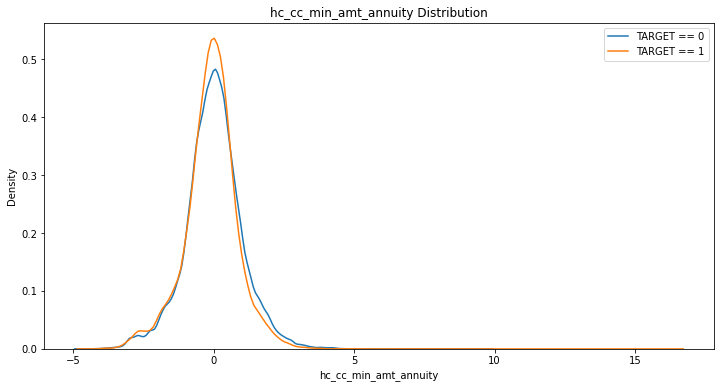

In [38]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_min_amt_annuity', app_train)

### hc_cc_sum_amt_annuity

In [39]:
app_train[['TARGET', 'hc_cc_sum_amt_annuity']].corr()

TARGET  hc_cc_sum_amt_annuity
TARGET                 1.000000              -0.028092
hc_cc_sum_amt_annuity -0.028092               1.000000

The correlation between hc_cc_sum_amt_annuity and the TARGET is -0.0281
Median value for loan that was not repaid = 3455613.6300
Median value for loan that was repaid =     4263541.1100


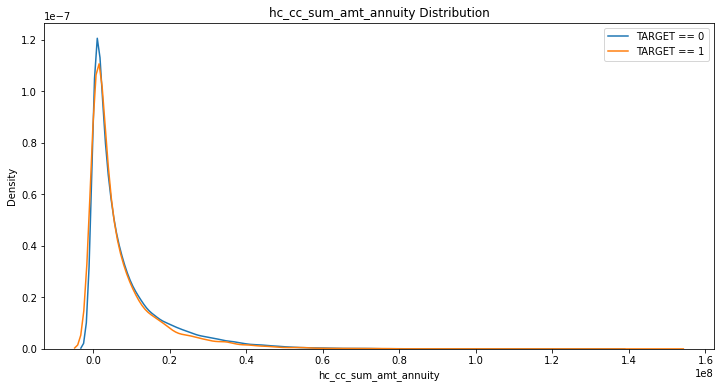

In [40]:
kde_target('hc_cc_sum_amt_annuity', app_train)

In [41]:
app_train['hc_cc_sum_amt_annuity'].isnull().sum()

196545

In [42]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_sum_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_sum_amt_annuity  
0  52.715068           9.824060e+06  
1  49.490411           5.798060e+06  
2  54.898630           7.779739e+06  
3  38.290411           1.236917e+07  
4  35.726027           6.649737e+06  

[5 rows x 92 columns]

In [43]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [44]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [45]:
app_train['hc_cc_sum_amt_annuity'].isnull().sum()

0

In [46]:
app_train[['TARGET', 'hc_cc_sum_amt_annuity']].corr()

TARGET  hc_cc_sum_amt_annuity
TARGET                 1.000000              -0.029306
hc_cc_sum_amt_annuity -0.029306               1.000000

In [47]:
## Yao-Johnson変換
num_cols = ['hc_cc_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_sum_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_sum_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_sum_amt_annuity']].corr()

TARGET  hc_cc_sum_amt_annuity
TARGET                 1.000000              -0.037453
hc_cc_sum_amt_annuity -0.037453               1.000000

In [48]:
## 標準化
num_cols = ['hc_cc_sum_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_sum_amt_annuity', 'TARGET']].corr()

hc_cc_sum_amt_annuity    TARGET
hc_cc_sum_amt_annuity               1.000000 -0.037453
TARGET                             -0.037453  1.000000

The correlation between hc_cc_sum_amt_annuity and the TARGET is -0.0375
Median value for loan that was not repaid = -0.2465
Median value for loan that was repaid =     -0.1079


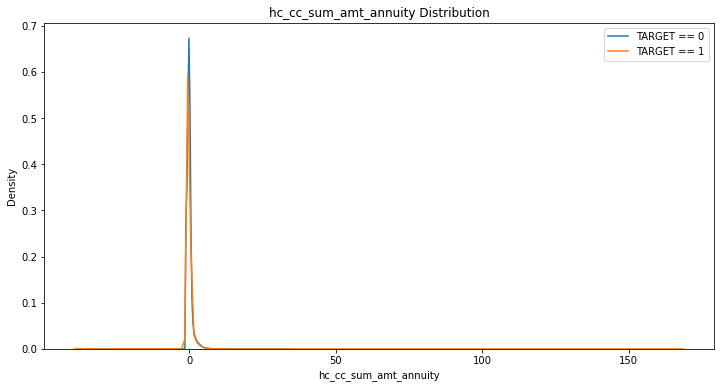

In [49]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_sum_amt_annuity', app_train)

### hc_cc_avg_amt_annuity

In [50]:
app_train[['TARGET', 'hc_cc_avg_amt_annuity']].corr()

TARGET  hc_cc_avg_amt_annuity
TARGET                 1.000000              -0.043712
hc_cc_avg_amt_annuity -0.043712               1.000000

The correlation between hc_cc_avg_amt_annuity and the TARGET is -0.0437
Median value for loan that was not repaid = 21929.4639
Median value for loan that was repaid =     23737.4179


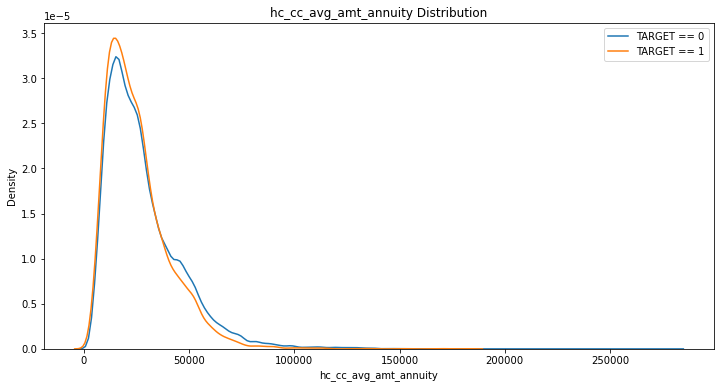

In [51]:
kde_target('hc_cc_avg_amt_annuity', app_train)

In [52]:
app_train['hc_cc_avg_amt_annuity'].isnull().sum()

196545

In [53]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_avg_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_avg_amt_annuity  
0  52.715068           25009.445863  
1  49.490411           19636.736427  
2  54.898630           23153.985000  
3  38.290411           43540.493004  
4  35.726027           29268.344547  

[5 rows x 92 columns]

In [54]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [55]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [56]:
app_train['hc_cc_avg_amt_annuity'].isnull().sum()

0

In [57]:
app_train[['TARGET', 'hc_cc_avg_amt_annuity']].corr()

TARGET  hc_cc_avg_amt_annuity
TARGET                 1.000000              -0.024817
hc_cc_avg_amt_annuity -0.024817               1.000000

In [58]:
## Yao-Johnson変換
num_cols = ['hc_cc_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_avg_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_avg_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_avg_amt_annuity']].corr()

TARGET  hc_cc_avg_amt_annuity
TARGET                 1.000000              -0.034551
hc_cc_avg_amt_annuity -0.034551               1.000000

In [59]:
## 標準化
num_cols = ['hc_cc_avg_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_avg_amt_annuity', 'TARGET']].corr()

hc_cc_avg_amt_annuity    TARGET
hc_cc_avg_amt_annuity               1.000000 -0.034551
TARGET                             -0.034551  1.000000

The correlation between hc_cc_avg_amt_annuity and the TARGET is -0.0346
Median value for loan that was not repaid = -0.0814
Median value for loan that was repaid =     0.0006


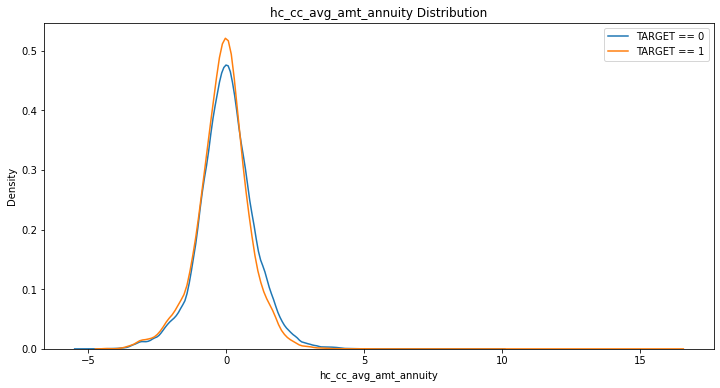

In [60]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_avg_amt_annuity', app_train)

### hc_cc_cnt_amt_annuity

In [61]:
app_train[['TARGET', 'hc_cc_cnt_amt_annuity']].corr()

TARGET  hc_cc_cnt_amt_annuity
TARGET                 1.000000              -0.014268
hc_cc_cnt_amt_annuity -0.014268               1.000000

The correlation between hc_cc_cnt_amt_annuity and the TARGET is -0.0143
Median value for loan that was not repaid = 166.0000
Median value for loan that was repaid =     182.0000


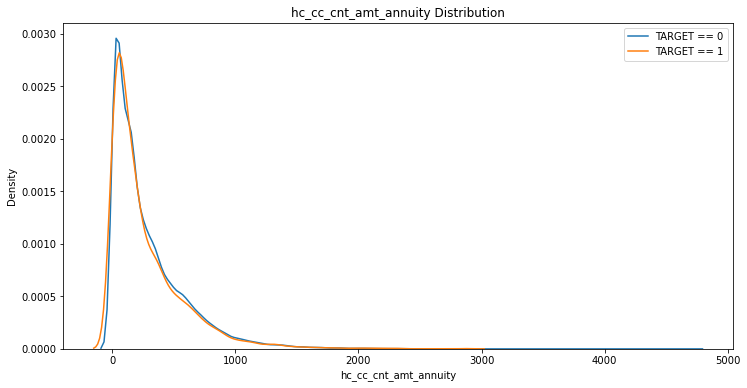

In [62]:
kde_target('hc_cc_cnt_amt_annuity', app_train)

In [63]:
app_train['hc_cc_cnt_amt_annuity'].isnull().sum()

196545

In [64]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_cnt_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_cnt_amt_annuity  
0  52.715068             346.863769  
1  49.490411             258.150973  
2  54.898630             336.000000  
3  38.290411             251.822610  
4  35.726027             200.678982  

[5 rows x 92 columns]

In [65]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [66]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [67]:
app_train['hc_cc_cnt_amt_annuity'].isnull().sum()

0

In [68]:
app_train[['TARGET', 'hc_cc_cnt_amt_annuity']].corr()

TARGET  hc_cc_cnt_amt_annuity
TARGET                 1.000000              -0.018386
hc_cc_cnt_amt_annuity -0.018386               1.000000

In [69]:
## Yao-Johnson変換
num_cols = ['hc_cc_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_cnt_amt_annuity']].corr()

TARGET  hc_cc_cnt_amt_annuity
TARGET                 1.000000              -0.026526
hc_cc_cnt_amt_annuity -0.026526               1.000000

In [70]:
## 標準化
num_cols = ['hc_cc_cnt_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_cnt_amt_annuity', 'TARGET']].corr()

hc_cc_cnt_amt_annuity    TARGET
hc_cc_cnt_amt_annuity               1.000000 -0.026526
TARGET                             -0.026526  1.000000

The correlation between hc_cc_cnt_amt_annuity and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0551
Median value for loan that was repaid =     0.0722


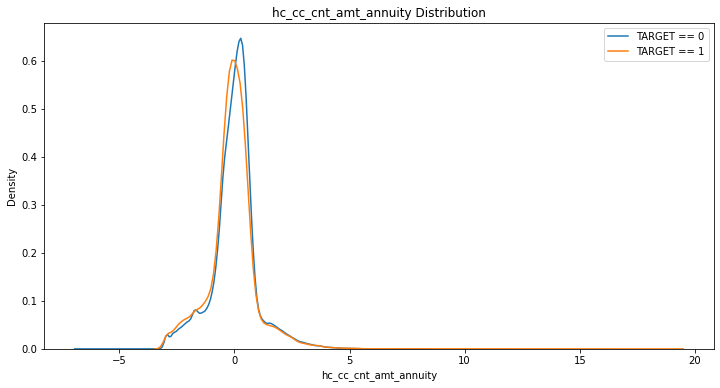

In [71]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_cnt_amt_annuity', app_train)

### hc_cc_stddev_amt_annuity

In [72]:
app_train[['TARGET', 'hc_cc_stddev_amt_annuity']].corr()

TARGET  hc_cc_stddev_amt_annuity
TARGET                    1.000000                 -0.011373
hc_cc_stddev_amt_annuity -0.011373                  1.000000

The correlation between hc_cc_stddev_amt_annuity and the TARGET is -0.0114
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


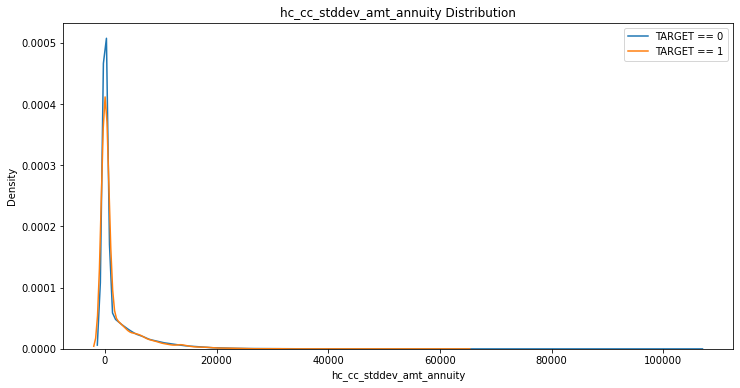

In [73]:
kde_target('hc_cc_stddev_amt_annuity', app_train)

In [74]:
app_train['hc_cc_stddev_amt_annuity'].isnull().sum()

196545

In [75]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_amt_annuity  
0  52.715068               1943.149654  
1  49.490411               1445.009465  
2  54.898630                  0.000000  
3  38.290411               1754.717119  
4  35.726027               1275.861954  

[5 rows x 92 columns]

In [76]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [77]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [78]:
app_train['hc_cc_stddev_amt_annuity'].isnull().sum()

0

In [79]:
app_train[['TARGET', 'hc_cc_stddev_amt_annuity']].corr()

TARGET  hc_cc_stddev_amt_annuity
TARGET                    1.000000                 -0.017077
hc_cc_stddev_amt_annuity -0.017077                  1.000000

In [80]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_amt_annuity']].corr()

TARGET  hc_cc_stddev_amt_annuity
TARGET                    1.000000                 -0.033117
hc_cc_stddev_amt_annuity -0.033117                  1.000000

In [81]:
## 標準化
num_cols = ['hc_cc_stddev_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_amt_annuity', 'TARGET']].corr()

hc_cc_stddev_amt_annuity    TARGET
hc_cc_stddev_amt_annuity                  1.000000 -0.033117
TARGET                                   -0.033117  1.000000

The correlation between hc_cc_stddev_amt_annuity and the TARGET is -0.0331
Median value for loan that was not repaid = -0.1687
Median value for loan that was repaid =     -0.0663


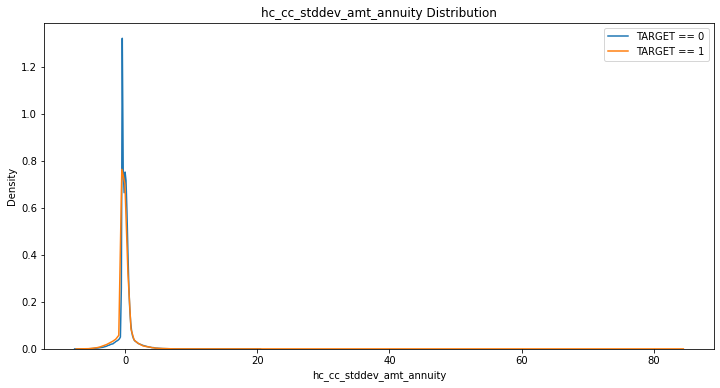

In [82]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_amt_annuity', app_train)

### hc_cc_stddev_pop_amt_annuity

In [83]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_annuity']].corr()

TARGET  hc_cc_stddev_pop_amt_annuity
TARGET                        1.000000                     -0.011373
hc_cc_stddev_pop_amt_annuity -0.011373                      1.000000

The correlation between hc_cc_stddev_pop_amt_annuity and the TARGET is -0.0114
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


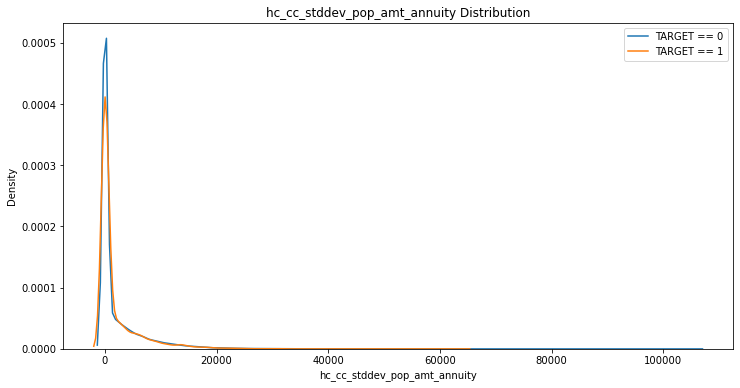

In [84]:
kde_target('hc_cc_stddev_pop_amt_annuity', app_train)

In [85]:
app_train['hc_cc_stddev_pop_amt_annuity'].isnull().sum()

196545

In [86]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_pop_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_pop_amt_annuity  
0  52.715068                   1943.149654  
1  49.490411                   1445.009465  
2  54.898630                      0.000000  
3  38.290411                   1754.717119  
4  35.726027                   1275.861954  

[5 rows x 92 columns]

In [87]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [88]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [89]:
app_train['hc_cc_stddev_pop_amt_annuity'].isnull().sum()

0

In [90]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_annuity']].corr()

TARGET  hc_cc_stddev_pop_amt_annuity
TARGET                        1.000000                     -0.017077
hc_cc_stddev_pop_amt_annuity -0.017077                      1.000000

In [91]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_pop_amt_annuity']].corr()

TARGET  hc_cc_stddev_pop_amt_annuity
TARGET                        1.000000                     -0.033117
hc_cc_stddev_pop_amt_annuity -0.033117                      1.000000

In [92]:
## 標準化
num_cols = ['hc_cc_stddev_pop_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_pop_amt_annuity', 'TARGET']].corr()

hc_cc_stddev_pop_amt_annuity    TARGET
hc_cc_stddev_pop_amt_annuity                      1.000000 -0.033117
TARGET                                           -0.033117  1.000000

The correlation between hc_cc_stddev_pop_amt_annuity and the TARGET is -0.0331
Median value for loan that was not repaid = -0.1687
Median value for loan that was repaid =     -0.0663


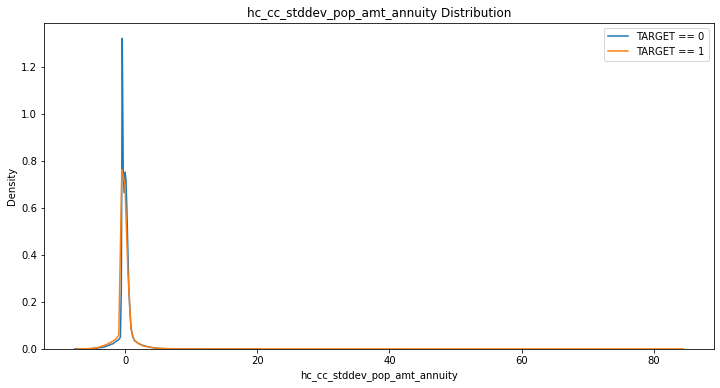

In [93]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_pop_amt_annuity', app_train)

### hc_cc_var_pop_amt_annuity

In [94]:
app_train[['TARGET', 'hc_cc_var_pop_amt_annuity']].corr()

TARGET  hc_cc_var_pop_amt_annuity
TARGET                     1.000000                  -0.010278
hc_cc_var_pop_amt_annuity -0.010278                   1.000000

The correlation between hc_cc_var_pop_amt_annuity and the TARGET is -0.0103
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


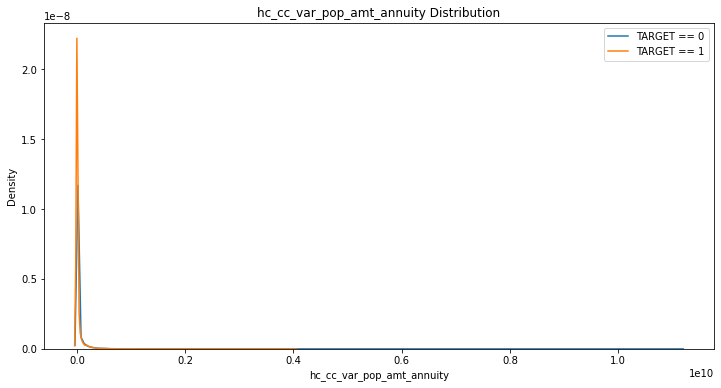

In [95]:
kde_target('hc_cc_var_pop_amt_annuity', app_train)

In [96]:
app_train['hc_cc_var_pop_amt_annuity'].isnull().sum()

196545

In [97]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_pop_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_pop_amt_annuity  
0  52.715068               1.414256e+07  
1  49.490411               1.194116e+07  
2  54.898630               0.000000e+00  
3  38.290411               2.392617e+07  
4  35.726027               1.538744e+07  

[5 rows x 92 columns]

In [98]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [99]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [100]:
app_train['hc_cc_var_pop_amt_annuity'].isnull().sum()

0

In [101]:
app_train[['TARGET', 'hc_cc_var_pop_amt_annuity']].corr()

TARGET  hc_cc_var_pop_amt_annuity
TARGET                     1.00000                   -0.01349
hc_cc_var_pop_amt_annuity -0.01349                    1.00000

In [102]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_pop_amt_annuity']].corr()

TARGET  hc_cc_var_pop_amt_annuity
TARGET                     1.000000                  -0.026193
hc_cc_var_pop_amt_annuity -0.026193                   1.000000

In [103]:
## 標準化
num_cols = ['hc_cc_var_pop_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_pop_amt_annuity', 'TARGET']].corr()

hc_cc_var_pop_amt_annuity    TARGET
hc_cc_var_pop_amt_annuity                   1.000000 -0.026193
TARGET                                     -0.026193  1.000000

The correlation between hc_cc_var_pop_amt_annuity and the TARGET is -0.0262
Median value for loan that was not repaid = -0.0914
Median value for loan that was repaid =     -0.0342


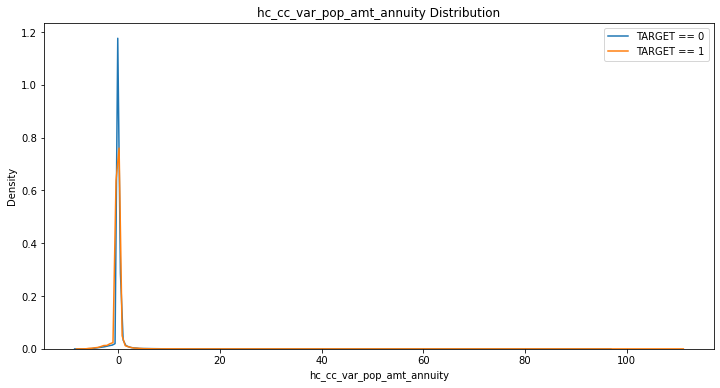

In [104]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_pop_amt_annuity', app_train)

### hc_cc_var_samp_amt_annuity

In [105]:
app_train[['TARGET', 'hc_cc_var_samp_amt_annuity']].corr()

TARGET  hc_cc_var_samp_amt_annuity
TARGET                      1.000000                   -0.010225
hc_cc_var_samp_amt_annuity -0.010225                    1.000000

The correlation between hc_cc_var_samp_amt_annuity and the TARGET is -0.0102
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


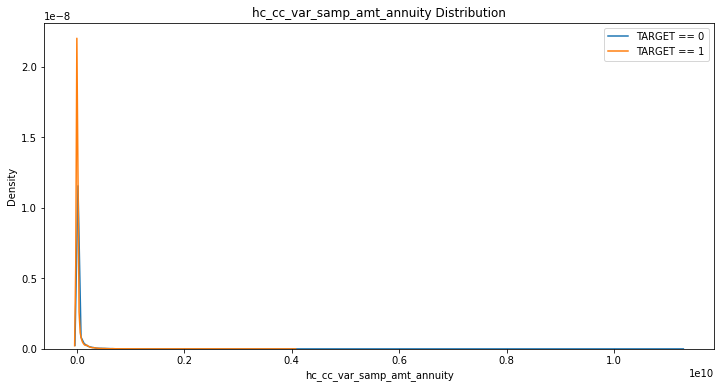

In [106]:
kde_target('hc_cc_var_samp_amt_annuity', app_train)

In [107]:
app_train['hc_cc_var_samp_amt_annuity'].isnull().sum()

196545

In [108]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_samp_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_samp_amt_annuity  
0  52.715068                1.415588e+07  
1  49.490411                1.196734e+07  
2  54.898630                0.000000e+00  
3  38.290411                2.404165e+07  
4  35.726027                1.551720e+07  

[5 rows x 92 columns]

In [109]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [110]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [111]:
app_train['hc_cc_var_samp_amt_annuity'].isnull().sum()

0

In [112]:
app_train[['TARGET', 'hc_cc_var_samp_amt_annuity']].corr()

TARGET  hc_cc_var_samp_amt_annuity
TARGET                      1.000000                   -0.013436
hc_cc_var_samp_amt_annuity -0.013436                    1.000000

In [113]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_samp_amt_annuity']].corr()

TARGET  hc_cc_var_samp_amt_annuity
TARGET                      1.000000                   -0.026082
hc_cc_var_samp_amt_annuity -0.026082                    1.000000

In [114]:
## 標準化
num_cols = ['hc_cc_var_samp_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_samp_amt_annuity', 'TARGET']].corr()

hc_cc_var_samp_amt_annuity    TARGET
hc_cc_var_samp_amt_annuity                    1.000000 -0.026082
TARGET                                       -0.026082  1.000000

The correlation between hc_cc_var_samp_amt_annuity and the TARGET is -0.0261
Median value for loan that was not repaid = -0.0917
Median value for loan that was repaid =     -0.0347


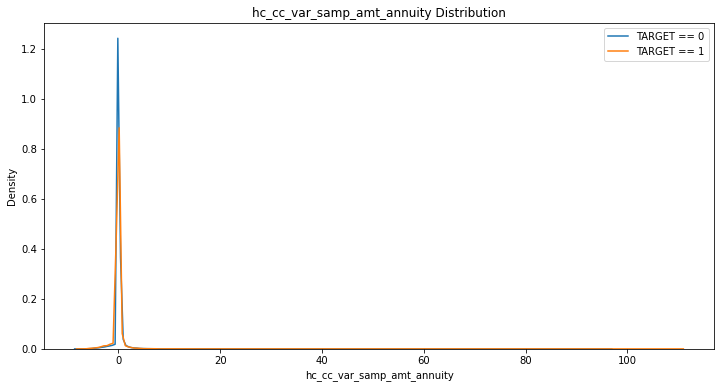

In [115]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_samp_amt_annuity', app_train)

### hc_cc_variance_samp_amt_annuity

In [116]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_annuity']].corr()

TARGET  hc_cc_variance_samp_amt_annuity
TARGET                           1.000000                        -0.010278
hc_cc_variance_samp_amt_annuity -0.010278                         1.000000

The correlation between hc_cc_variance_samp_amt_annuity and the TARGET is -0.0103
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


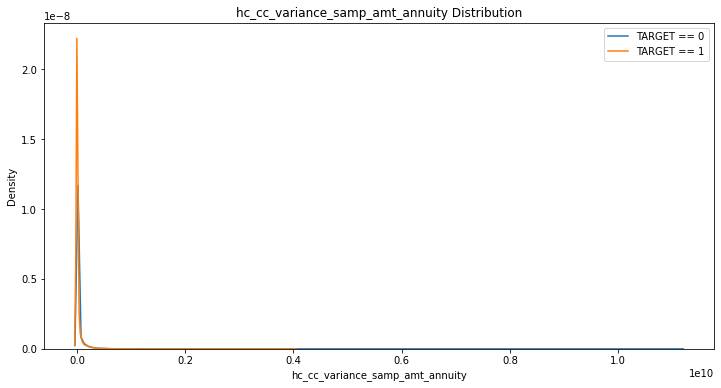

In [117]:
kde_target('hc_cc_variance_samp_amt_annuity', app_train)

In [118]:
app_train['hc_cc_variance_samp_amt_annuity'].isnull().sum()

196545

In [119]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_variance_samp_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_variance_samp_amt_annuity  
0  52.715068                     1.414256e+07  
1  49.490411                     1.194116e+07  
2  54.898630                     0.000000e+00  
3  38.290411                     2.392617e+07  
4  35.726027                     1.538744e+07  

[5 rows x 92 columns]

In [120]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [121]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [122]:
app_train['hc_cc_variance_samp_amt_annuity'].isnull().sum()

0

In [123]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_annuity']].corr()

TARGET  hc_cc_variance_samp_amt_annuity
TARGET                           1.00000                         -0.01349
hc_cc_variance_samp_amt_annuity -0.01349                          1.00000

In [124]:
## Yao-Johnson変換
num_cols = ['hc_cc_variance_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_variance_samp_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_cc_variance_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_variance_samp_amt_annuity']].corr()

TARGET  hc_cc_variance_samp_amt_annuity
TARGET                           1.000000                        -0.026193
hc_cc_variance_samp_amt_annuity -0.026193                         1.000000

In [125]:
## 標準化
num_cols = ['hc_cc_variance_samp_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_variance_samp_amt_annuity', 'TARGET']].corr()

hc_cc_variance_samp_amt_annuity    TARGET
hc_cc_variance_samp_amt_annuity                         1.000000 -0.026193
TARGET                                                 -0.026193  1.000000

The correlation between hc_cc_variance_samp_amt_annuity and the TARGET is -0.0262
Median value for loan that was not repaid = -0.0914
Median value for loan that was repaid =     -0.0342


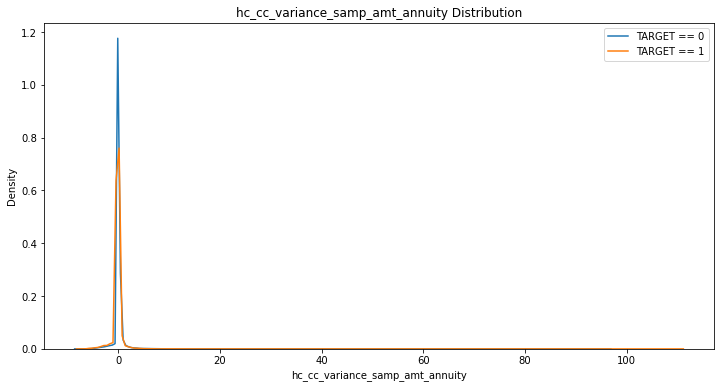

In [126]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_variance_samp_amt_annuity', app_train)

### hc_cc_max_amt_application

In [127]:
app_train[['TARGET', 'hc_cc_max_amt_application']].corr()

TARGET  hc_cc_max_amt_application
TARGET                     1.000000                  -0.033516
hc_cc_max_amt_application -0.033516                   1.000000

The correlation between hc_cc_max_amt_application and the TARGET is -0.0335
Median value for loan that was not repaid = 337500.0000
Median value for loan that was repaid =     391500.0000


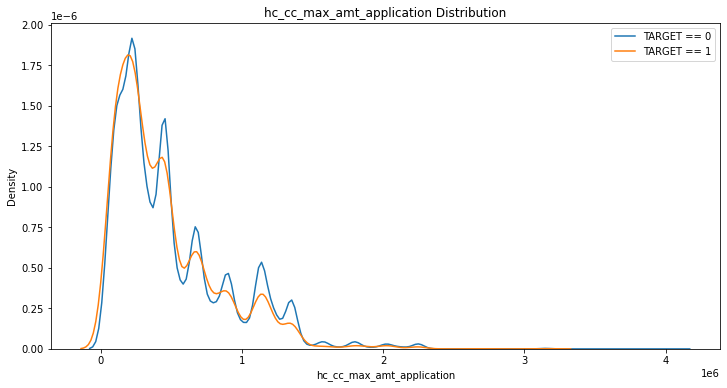

In [128]:
kde_target('hc_cc_max_amt_application', app_train)

In [129]:
app_train['hc_cc_max_amt_application'].isnull().sum()

196545

In [130]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_max_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_max_amt_application  
0  52.715068              514876.342020  
1  49.490411              304890.417589  
2  54.898630              450000.000000  
3  38.290411              949309.092885  
4  35.726027              493764.392306  

[5 rows x 92 columns]

In [131]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [132]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [133]:
app_train['hc_cc_max_amt_application'].isnull().sum()

0

In [134]:
app_train[['TARGET', 'hc_cc_max_amt_application']].corr()

TARGET  hc_cc_max_amt_application
TARGET                     1.000000                  -0.044996
hc_cc_max_amt_application -0.044996                   1.000000

In [135]:
## Yao-Johnson変換
num_cols = ['hc_cc_max_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_max_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_max_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_max_amt_application']].corr()

TARGET  hc_cc_max_amt_application
TARGET                     1.000000                  -0.060179
hc_cc_max_amt_application -0.060179                   1.000000

In [136]:
## 標準化
num_cols = ['hc_cc_max_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_max_amt_application', 'TARGET']].corr()

hc_cc_max_amt_application    TARGET
hc_cc_max_amt_application                   1.000000 -0.060179
TARGET                                     -0.060179  1.000000

The correlation between hc_cc_max_amt_application and the TARGET is -0.0602
Median value for loan that was not repaid = -0.3459
Median value for loan that was repaid =     -0.0825


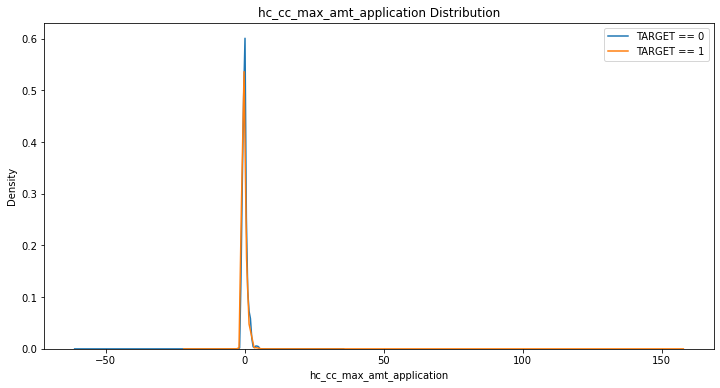

In [137]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_max_amt_application', app_train)

### hc_cc_min_amt_application

In [138]:
app_train[['TARGET', 'hc_cc_min_amt_application']].corr()

TARGET  hc_cc_min_amt_application
TARGET                     1.000000                  -0.033025
hc_cc_min_amt_application -0.033025                   1.000000

The correlation between hc_cc_min_amt_application and the TARGET is -0.0330
Median value for loan that was not repaid = 225000.0000
Median value for loan that was repaid =     238500.0000


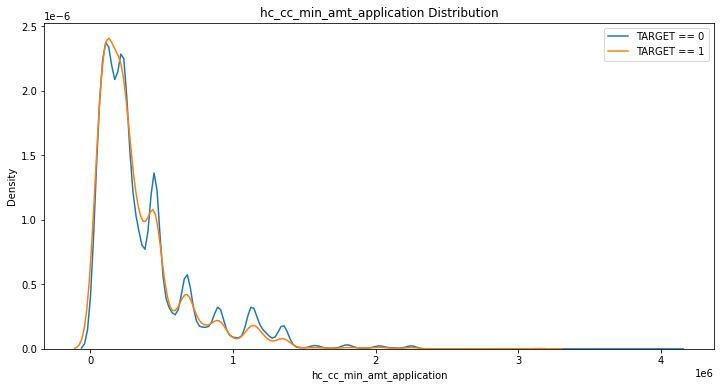

In [139]:
kde_target('hc_cc_min_amt_application', app_train)

In [140]:
app_train['hc_cc_min_amt_application'].isnull().sum()

196545

In [141]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_min_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_min_amt_application  
0  52.715068              391551.342339  
1  49.490411              233689.541904  
2  54.898630              450000.000000  
3  38.290411              814279.411253  
4  35.726027              425085.628911  

[5 rows x 92 columns]

In [142]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [143]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [144]:
app_train['hc_cc_min_amt_application'].isnull().sum()

0

In [145]:
app_train[['TARGET', 'hc_cc_min_amt_application']].corr()

TARGET  hc_cc_min_amt_application
TARGET                     1.00000                   -0.02818
hc_cc_min_amt_application -0.02818                    1.00000

In [146]:
## Yao-Johnson変換
num_cols = ['hc_cc_min_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_min_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_min_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_min_amt_application']].corr()

TARGET  hc_cc_min_amt_application
TARGET                     1.00000                   -0.03898
hc_cc_min_amt_application -0.03898                    1.00000

In [147]:
## 標準化
num_cols = ['hc_cc_min_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_min_amt_application', 'TARGET']].corr()

hc_cc_min_amt_application   TARGET
hc_cc_min_amt_application                    1.00000 -0.03898
TARGET                                      -0.03898  1.00000

The correlation between hc_cc_min_amt_application and the TARGET is -0.0390
Median value for loan that was not repaid = -0.1089
Median value for loan that was repaid =     0.0114


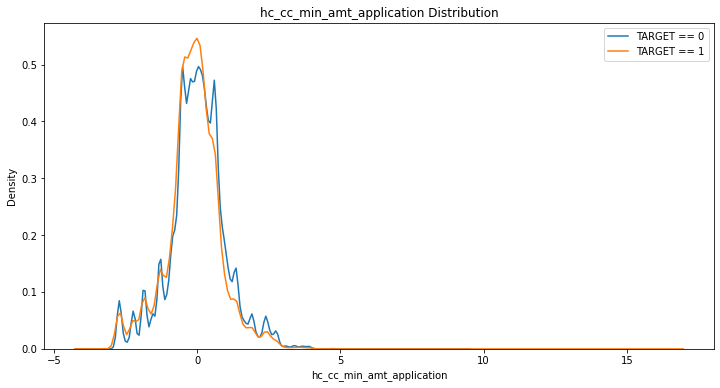

In [148]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_min_amt_application', app_train)

### hc_cc_sum_amt_application

In [149]:
app_train[['TARGET', 'hc_cc_sum_amt_application']].corr()

TARGET  hc_cc_sum_amt_application
TARGET                     1.000000                  -0.024985
hc_cc_sum_amt_application -0.024985                   1.000000

The correlation between hc_cc_sum_amt_application and the TARGET is -0.0250
Median value for loan that was not repaid = 46170000.0000
Median value for loan that was repaid =     58212000.0000


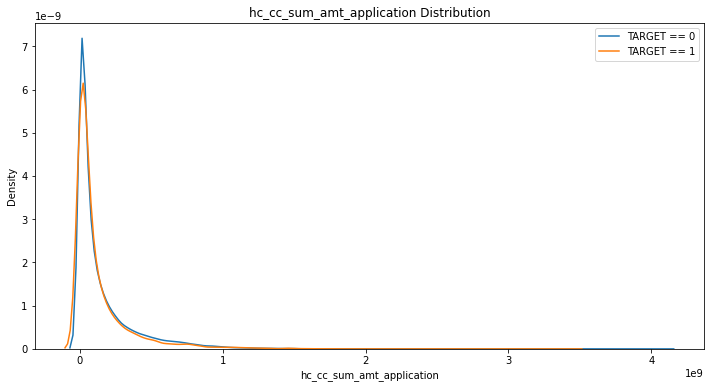

In [150]:
kde_target('hc_cc_sum_amt_application', app_train)

In [151]:
app_train['hc_cc_sum_amt_application'].isnull().sum()

196545

In [152]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_sum_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_sum_amt_application  
0  52.715068               1.892445e+08  
1  49.490411               9.293536e+07  
2  54.898630               1.512000e+08  
3  38.290411               2.740110e+08  
4  35.726027               1.195324e+08  

[5 rows x 92 columns]

In [153]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [154]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [155]:
app_train['hc_cc_sum_amt_application'].isnull().sum()

0

In [156]:
app_train[['TARGET', 'hc_cc_sum_amt_application']].corr()

TARGET  hc_cc_sum_amt_application
TARGET                     1.000000                  -0.030939
hc_cc_sum_amt_application -0.030939                   1.000000

In [157]:
## Yao-Johnson変換
num_cols = ['hc_cc_sum_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_sum_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_sum_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_sum_amt_application']].corr()

TARGET  hc_cc_sum_amt_application
TARGET                     1.000000                  -0.039343
hc_cc_sum_amt_application -0.039343                   1.000000

In [158]:
## 標準化
num_cols = ['hc_cc_sum_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_sum_amt_application', 'TARGET']].corr()

hc_cc_sum_amt_application    TARGET
hc_cc_sum_amt_application                   1.000000 -0.039343
TARGET                                     -0.039343  1.000000

The correlation between hc_cc_sum_amt_application and the TARGET is -0.0393
Median value for loan that was not repaid = -0.2709
Median value for loan that was repaid =     -0.1134


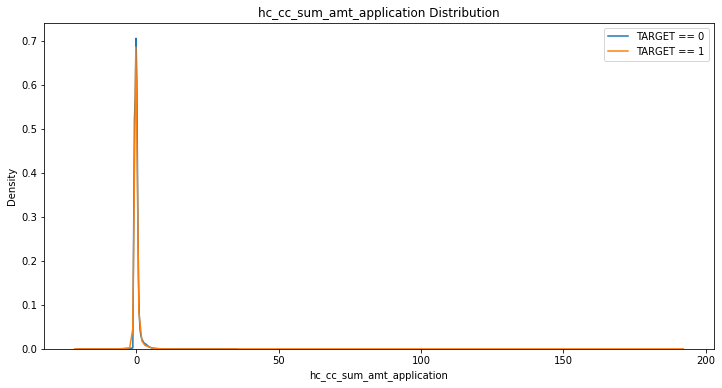

In [159]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_sum_amt_application', app_train)

### hc_cc_avg_amt_application

In [160]:
app_train[['TARGET', 'hc_cc_avg_amt_application']].corr()

TARGET  hc_cc_avg_amt_application
TARGET                     1.000000                  -0.034241
hc_cc_avg_amt_application -0.034241                   1.000000

The correlation between hc_cc_avg_amt_application and the TARGET is -0.0342
Median value for loan that was not repaid = 315000.0000
Median value for loan that was repaid =     337500.0000


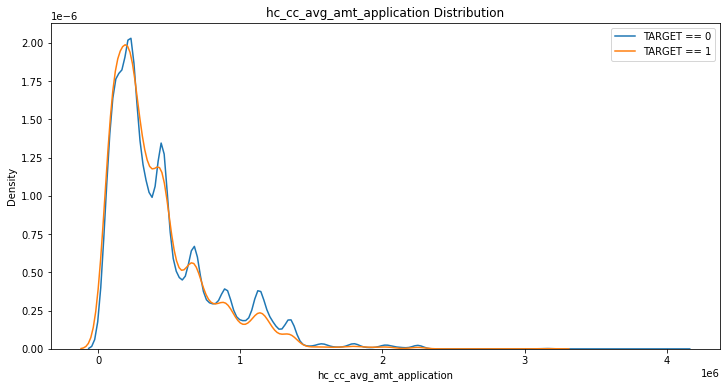

In [161]:
kde_target('hc_cc_avg_amt_application', app_train)

In [162]:
app_train['hc_cc_avg_amt_application'].isnull().sum()

196545

In [163]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_avg_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_avg_amt_application  
0  52.715068              467823.230938  
1  49.490411              277215.880348  
2  54.898630              450000.000000  
3  38.290411              894786.939118  
4  35.726027              465992.198906  

[5 rows x 92 columns]

In [164]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [165]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [166]:
app_train['hc_cc_avg_amt_application'].isnull().sum()

0

In [167]:
app_train[['TARGET', 'hc_cc_avg_amt_application']].corr()

TARGET  hc_cc_avg_amt_application
TARGET                     1.000000                  -0.031177
hc_cc_avg_amt_application -0.031177                   1.000000

In [168]:
## Yao-Johnson変換
num_cols = ['hc_cc_avg_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_avg_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_avg_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_avg_amt_application']].corr()

TARGET  hc_cc_avg_amt_application
TARGET                     1.000000                  -0.047241
hc_cc_avg_amt_application -0.047241                   1.000000

In [169]:
## 標準化
num_cols = ['hc_cc_avg_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_avg_amt_application', 'TARGET']].corr()

hc_cc_avg_amt_application    TARGET
hc_cc_avg_amt_application                   1.000000 -0.047241
TARGET                                     -0.047241  1.000000

The correlation between hc_cc_avg_amt_application and the TARGET is -0.0472
Median value for loan that was not repaid = -0.1486
Median value for loan that was repaid =     0.0253


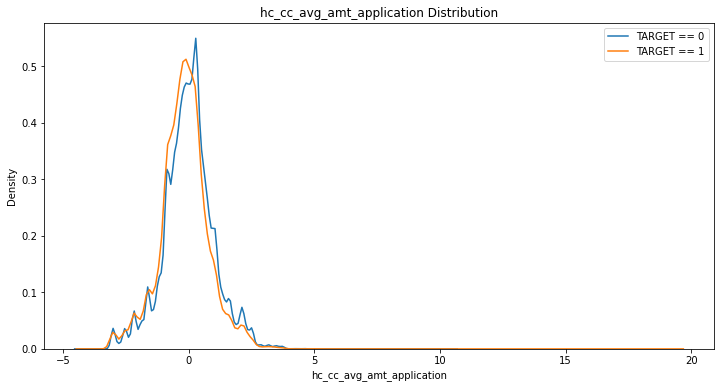

In [170]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_avg_amt_application', app_train)

### hc_cc_cnt_amt_application

In [171]:
app_train[['TARGET', 'hc_cc_cnt_amt_application']].corr()

TARGET  hc_cc_cnt_amt_application
TARGET                     1.000000                  -0.014268
hc_cc_cnt_amt_application -0.014268                   1.000000

The correlation between hc_cc_cnt_amt_application and the TARGET is -0.0143
Median value for loan that was not repaid = 166.0000
Median value for loan that was repaid =     182.0000


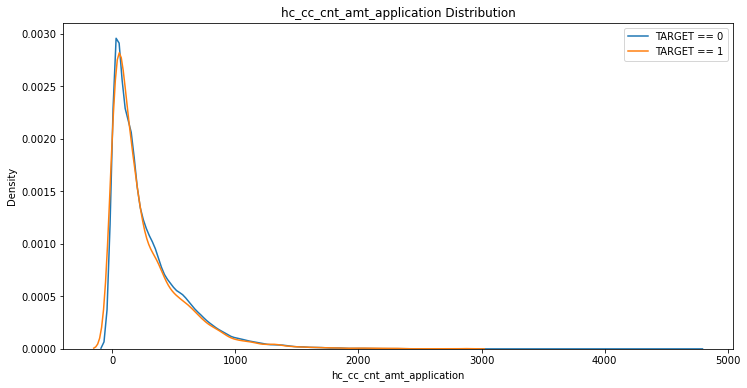

In [172]:
kde_target('hc_cc_cnt_amt_application', app_train)

In [173]:
app_train['hc_cc_cnt_amt_application'].isnull().sum()

196545

In [174]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_cnt_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_cnt_amt_application  
0  52.715068                 346.863769  
1  49.490411                 258.150973  
2  54.898630                 336.000000  
3  38.290411                 251.822610  
4  35.726027                 200.678982  

[5 rows x 92 columns]

In [175]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [176]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [177]:
app_train['hc_cc_cnt_amt_application'].isnull().sum()

0

In [178]:
app_train[['TARGET', 'hc_cc_cnt_amt_application']].corr()

TARGET  hc_cc_cnt_amt_application
TARGET                     1.000000                  -0.018386
hc_cc_cnt_amt_application -0.018386                   1.000000

In [179]:
## Yao-Johnson変換
num_cols = ['hc_cc_cnt_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_cnt_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_cnt_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_cnt_amt_application']].corr()

TARGET  hc_cc_cnt_amt_application
TARGET                     1.000000                  -0.026526
hc_cc_cnt_amt_application -0.026526                   1.000000

In [180]:
## 標準化
num_cols = ['hc_cc_cnt_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_cnt_amt_application', 'TARGET']].corr()

hc_cc_cnt_amt_application    TARGET
hc_cc_cnt_amt_application                   1.000000 -0.026526
TARGET                                     -0.026526  1.000000

The correlation between hc_cc_cnt_amt_application and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0551
Median value for loan that was repaid =     0.0722


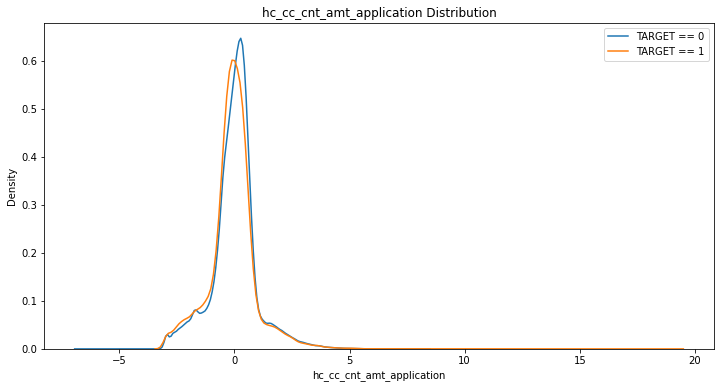

In [181]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_cnt_amt_application', app_train)

### hc_cc_stddev_amt_application

In [182]:
app_train[['TARGET', 'hc_cc_stddev_amt_application']].corr()

TARGET  hc_cc_stddev_amt_application
TARGET                        1.000000                     -0.007217
hc_cc_stddev_amt_application -0.007217                      1.000000

The correlation between hc_cc_stddev_amt_application and the TARGET is -0.0072
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


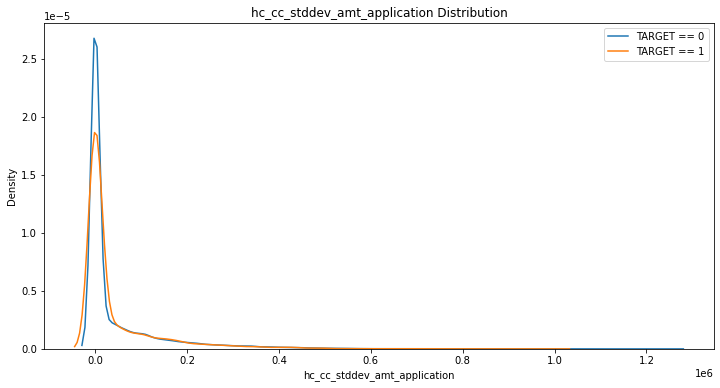

In [183]:
kde_target('hc_cc_stddev_amt_application', app_train)

In [184]:
app_train['hc_cc_stddev_amt_application'].isnull().sum()

196545

In [185]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_amt_application  
0  52.715068                  45118.338917  
1  49.490411                  27283.090412  
2  54.898630                      0.000000  
3  38.290411                  47688.843789  
4  35.726027                  24863.214342  

[5 rows x 92 columns]

In [186]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [187]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [188]:
app_train['hc_cc_stddev_amt_application'].isnull().sum()

0

In [189]:
app_train[['TARGET', 'hc_cc_stddev_amt_application']].corr()

TARGET  hc_cc_stddev_amt_application
TARGET                        1.000000                     -0.020393
hc_cc_stddev_amt_application -0.020393                      1.000000

In [190]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_amt_application']].corr()

TARGET  hc_cc_stddev_amt_application
TARGET                        1.000000                     -0.033867
hc_cc_stddev_amt_application -0.033867                      1.000000

In [191]:
## 標準化
num_cols = ['hc_cc_stddev_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_amt_application', 'TARGET']].corr()

hc_cc_stddev_amt_application    TARGET
hc_cc_stddev_amt_application                      1.000000 -0.033867
TARGET                                           -0.033867  1.000000

The correlation between hc_cc_stddev_amt_application and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1726
Median value for loan that was repaid =     0.0051


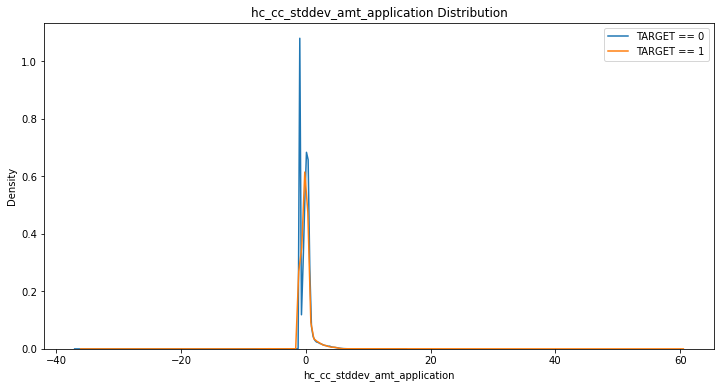

In [192]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_amt_application', app_train)

### hc_cc_stddev_pop_amt_application

In [193]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_application']].corr()

TARGET  hc_cc_stddev_pop_amt_application
TARGET                            1.000000                         -0.007217
hc_cc_stddev_pop_amt_application -0.007217                          1.000000

The correlation between hc_cc_stddev_pop_amt_application and the TARGET is -0.0072
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


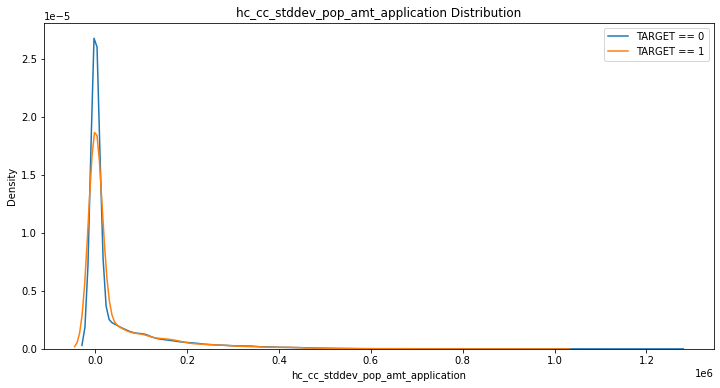

In [194]:
kde_target('hc_cc_stddev_pop_amt_application', app_train)

In [195]:
app_train['hc_cc_stddev_pop_amt_application'].isnull().sum()

196545

In [196]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_pop_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_pop_amt_application  
0  52.715068                      45118.338917  
1  49.490411                      27283.090412  
2  54.898630                          0.000000  
3  38.290411                      47688.843789  
4  35.726027                      24863.214342  

[5 rows x 92 columns]

In [197]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [198]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [199]:
app_train['hc_cc_stddev_pop_amt_application'].isnull().sum()

0

In [200]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_application']].corr()

TARGET  hc_cc_stddev_pop_amt_application
TARGET                            1.000000                         -0.020393
hc_cc_stddev_pop_amt_application -0.020393                          1.000000

In [201]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_pop_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_pop_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_pop_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_pop_amt_application']].corr()

TARGET  hc_cc_stddev_pop_amt_application
TARGET                            1.000000                         -0.033867
hc_cc_stddev_pop_amt_application -0.033867                          1.000000

In [202]:
## 標準化
num_cols = ['hc_cc_stddev_pop_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_pop_amt_application', 'TARGET']].corr()

hc_cc_stddev_pop_amt_application    TARGET
hc_cc_stddev_pop_amt_application                          1.000000 -0.033867
TARGET                                                   -0.033867  1.000000

The correlation between hc_cc_stddev_pop_amt_application and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1726
Median value for loan that was repaid =     0.0051


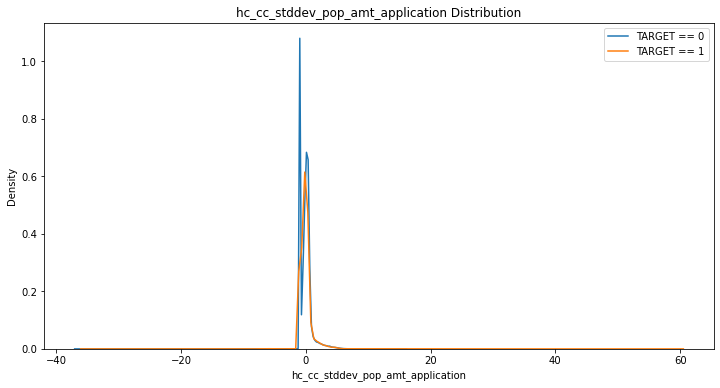

In [203]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_pop_amt_application', app_train)

### hc_cc_var_pop_amt_application

In [204]:
app_train[['TARGET', 'hc_cc_var_pop_amt_application']].corr()

TARGET  hc_cc_var_pop_amt_application
TARGET                         1.000000                      -0.006625
hc_cc_var_pop_amt_application -0.006625                       1.000000

The correlation between hc_cc_var_pop_amt_application and the TARGET is -0.0066
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


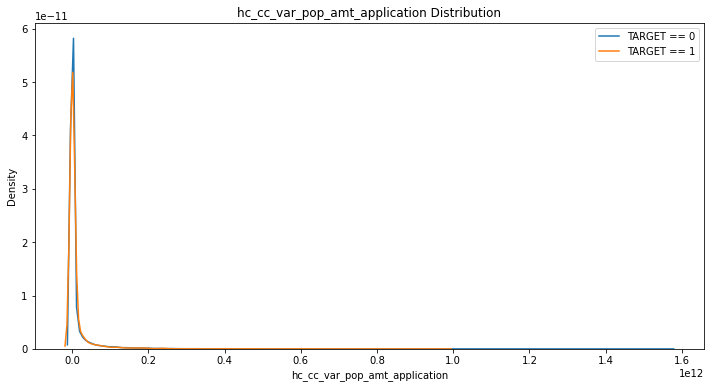

In [205]:
kde_target('hc_cc_var_pop_amt_application', app_train)

In [206]:
app_train['hc_cc_var_pop_amt_application'].isnull().sum()

196545

In [207]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_pop_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_pop_amt_application  
0  52.715068                   9.425900e+09  
1  49.490411                   4.693259e+09  
2  54.898630                   0.000000e+00  
3  38.290411                   1.531277e+10  
4  35.726027                   6.140652e+09  

[5 rows x 92 columns]

In [208]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [209]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [210]:
app_train['hc_cc_var_pop_amt_application'].isnull().sum()

0

In [211]:
app_train[['TARGET', 'hc_cc_var_pop_amt_application']].corr()

TARGET  hc_cc_var_pop_amt_application
TARGET                         1.000000                      -0.016189
hc_cc_var_pop_amt_application -0.016189                       1.000000

In [212]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_pop_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_pop_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_pop_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_pop_amt_application']].corr()

TARGET  hc_cc_var_pop_amt_application
TARGET                         1.000000                      -0.033885
hc_cc_var_pop_amt_application -0.033885                       1.000000

In [213]:
## 標準化
num_cols = ['hc_cc_var_pop_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_pop_amt_application', 'TARGET']].corr()

hc_cc_var_pop_amt_application    TARGET
hc_cc_var_pop_amt_application                       1.000000 -0.033885
TARGET                                             -0.033885  1.000000

The correlation between hc_cc_var_pop_amt_application and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0574


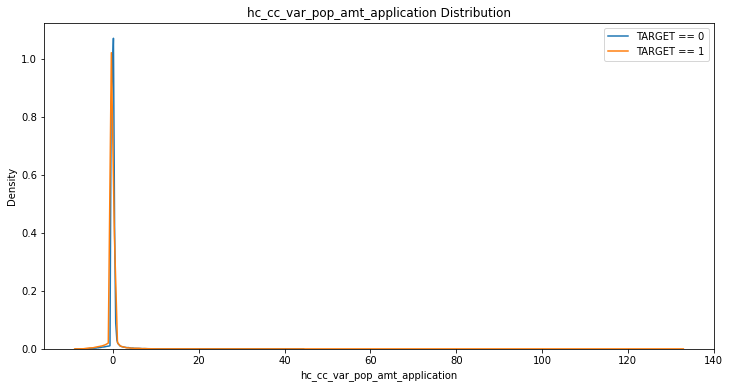

In [214]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_pop_amt_application', app_train)

### hc_cc_var_samp_amt_application

In [215]:
app_train[['TARGET', 'hc_cc_var_samp_amt_application']].corr()

TARGET  hc_cc_var_samp_amt_application
TARGET                          1.000000                       -0.006437
hc_cc_var_samp_amt_application -0.006437                        1.000000

The correlation between hc_cc_var_samp_amt_application and the TARGET is -0.0064
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


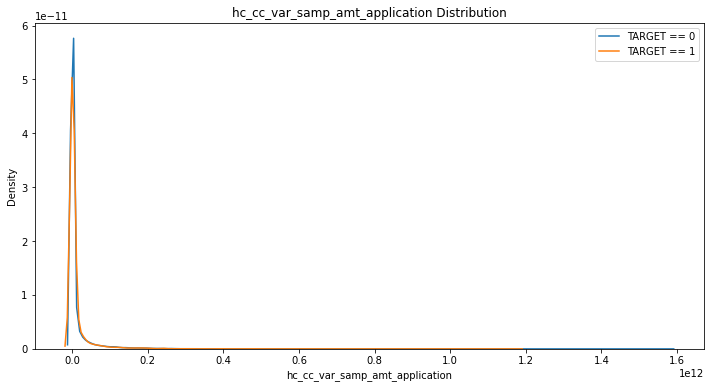

In [216]:
kde_target('hc_cc_var_samp_amt_application', app_train)

In [217]:
app_train['hc_cc_var_samp_amt_application'].isnull().sum()

196545

In [218]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_samp_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_samp_amt_application  
0  52.715068                    9.460943e+09  
1  49.490411                    4.710960e+09  
2  54.898630                    0.000000e+00  
3  38.290411                    1.539611e+10  
4  35.726027                    6.180979e+09  

[5 rows x 92 columns]

In [219]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [220]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [221]:
app_train['hc_cc_var_samp_amt_application'].isnull().sum()

0

In [222]:
app_train[['TARGET', 'hc_cc_var_samp_amt_application']].corr()

TARGET  hc_cc_var_samp_amt_application
TARGET                          1.000000                       -0.016055
hc_cc_var_samp_amt_application -0.016055                        1.000000

In [223]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_samp_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_samp_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_samp_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_samp_amt_application']].corr()

TARGET  hc_cc_var_samp_amt_application
TARGET                          1.000000                       -0.033697
hc_cc_var_samp_amt_application -0.033697                        1.000000

In [224]:
## 標準化
num_cols = ['hc_cc_var_samp_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_samp_amt_application', 'TARGET']].corr()

hc_cc_var_samp_amt_application    TARGET
hc_cc_var_samp_amt_application                        1.000000 -0.033697
TARGET                                               -0.033697  1.000000

The correlation between hc_cc_var_samp_amt_application and the TARGET is -0.0337
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0577


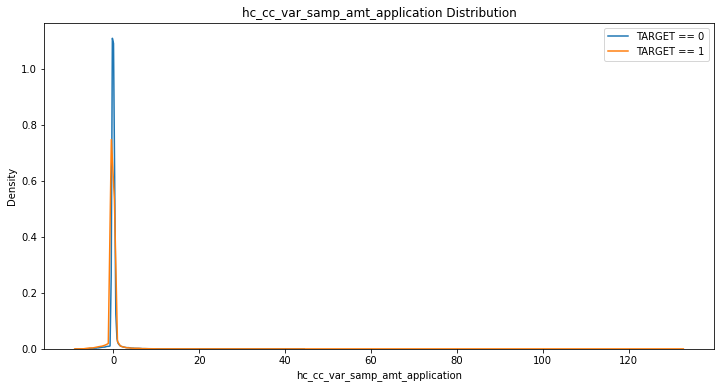

In [225]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_samp_amt_application', app_train)

In [226]:
### hc_cc_variance_samp_amt_application

In [227]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_application']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_application -0.006625   

                                     hc_cc_variance_samp_amt_application  
TARGET                                                         -0.006625  
hc_cc_variance_samp_amt_application                             1.000000

The correlation between hc_cc_variance_samp_amt_application and the TARGET is -0.0066
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


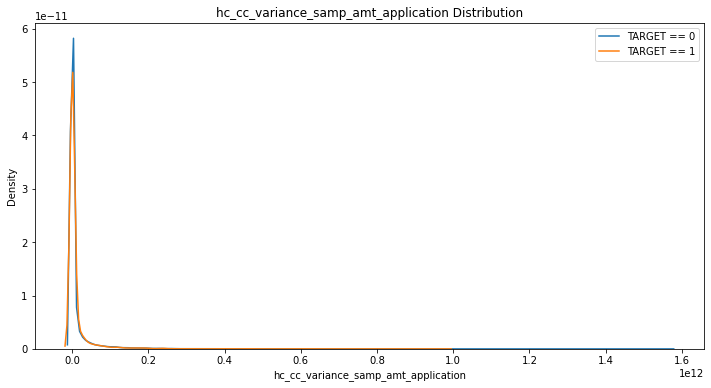

In [228]:
kde_target('hc_cc_variance_samp_amt_application', app_train)

In [229]:
app_train['hc_cc_variance_samp_amt_application'].isnull().sum()

196545

In [230]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_variance_samp_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_variance_samp_amt_application  
0  52.715068                         9.425900e+09  
1  49.490411                         4.693259e+09  
2  54.898630                         0.000000e+00  
3  38.290411                         1.531277e+10  
4  35.726027                         6.140652e+09  

[5 rows x 92 columns]

In [231]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [232]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [233]:
app_train['hc_cc_variance_samp_amt_application'].isnull().sum()

0

In [234]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_application']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_application -0.016189   

                                     hc_cc_variance_samp_amt_application  
TARGET                                                         -0.016189  
hc_cc_variance_samp_amt_application                             1.000000

In [235]:
## Yao-Johnson変換
num_cols = ['hc_cc_variance_samp_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_variance_samp_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_cc_variance_samp_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_variance_samp_amt_application']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_application -0.033885   

                                     hc_cc_variance_samp_amt_application  
TARGET                                                         -0.033885  
hc_cc_variance_samp_amt_application                             1.000000

In [236]:
## 標準化
num_cols = ['hc_cc_variance_samp_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_variance_samp_amt_application', 'TARGET']].corr()

hc_cc_variance_samp_amt_application  \
hc_cc_variance_samp_amt_application                             1.000000   
TARGET                                                         -0.033885   

                                       TARGET  
hc_cc_variance_samp_amt_application -0.033885  
TARGET                               1.000000

The correlation between hc_cc_variance_samp_amt_application and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0574


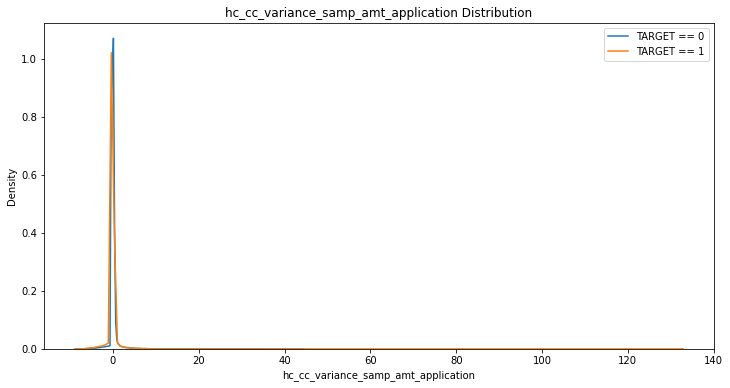

In [237]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_variance_samp_amt_application', app_train)

### hc_cc_max_amt_credit

In [238]:
app_train[['TARGET', 'hc_cc_max_amt_credit']].corr()

TARGET  hc_cc_max_amt_credit
TARGET                1.000000             -0.028528
hc_cc_max_amt_credit -0.028528              1.000000

The correlation between hc_cc_max_amt_credit and the TARGET is -0.0285
Median value for loan that was not repaid = 393399.0000
Median value for loan that was repaid =     445500.0000


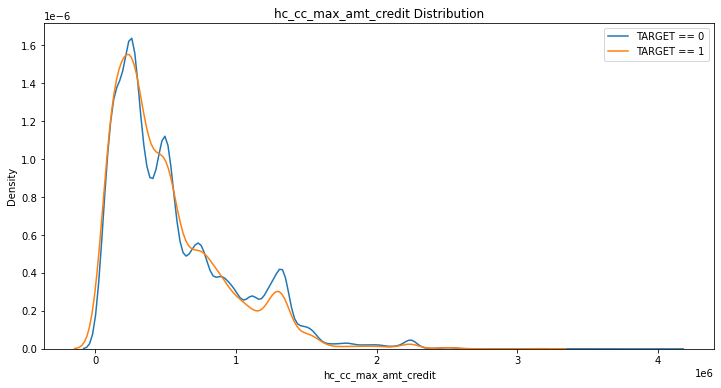

In [239]:
kde_target('hc_cc_max_amt_credit', app_train)

In [240]:
app_train['hc_cc_max_amt_credit'].isnull().sum()

196545

In [241]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_max_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_max_amt_credit  
0  52.715068          5.801402e+05  
1  49.490411          3.476706e+05  
2  54.898630          5.123700e+05  
3  38.290411          1.019205e+06  
4  35.726027          5.401416e+05  

[5 rows x 92 columns]

In [242]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [243]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [244]:
app_train['hc_cc_max_amt_credit'].isnull().sum()

0

In [245]:
app_train[['TARGET', 'hc_cc_max_amt_credit']].corr()

TARGET  hc_cc_max_amt_credit
TARGET                1.00000              -0.04135
hc_cc_max_amt_credit -0.04135               1.00000

In [246]:
## Yao-Johnson変換
num_cols = ['hc_cc_max_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_max_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_max_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_max_amt_credit']].corr()

TARGET  hc_cc_max_amt_credit
TARGET                1.000000             -0.056183
hc_cc_max_amt_credit -0.056183              1.000000

In [247]:
## 標準化
num_cols = ['hc_cc_max_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_max_amt_credit', 'TARGET']].corr()

hc_cc_max_amt_credit    TARGET
hc_cc_max_amt_credit              1.000000 -0.056183
TARGET                           -0.056183  1.000000

The correlation between hc_cc_max_amt_credit and the TARGET is -0.0562
Median value for loan that was not repaid = -0.3211
Median value for loan that was repaid =     -0.0883


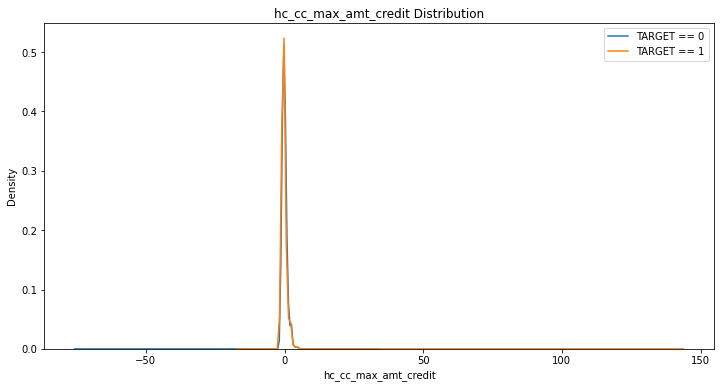

In [248]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_max_amt_credit', app_train)

### hc_cc_min_amt_credit

In [249]:
app_train[['TARGET', 'hc_cc_min_amt_credit']].corr()

TARGET  hc_cc_min_amt_credit
TARGET                1.000000             -0.028307
hc_cc_min_amt_credit -0.028307              1.000000

The correlation between hc_cc_min_amt_credit and the TARGET is -0.0283
Median value for loan that was not repaid = 271896.7500
Median value for loan that was repaid =     284400.0000


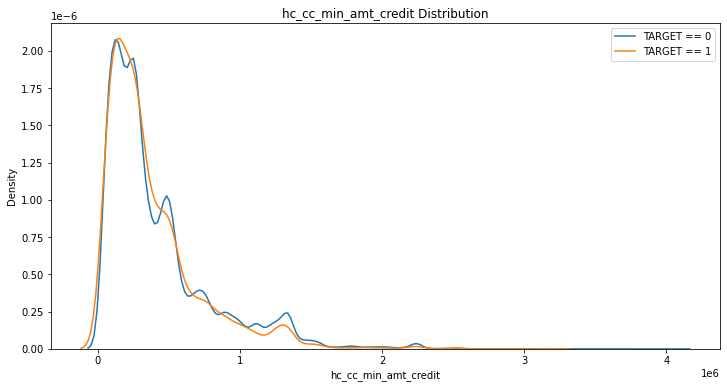

In [250]:
kde_target('hc_cc_min_amt_credit', app_train)

In [251]:
app_train['hc_cc_min_amt_credit'].isnull().sum()

196545

In [252]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_min_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_min_amt_credit  
0  52.715068         443595.606008  
1  49.490411         268308.425412  
2  54.898630         512370.000000  
3  38.290411         879895.168747  
4  35.726027         467494.084368  

[5 rows x 92 columns]

In [253]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [254]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [255]:
app_train['hc_cc_min_amt_credit'].isnull().sum()

0

In [256]:
app_train[['TARGET', 'hc_cc_min_amt_credit']].corr()

TARGET  hc_cc_min_amt_credit
TARGET                1.000000             -0.025209
hc_cc_min_amt_credit -0.025209              1.000000

In [257]:
## Yao-Johnson変換
num_cols = ['hc_cc_min_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_min_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_min_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_min_amt_credit']].corr()

TARGET  hc_cc_min_amt_credit
TARGET                1.000000             -0.034052
hc_cc_min_amt_credit -0.034052              1.000000

In [258]:
## 標準化
num_cols = ['hc_cc_min_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_min_amt_credit', 'TARGET']].corr()

hc_cc_min_amt_credit    TARGET
hc_cc_min_amt_credit              1.000000 -0.034052
TARGET                           -0.034052  1.000000

The correlation between hc_cc_min_amt_credit and the TARGET is -0.0341
Median value for loan that was not repaid = -0.0956
Median value for loan that was repaid =     0.0150


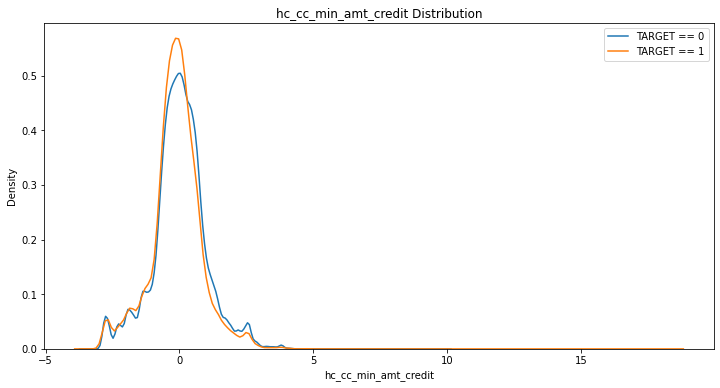

In [259]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_min_amt_credit', app_train)

### hc_cc_sum_amt_credit

In [260]:
app_train[['TARGET', 'hc_cc_sum_amt_credit']].corr()

TARGET  hc_cc_sum_amt_credit
TARGET                1.000000             -0.023146
hc_cc_sum_amt_credit -0.023146              1.000000

The correlation between hc_cc_sum_amt_credit and the TARGET is -0.0231
Median value for loan that was not repaid = 53415990.0000
Median value for loan that was repaid =     65394261.0000


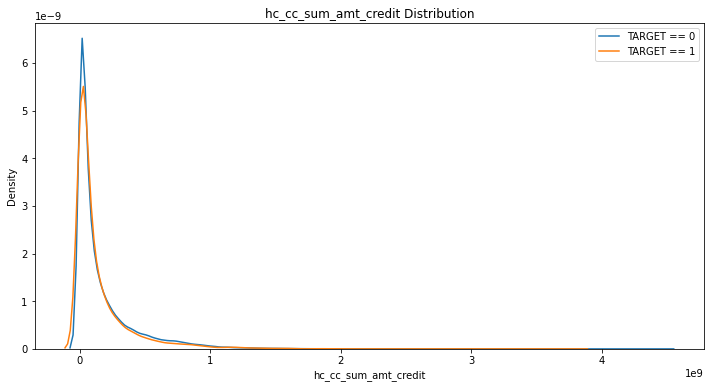

In [261]:
kde_target('hc_cc_sum_amt_credit', app_train)

In [262]:
app_train['hc_cc_sum_amt_credit'].isnull().sum()

196545

In [263]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_sum_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_sum_amt_credit  
0  52.715068          2.133483e+08  
1  49.490411          1.066497e+08  
2  54.898630          1.721563e+08  
3  38.290411          2.935831e+08  
4  35.726027          1.309503e+08  

[5 rows x 92 columns]

In [264]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [265]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [266]:
app_train['hc_cc_sum_amt_credit'].isnull().sum()

0

In [267]:
app_train[['TARGET', 'hc_cc_sum_amt_credit']].corr()

TARGET  hc_cc_sum_amt_credit
TARGET                1.000000             -0.029681
hc_cc_sum_amt_credit -0.029681              1.000000

In [268]:
## Yao-Johnson変換
num_cols = ['hc_cc_sum_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_sum_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_sum_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_sum_amt_credit']].corr()

TARGET  hc_cc_sum_amt_credit
TARGET                1.000000             -0.037593
hc_cc_sum_amt_credit -0.037593              1.000000

In [269]:
## 標準化
num_cols = ['hc_cc_sum_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_sum_amt_credit', 'TARGET']].corr()

hc_cc_sum_amt_credit    TARGET
hc_cc_sum_amt_credit              1.000000 -0.037593
TARGET                           -0.037593  1.000000

The correlation between hc_cc_sum_amt_credit and the TARGET is -0.0376
Median value for loan that was not repaid = -0.2688
Median value for loan that was repaid =     -0.1139


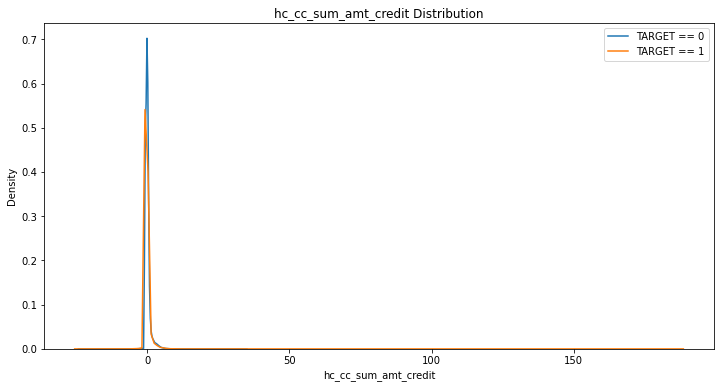

In [270]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_sum_amt_credit', app_train)

### hc_cc_avg_amt_credit

In [271]:
app_train[['TARGET', 'hc_cc_avg_amt_credit']].corr()

TARGET  hc_cc_avg_amt_credit
TARGET                1.000000             -0.029261
hc_cc_avg_amt_credit -0.029261              1.000000

The correlation between hc_cc_avg_amt_credit and the TARGET is -0.0293
Median value for loan that was not repaid = 357619.5000
Median value for loan that was repaid =     381492.7917


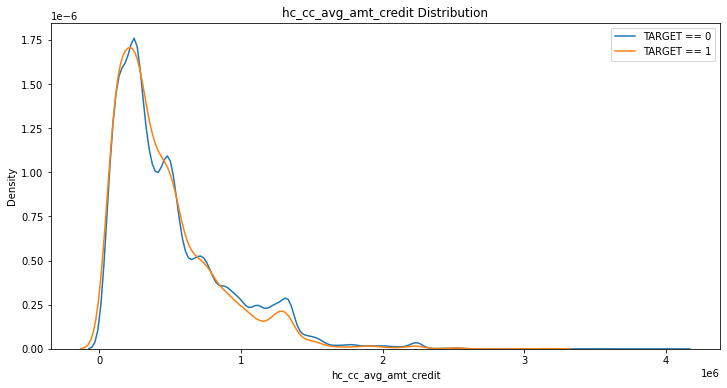

In [272]:
kde_target('hc_cc_avg_amt_credit', app_train)

In [273]:
app_train['hc_cc_avg_amt_credit'].isnull().sum()

196545

In [274]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_avg_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_avg_amt_credit  
0  52.715068         527998.969129  
1  49.490411         316949.431410  
2  54.898630         512370.000000  
3  38.290411         963678.483046  
4  35.726027         511045.809277  

[5 rows x 92 columns]

In [275]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [276]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [277]:
app_train['hc_cc_avg_amt_credit'].isnull().sum()

0

In [278]:
app_train[['TARGET', 'hc_cc_avg_amt_credit']].corr()

TARGET  hc_cc_avg_amt_credit
TARGET                1.000000             -0.028357
hc_cc_avg_amt_credit -0.028357              1.000000

In [279]:
## Yao-Johnson変換
num_cols = ['hc_cc_avg_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_avg_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_avg_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_avg_amt_credit']].corr()

TARGET  hc_cc_avg_amt_credit
TARGET                1.000000             -0.042422
hc_cc_avg_amt_credit -0.042422              1.000000

In [280]:
## 標準化
num_cols = ['hc_cc_avg_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_avg_amt_credit', 'TARGET']].corr()

hc_cc_avg_amt_credit    TARGET
hc_cc_avg_amt_credit              1.000000 -0.042422
TARGET                           -0.042422  1.000000

The correlation between hc_cc_avg_amt_credit and the TARGET is -0.0424
Median value for loan that was not repaid = -0.1405
Median value for loan that was repaid =     0.0200


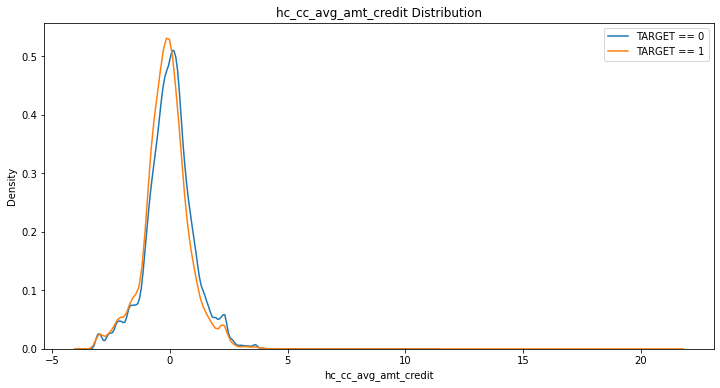

In [281]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_avg_amt_credit', app_train)

### hc_cc_cnt_amt_credit

In [282]:
app_train[['TARGET', 'hc_cc_cnt_amt_credit']].corr()

TARGET  hc_cc_cnt_amt_credit
TARGET                1.000000             -0.014268
hc_cc_cnt_amt_credit -0.014268              1.000000

The correlation between hc_cc_cnt_amt_credit and the TARGET is -0.0143
Median value for loan that was not repaid = 166.0000
Median value for loan that was repaid =     182.0000


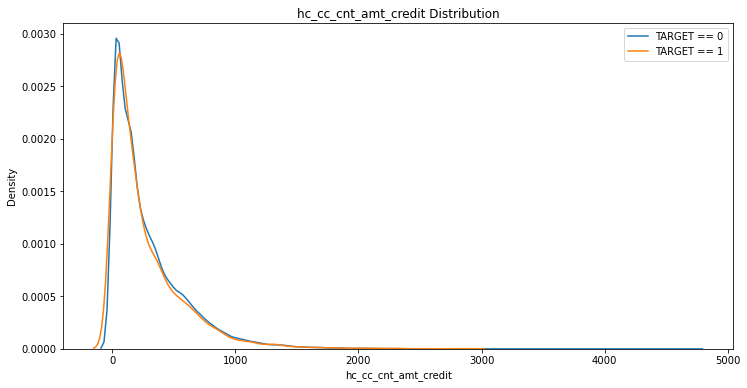

In [283]:
kde_target('hc_cc_cnt_amt_credit', app_train)

In [284]:
app_train['hc_cc_cnt_amt_credit'].isnull().sum()

196545

In [285]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_cnt_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_cnt_amt_credit  
0  52.715068            346.863769  
1  49.490411            258.150973  
2  54.898630            336.000000  
3  38.290411            251.822610  
4  35.726027            200.678982  

[5 rows x 92 columns]

In [286]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [287]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [288]:
app_train['hc_cc_cnt_amt_credit'].isnull().sum()

0

In [289]:
app_train[['TARGET', 'hc_cc_cnt_amt_credit']].corr()

TARGET  hc_cc_cnt_amt_credit
TARGET                1.000000             -0.018386
hc_cc_cnt_amt_credit -0.018386              1.000000

In [290]:
## Yao-Johnson変換
num_cols = ['hc_cc_cnt_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_cnt_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_cnt_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_cnt_amt_credit']].corr()

TARGET  hc_cc_cnt_amt_credit
TARGET                1.000000             -0.026526
hc_cc_cnt_amt_credit -0.026526              1.000000

In [291]:
## 標準化
num_cols = ['hc_cc_cnt_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_cnt_amt_credit', 'TARGET']].corr()

hc_cc_cnt_amt_credit    TARGET
hc_cc_cnt_amt_credit              1.000000 -0.026526
TARGET                           -0.026526  1.000000

The correlation between hc_cc_cnt_amt_credit and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0551
Median value for loan that was repaid =     0.0722


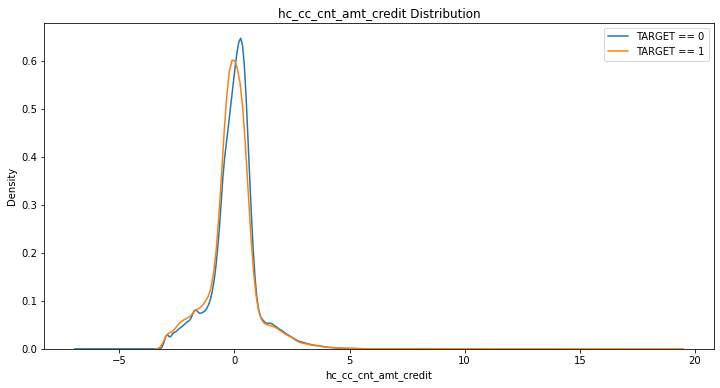

In [292]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_cnt_amt_credit', app_train)

### hc_cc_stddev_amt_credit

In [293]:
app_train[['TARGET', 'hc_cc_stddev_amt_credit']].corr()

TARGET  hc_cc_stddev_amt_credit
TARGET                   1.000000                -0.005749
hc_cc_stddev_amt_credit -0.005749                 1.000000

The correlation between hc_cc_stddev_amt_credit and the TARGET is -0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


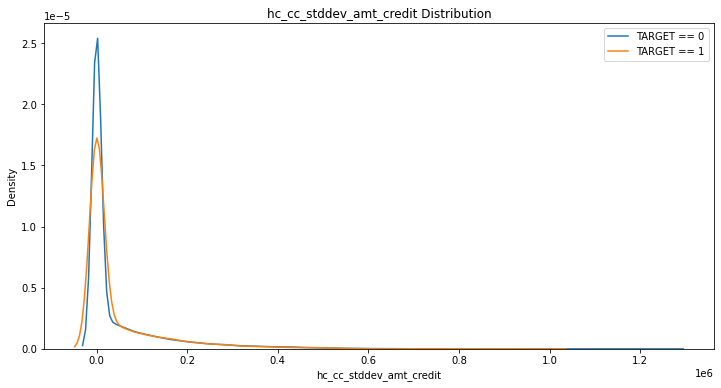

In [294]:
kde_target('hc_cc_stddev_amt_credit', app_train)

In [295]:
app_train['hc_cc_stddev_amt_credit'].isnull().sum()

196545

In [296]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_amt_credit  
0  52.715068             49730.219651  
1  49.490411             30426.067542  
2  54.898630                 0.000000  
3  38.290411             48906.540914  
4  35.726027             26330.179658  

[5 rows x 92 columns]

In [297]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [298]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [299]:
app_train['hc_cc_stddev_amt_credit'].isnull().sum()

0

In [300]:
app_train[['TARGET', 'hc_cc_stddev_amt_credit']].corr()

TARGET  hc_cc_stddev_amt_credit
TARGET                   1.00000                 -0.01925
hc_cc_stddev_amt_credit -0.01925                  1.00000

In [301]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_amt_credit']].corr()

TARGET  hc_cc_stddev_amt_credit
TARGET                   1.000000                -0.030813
hc_cc_stddev_amt_credit -0.030813                 1.000000

In [302]:
## 標準化
num_cols = ['hc_cc_stddev_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_amt_credit', 'TARGET']].corr()

hc_cc_stddev_amt_credit    TARGET
hc_cc_stddev_amt_credit                 1.000000 -0.030813
TARGET                                 -0.030813  1.000000

The correlation between hc_cc_stddev_amt_credit and the TARGET is -0.0308
Median value for loan that was not repaid = -0.1607
Median value for loan that was repaid =     0.0142


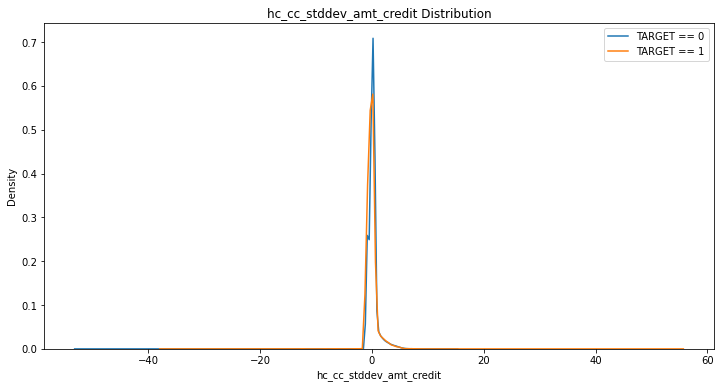

In [303]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_amt_credit', app_train)

### hc_cc_stddev_pop_amt_credit

In [304]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_credit']].corr()

TARGET  hc_cc_stddev_pop_amt_credit
TARGET                       1.000000                    -0.005749
hc_cc_stddev_pop_amt_credit -0.005749                     1.000000

The correlation between hc_cc_stddev_pop_amt_credit and the TARGET is -0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


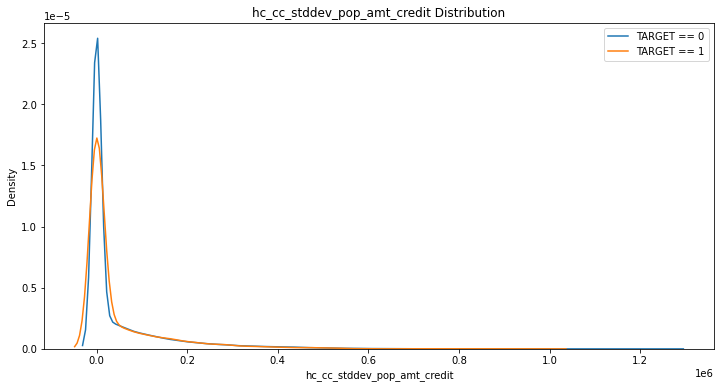

In [305]:
kde_target('hc_cc_stddev_pop_amt_credit', app_train)

In [306]:
app_train['hc_cc_stddev_pop_amt_credit'].isnull().sum()

196545

In [307]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_pop_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_pop_amt_credit  
0  52.715068                 49730.219651  
1  49.490411                 30426.067542  
2  54.898630                     0.000000  
3  38.290411                 48906.540914  
4  35.726027                 26330.179658  

[5 rows x 92 columns]

In [308]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [309]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [310]:
app_train['hc_cc_stddev_pop_amt_credit'].isnull().sum()

0

In [311]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_credit']].corr()

TARGET  hc_cc_stddev_pop_amt_credit
TARGET                       1.00000                     -0.01925
hc_cc_stddev_pop_amt_credit -0.01925                      1.00000

In [312]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_pop_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_pop_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_pop_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_pop_amt_credit']].corr()

TARGET  hc_cc_stddev_pop_amt_credit
TARGET                       1.000000                    -0.030813
hc_cc_stddev_pop_amt_credit -0.030813                     1.000000

In [313]:
## 標準化
num_cols = ['hc_cc_stddev_pop_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_pop_amt_credit', 'TARGET']].corr()

hc_cc_stddev_pop_amt_credit    TARGET
hc_cc_stddev_pop_amt_credit                     1.000000 -0.030813
TARGET                                         -0.030813  1.000000

The correlation between hc_cc_stddev_pop_amt_credit and the TARGET is -0.0308
Median value for loan that was not repaid = -0.1607
Median value for loan that was repaid =     0.0142


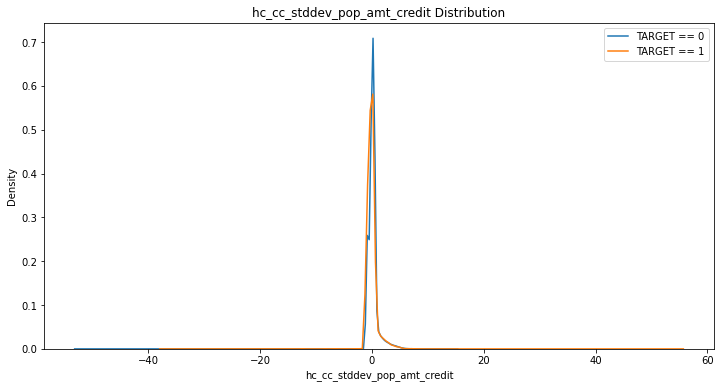

In [314]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_pop_amt_credit', app_train)

### hc_cc_var_pop_amt_credit

In [315]:
app_train[['TARGET', 'hc_cc_var_pop_amt_credit']].corr()

TARGET  hc_cc_var_pop_amt_credit
TARGET                    1.000000                 -0.005398
hc_cc_var_pop_amt_credit -0.005398                  1.000000

The correlation between hc_cc_var_pop_amt_credit and the TARGET is -0.0054
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


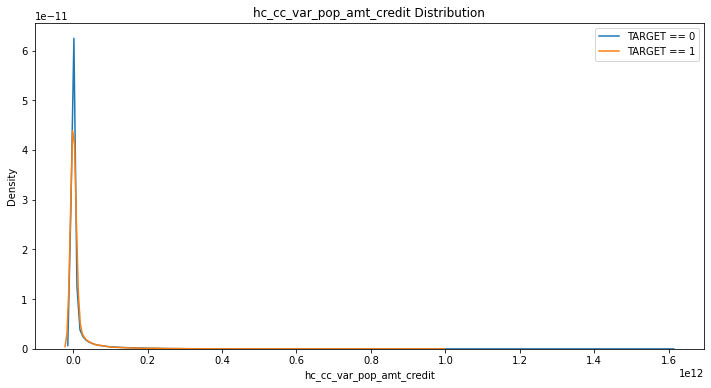

In [316]:
kde_target('hc_cc_var_pop_amt_credit', app_train)

In [317]:
app_train['hc_cc_var_pop_amt_credit'].isnull().sum()

196545

In [318]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_pop_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_pop_amt_credit  
0  52.715068              1.127060e+10  
1  49.490411              5.825375e+09  
2  54.898630              0.000000e+00  
3  38.290411              1.643545e+10  
4  35.726027              6.785722e+09  

[5 rows x 92 columns]

In [319]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [320]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [321]:
app_train['hc_cc_var_pop_amt_credit'].isnull().sum()

0

In [322]:
app_train[['TARGET', 'hc_cc_var_pop_amt_credit']].corr()

TARGET  hc_cc_var_pop_amt_credit
TARGET                    1.000000                 -0.015164
hc_cc_var_pop_amt_credit -0.015164                  1.000000

In [323]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_pop_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_pop_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_pop_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_pop_amt_credit']].corr()

TARGET  hc_cc_var_pop_amt_credit
TARGET                    1.000000                 -0.031488
hc_cc_var_pop_amt_credit -0.031488                  1.000000

In [324]:
## 標準化
num_cols = ['hc_cc_var_pop_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_pop_amt_credit', 'TARGET']].corr()

hc_cc_var_pop_amt_credit    TARGET
hc_cc_var_pop_amt_credit                  1.000000 -0.031488
TARGET                                   -0.031488  1.000000

The correlation between hc_cc_var_pop_amt_credit and the TARGET is -0.0315
Median value for loan that was not repaid = -0.1620
Median value for loan that was repaid =     -0.0611


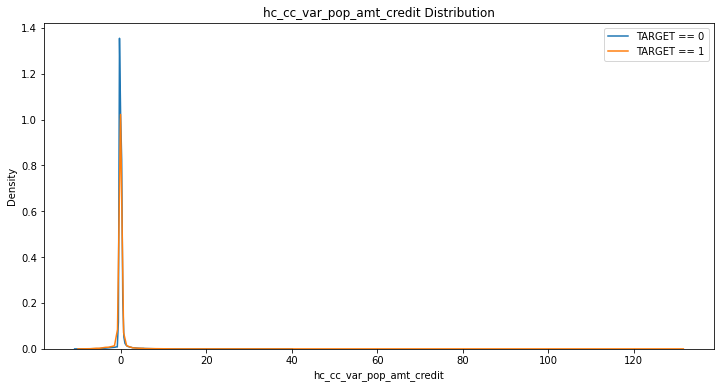

In [325]:

## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_pop_amt_credit', app_train)

### hc_cc_var_samp_amt_credit

In [326]:
app_train[['TARGET', 'hc_cc_var_samp_amt_credit']].corr()

TARGET  hc_cc_var_samp_amt_credit
TARGET                     1.00000                   -0.00523
hc_cc_var_samp_amt_credit -0.00523                    1.00000

The correlation between hc_cc_var_samp_amt_credit and the TARGET is -0.0052
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


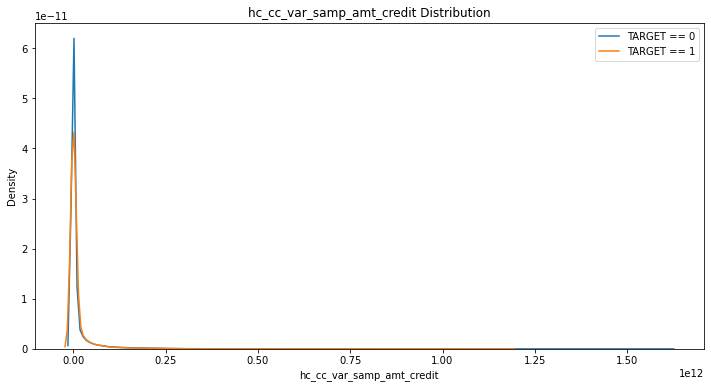

In [327]:
kde_target('hc_cc_var_samp_amt_credit', app_train)

In [328]:
app_train['hc_cc_var_samp_amt_credit'].isnull().sum()

196545

In [329]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_samp_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_samp_amt_credit  
0  52.715068               1.131199e+10  
1  49.490411               5.848765e+09  
2  54.898630               0.000000e+00  
3  38.290411               1.653700e+10  
4  35.726027               6.836043e+09  

[5 rows x 92 columns]

In [330]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [331]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [332]:
app_train['hc_cc_var_samp_amt_credit'].isnull().sum()

0

In [333]:
app_train[['TARGET', 'hc_cc_var_samp_amt_credit']].corr()

TARGET  hc_cc_var_samp_amt_credit
TARGET                     1.00000                   -0.01504
hc_cc_var_samp_amt_credit -0.01504                    1.00000

In [334]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_samp_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_samp_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_samp_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_samp_amt_credit']].corr()

TARGET  hc_cc_var_samp_amt_credit
TARGET                     1.000000                  -0.031292
hc_cc_var_samp_amt_credit -0.031292                   1.000000

In [335]:
## 標準化
num_cols = ['hc_cc_var_samp_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_samp_amt_credit', 'TARGET']].corr()

hc_cc_var_samp_amt_credit    TARGET
hc_cc_var_samp_amt_credit                   1.000000 -0.031292
TARGET                                     -0.031292  1.000000

The correlation between hc_cc_var_samp_amt_credit and the TARGET is -0.0313
Median value for loan that was not repaid = -0.1620
Median value for loan that was repaid =     -0.0613


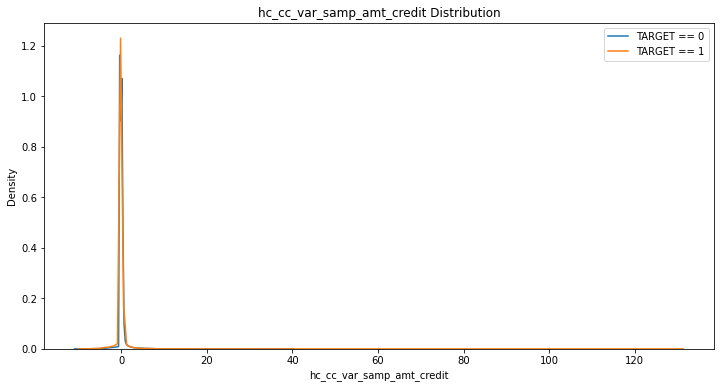

In [336]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_samp_amt_credit', app_train)

### hc_cc_variance_samp_amt_credit

In [337]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_credit']].corr()

TARGET  hc_cc_variance_samp_amt_credit
TARGET                          1.000000                       -0.005398
hc_cc_variance_samp_amt_credit -0.005398                        1.000000

The correlation between hc_cc_variance_samp_amt_credit and the TARGET is -0.0054
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


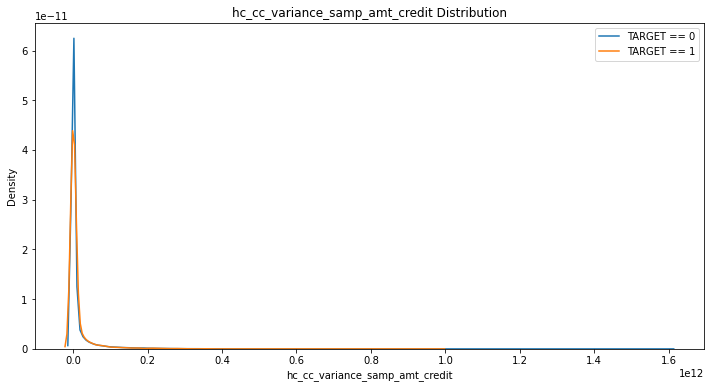

In [338]:
kde_target('hc_cc_variance_samp_amt_credit', app_train)

In [339]:
app_train['hc_cc_variance_samp_amt_credit'].isnull().sum()

196545

In [340]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_variance_samp_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_variance_samp_amt_credit  
0  52.715068                    1.127060e+10  
1  49.490411                    5.825375e+09  
2  54.898630                    0.000000e+00  
3  38.290411                    1.643545e+10  
4  35.726027                    6.785722e+09  

[5 rows x 92 columns]

In [341]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [342]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [343]:
app_train['hc_cc_variance_samp_amt_credit'].isnull().sum()

0

In [344]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_credit']].corr()

TARGET  hc_cc_variance_samp_amt_credit
TARGET                          1.000000                       -0.015164
hc_cc_variance_samp_amt_credit -0.015164                        1.000000

In [345]:
## Yao-Johnson変換
num_cols = ['hc_cc_variance_samp_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_variance_samp_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_cc_variance_samp_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_variance_samp_amt_credit']].corr()

TARGET  hc_cc_variance_samp_amt_credit
TARGET                          1.000000                       -0.031488
hc_cc_variance_samp_amt_credit -0.031488                        1.000000

In [346]:
## 標準化
num_cols = ['hc_cc_variance_samp_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_variance_samp_amt_credit', 'TARGET']].corr()

hc_cc_variance_samp_amt_credit    TARGET
hc_cc_variance_samp_amt_credit                        1.000000 -0.031488
TARGET                                               -0.031488  1.000000

The correlation between hc_cc_variance_samp_amt_credit and the TARGET is -0.0315
Median value for loan that was not repaid = -0.1620
Median value for loan that was repaid =     -0.0611


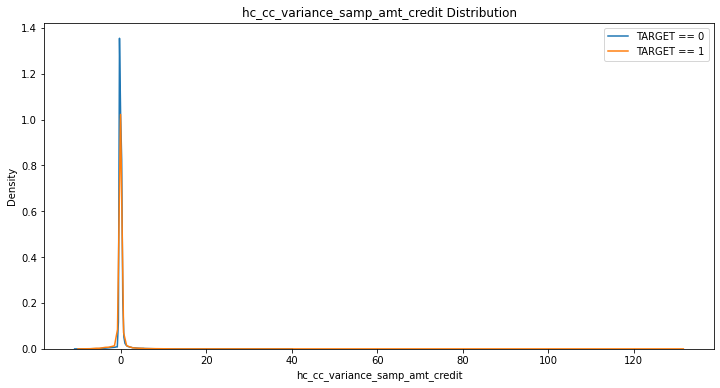

In [347]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_variance_samp_amt_credit', app_train)

### hc_cc_max_amt_down_payment

In [348]:
app_train[['TARGET', 'hc_cc_max_amt_down_payment']].corr()

TARGET  hc_cc_max_amt_down_payment
TARGET                         1.0                         NaN
hc_cc_max_amt_down_payment     NaN                         NaN

In [349]:
#kde_target('hc_cc_max_amt_down_payment', app_train)

In [350]:
#app_train['hc_cc_max_amt_down_payment'].isnull().sum()

In [351]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_cc_max_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [352]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [353]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [354]:
#app_train['hc_cc_max_amt_down_payment'].isnull().sum()

In [355]:
#app_train[['TARGET', 'hc_cc_max_amt_down_payment']].corr()

In [356]:
## Yao-Johnson変換
#num_cols = ['hc_cc_max_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_cc_max_amt_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_cc_max_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_cc_max_amt_down_payment']].corr()

In [357]:
## 標準化
#num_cols = ['hc_cc_max_amt_down_payment']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['hc_cc_max_amt_down_payment', 'TARGET']].corr()

In [358]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('hc_cc_max_amt_down_payment', app_train)

In [359]:
columns = ['hc_cc_max_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_min_amt_down_payment

In [360]:
app_train[['TARGET', 'hc_cc_min_amt_down_payment']].corr()

TARGET  hc_cc_min_amt_down_payment
TARGET                         1.0                         NaN
hc_cc_min_amt_down_payment     NaN                         NaN

In [361]:
columns = ['hc_cc_min_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_sum_amt_down_payment

In [362]:
app_train[['TARGET', 'hc_cc_sum_amt_down_payment']].corr()

TARGET  hc_cc_sum_amt_down_payment
TARGET                         1.0                         NaN
hc_cc_sum_amt_down_payment     NaN                         NaN

In [363]:
columns = ['hc_cc_sum_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_avg_amt_down_payment

In [364]:
columns = ['hc_cc_avg_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_cnt_amt_down_payment

In [365]:
columns = ['hc_cc_cnt_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_amt_down_payment

In [366]:
columns = ['hc_cc_stddev_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_pop_amt_down_payment

In [367]:
columns = ['hc_cc_stddev_pop_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_pop_amt_down_payment

In [368]:
columns = ['hc_cc_var_pop_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_samp_amt_down_payment

In [369]:
columns = ['hc_cc_var_samp_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_variance_samp_amt_down_payment

In [370]:
columns = ['hc_cc_variance_samp_amt_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_max_amt_goods_price

In [371]:
app_train[['TARGET', 'hc_cc_max_amt_goods_price']].corr()

TARGET  hc_cc_max_amt_goods_price
TARGET                     1.000000                  -0.033516
hc_cc_max_amt_goods_price -0.033516                   1.000000

The correlation between hc_cc_max_amt_goods_price and the TARGET is -0.0335
Median value for loan that was not repaid = 337500.0000
Median value for loan that was repaid =     391500.0000


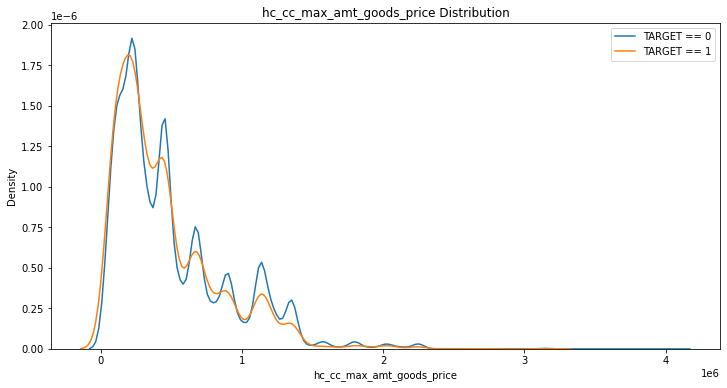

In [372]:
kde_target('hc_cc_max_amt_goods_price', app_train)

In [373]:
app_train['hc_cc_max_amt_goods_price'].isnull().sum()

196545

In [374]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_max_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_max_amt_goods_price  
0  52.715068              514876.337253  
1  49.490411              304890.416257  
2  54.898630              450000.000000  
3  38.290411              949309.091033  
4  35.726027              493764.392075  

[5 rows x 92 columns]

In [375]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [376]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [377]:
app_train['hc_cc_max_amt_goods_price'].isnull().sum()

0

In [378]:
app_train[['TARGET', 'hc_cc_max_amt_goods_price']].corr()

TARGET  hc_cc_max_amt_goods_price
TARGET                     1.000000                  -0.044996
hc_cc_max_amt_goods_price -0.044996                   1.000000

In [379]:
## Yao-Johnson変換
num_cols = ['hc_cc_max_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_max_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_max_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_max_amt_goods_price']].corr()

TARGET  hc_cc_max_amt_goods_price
TARGET                     1.000000                  -0.060179
hc_cc_max_amt_goods_price -0.060179                   1.000000

In [380]:
## 標準化
num_cols = ['hc_cc_max_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_max_amt_goods_price', 'TARGET']].corr()

hc_cc_max_amt_goods_price    TARGET
hc_cc_max_amt_goods_price                   1.000000 -0.060179
TARGET                                     -0.060179  1.000000

The correlation between hc_cc_max_amt_goods_price and the TARGET is -0.0602
Median value for loan that was not repaid = -0.3459
Median value for loan that was repaid =     -0.0825


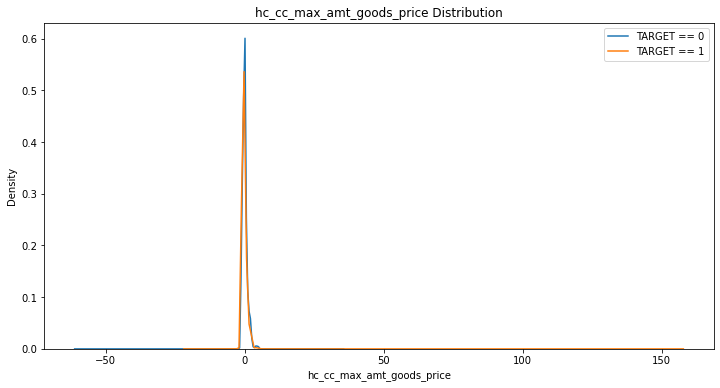

In [381]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_max_amt_goods_price', app_train)

### hc_cc_min_amt_goods_price

In [382]:
app_train[['TARGET', 'hc_cc_min_amt_goods_price']].corr()

TARGET  hc_cc_min_amt_goods_price
TARGET                     1.000000                  -0.033025
hc_cc_min_amt_goods_price -0.033025                   1.000000

The correlation between hc_cc_min_amt_goods_price and the TARGET is -0.0330
Median value for loan that was not repaid = 225000.0000
Median value for loan that was repaid =     238500.0000


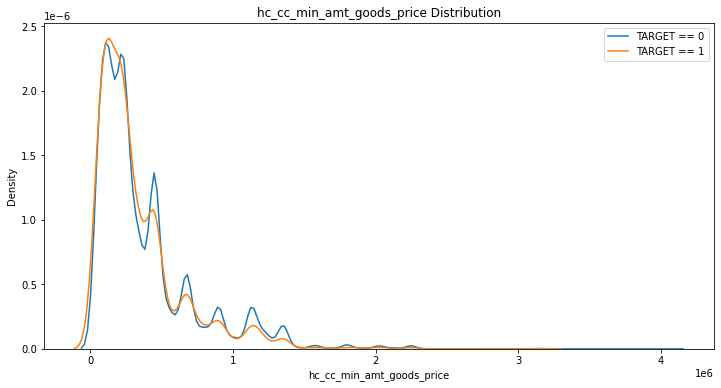

In [383]:
kde_target('hc_cc_min_amt_goods_price', app_train)

In [384]:
app_train['hc_cc_min_amt_goods_price'].isnull().sum()

196545

In [385]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_min_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_min_amt_goods_price  
0  52.715068              391551.340568  
1  49.490411              233689.541975  
2  54.898630              450000.000000  
3  38.290411              814279.408918  
4  35.726027              425085.628430  

[5 rows x 92 columns]

In [386]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [387]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [388]:
app_train['hc_cc_min_amt_goods_price'].isnull().sum()

0

In [389]:
app_train[['TARGET', 'hc_cc_min_amt_goods_price']].corr()

TARGET  hc_cc_min_amt_goods_price
TARGET                     1.00000                   -0.02818
hc_cc_min_amt_goods_price -0.02818                    1.00000

In [390]:
## Yao-Johnson変換
num_cols = ['hc_cc_min_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_min_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_min_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_min_amt_goods_price']].corr()

TARGET  hc_cc_min_amt_goods_price
TARGET                     1.00000                   -0.03898
hc_cc_min_amt_goods_price -0.03898                    1.00000

In [391]:
## 標準化
num_cols = ['hc_cc_min_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_min_amt_goods_price', 'TARGET']].corr()

hc_cc_min_amt_goods_price   TARGET
hc_cc_min_amt_goods_price                    1.00000 -0.03898
TARGET                                      -0.03898  1.00000

The correlation between hc_cc_min_amt_goods_price and the TARGET is -0.0390
Median value for loan that was not repaid = -0.1089
Median value for loan that was repaid =     0.0114


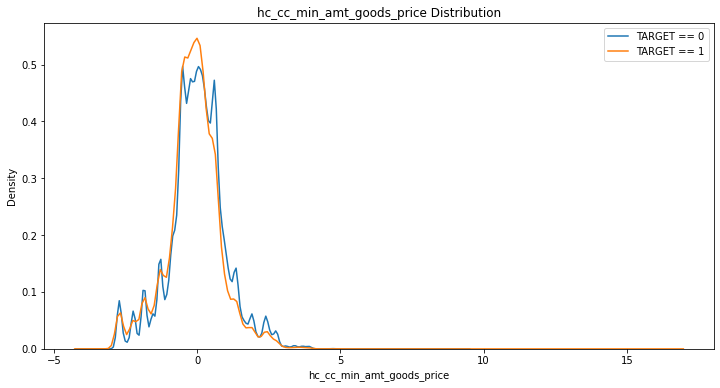

In [392]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_min_amt_goods_price', app_train)

### hc_cc_sum_amt_goods_price

In [393]:
app_train[['TARGET', 'hc_cc_sum_amt_goods_price']].corr()

TARGET  hc_cc_sum_amt_goods_price
TARGET                     1.000000                  -0.024985
hc_cc_sum_amt_goods_price -0.024985                   1.000000

The correlation between hc_cc_sum_amt_goods_price and the TARGET is -0.0250
Median value for loan that was not repaid = 46170000.0000
Median value for loan that was repaid =     58212000.0000


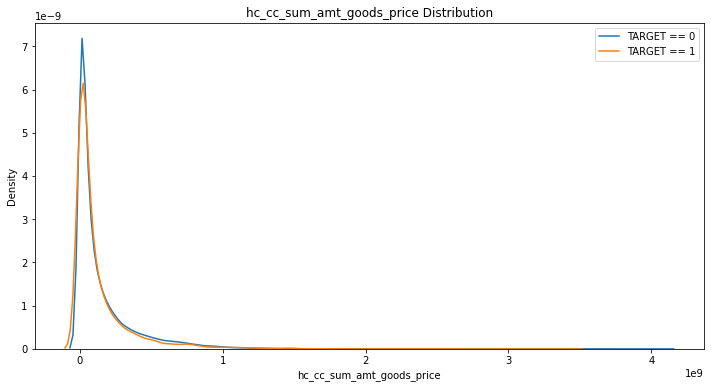

In [394]:
kde_target('hc_cc_sum_amt_goods_price', app_train)

In [395]:
app_train['hc_cc_sum_amt_goods_price'].isnull().sum()

196545

In [396]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_sum_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_sum_amt_goods_price  
0  52.715068               1.892445e+08  
1  49.490411               9.293536e+07  
2  54.898630               1.512000e+08  
3  38.290411               2.740110e+08  
4  35.726027               1.195324e+08  

[5 rows x 92 columns]

In [397]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [398]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [399]:
app_train['hc_cc_sum_amt_goods_price'].isnull().sum()

0

In [400]:
app_train[['TARGET', 'hc_cc_sum_amt_goods_price']].corr()

TARGET  hc_cc_sum_amt_goods_price
TARGET                     1.000000                  -0.030939
hc_cc_sum_amt_goods_price -0.030939                   1.000000

In [401]:
## Yao-Johnson変換
num_cols = ['hc_cc_sum_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_sum_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_sum_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_sum_amt_goods_price']].corr()

TARGET  hc_cc_sum_amt_goods_price
TARGET                     1.000000                  -0.039343
hc_cc_sum_amt_goods_price -0.039343                   1.000000

In [402]:
## 標準化
num_cols = ['hc_cc_sum_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_sum_amt_goods_price', 'TARGET']].corr()

hc_cc_sum_amt_goods_price    TARGET
hc_cc_sum_amt_goods_price                   1.000000 -0.039343
TARGET                                     -0.039343  1.000000

The correlation between hc_cc_sum_amt_goods_price and the TARGET is -0.0393
Median value for loan that was not repaid = -0.2709
Median value for loan that was repaid =     -0.1134


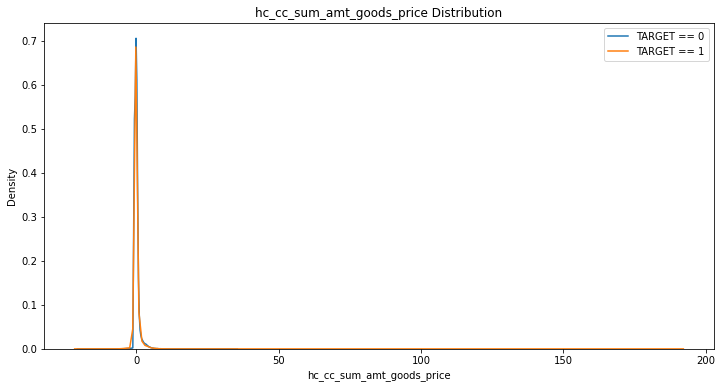

In [403]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_sum_amt_goods_price', app_train)

### hc_cc_avg_amt_goods_price

In [ ]:
app_train[['TARGET', 'hc_cc_avg_amt_goods_price']].corr()

In [ ]:
kde_target('hc_cc_avg_amt_goods_price', app_train)

In [ ]:
app_train['hc_cc_avg_amt_goods_price'].isnull().sum()

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_avg_amt_goods_price')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['hc_cc_avg_amt_goods_price'].isnull().sum()

In [ ]:
app_train[['TARGET', 'hc_cc_avg_amt_goods_price']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['hc_cc_avg_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_avg_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_avg_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_avg_amt_goods_price']].corr()

In [ ]:
## 標準化
num_cols = ['hc_cc_avg_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_avg_amt_goods_price', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_avg_amt_goods_price', app_train)

### hc_cc_cnt_amt_goods_price

In [405]:
app_train[['TARGET', 'hc_cc_cnt_amt_goods_price']].corr()

TARGET  hc_cc_cnt_amt_goods_price
TARGET                     1.000000                  -0.014268
hc_cc_cnt_amt_goods_price -0.014268                   1.000000

The correlation between hc_cc_cnt_amt_goods_price and the TARGET is -0.0143
Median value for loan that was not repaid = 166.0000
Median value for loan that was repaid =     182.0000


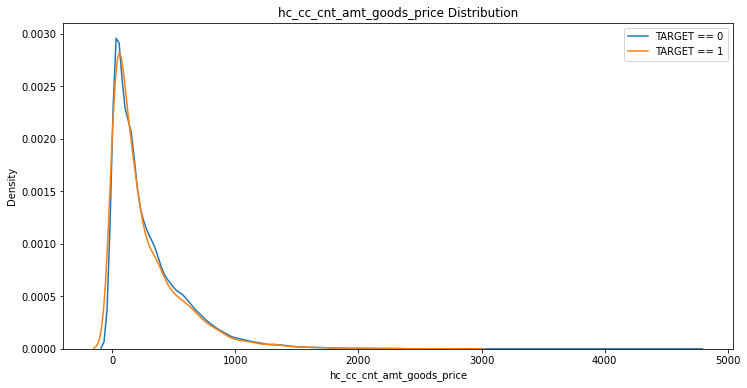

In [406]:
kde_target('hc_cc_cnt_amt_goods_price', app_train)

In [407]:
app_train['hc_cc_cnt_amt_goods_price'].isnull().sum()

196545

In [408]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_cnt_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_cnt_amt_goods_price  
0  52.715068                 346.863769  
1  49.490411                 258.150973  
2  54.898630                 336.000000  
3  38.290411                 251.822610  
4  35.726027                 200.678982  

[5 rows x 92 columns]

In [409]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [410]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [411]:
app_train['hc_cc_cnt_amt_goods_price'].isnull().sum()

0

In [412]:
app_train[['TARGET', 'hc_cc_cnt_amt_goods_price']].corr()

TARGET  hc_cc_cnt_amt_goods_price
TARGET                     1.000000                  -0.018386
hc_cc_cnt_amt_goods_price -0.018386                   1.000000

In [413]:
## Yao-Johnson変換
num_cols = ['hc_cc_cnt_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_cnt_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_cnt_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_cnt_amt_goods_price']].corr()

TARGET  hc_cc_cnt_amt_goods_price
TARGET                     1.000000                  -0.026526
hc_cc_cnt_amt_goods_price -0.026526                   1.000000

In [414]:
## 標準化
num_cols = ['hc_cc_cnt_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_cnt_amt_goods_price', 'TARGET']].corr()

hc_cc_cnt_amt_goods_price    TARGET
hc_cc_cnt_amt_goods_price                   1.000000 -0.026526
TARGET                                     -0.026526  1.000000

The correlation between hc_cc_cnt_amt_goods_price and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0551
Median value for loan that was repaid =     0.0722


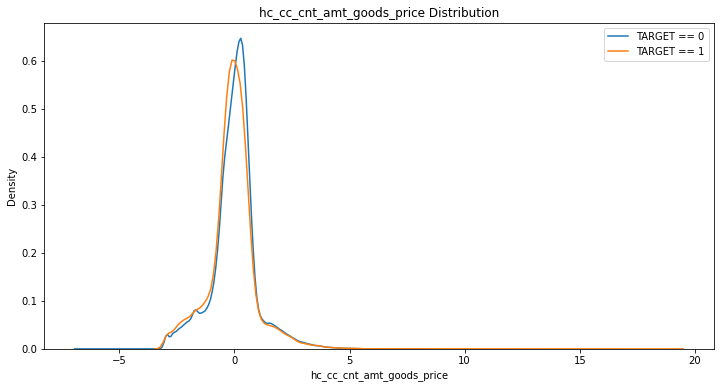

In [415]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_cnt_amt_goods_price', app_train)

### hc_cc_stddev_amt_goods_price

In [416]:
app_train[['TARGET', 'hc_cc_stddev_amt_goods_price']].corr()

TARGET  hc_cc_stddev_amt_goods_price
TARGET                        1.000000                     -0.007217
hc_cc_stddev_amt_goods_price -0.007217                      1.000000

The correlation between hc_cc_stddev_amt_goods_price and the TARGET is -0.0072
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


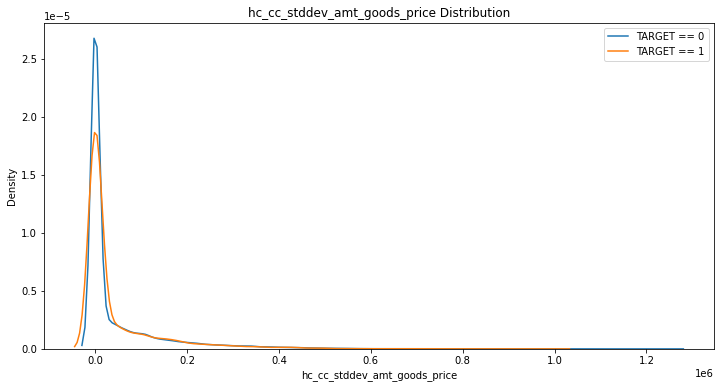

In [417]:
kde_target('hc_cc_stddev_amt_goods_price', app_train)

In [418]:
app_train['hc_cc_stddev_amt_goods_price'].isnull().sum()

196545

In [419]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_amt_goods_price  
0  52.715068                  45118.337870  
1  49.490411                  27283.090041  
2  54.898630                      0.000000  
3  38.290411                  47688.843707  
4  35.726027                  24863.214392  

[5 rows x 92 columns]

In [420]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [421]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [422]:
app_train['hc_cc_stddev_amt_goods_price'].isnull().sum()

0

In [423]:
app_train[['TARGET', 'hc_cc_stddev_amt_goods_price']].corr()

TARGET  hc_cc_stddev_amt_goods_price
TARGET                        1.000000                     -0.020393
hc_cc_stddev_amt_goods_price -0.020393                      1.000000

In [424]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_amt_goods_price']].corr()

TARGET  hc_cc_stddev_amt_goods_price
TARGET                        1.000000                     -0.033867
hc_cc_stddev_amt_goods_price -0.033867                      1.000000

In [425]:
## 標準化
num_cols = ['hc_cc_stddev_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_amt_goods_price', 'TARGET']].corr()

hc_cc_stddev_amt_goods_price    TARGET
hc_cc_stddev_amt_goods_price                      1.000000 -0.033867
TARGET                                           -0.033867  1.000000

The correlation between hc_cc_stddev_amt_goods_price and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1726
Median value for loan that was repaid =     0.0051


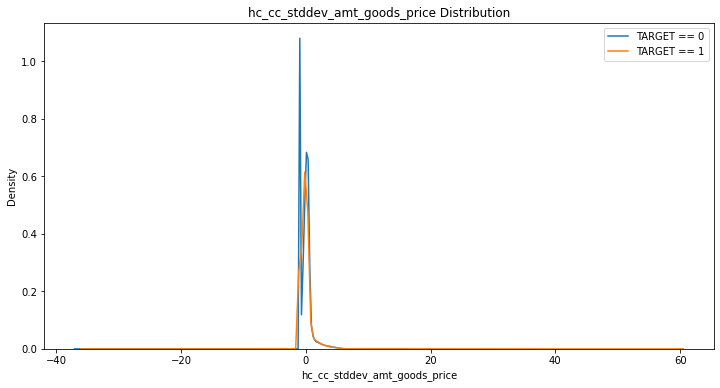

In [426]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_amt_goods_price', app_train)

### hc_cc_stddev_pop_amt_goods_price

In [427]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_goods_price']].corr()

TARGET  hc_cc_stddev_pop_amt_goods_price
TARGET                            1.000000                         -0.007217
hc_cc_stddev_pop_amt_goods_price -0.007217                          1.000000

The correlation between hc_cc_stddev_pop_amt_goods_price and the TARGET is -0.0072
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


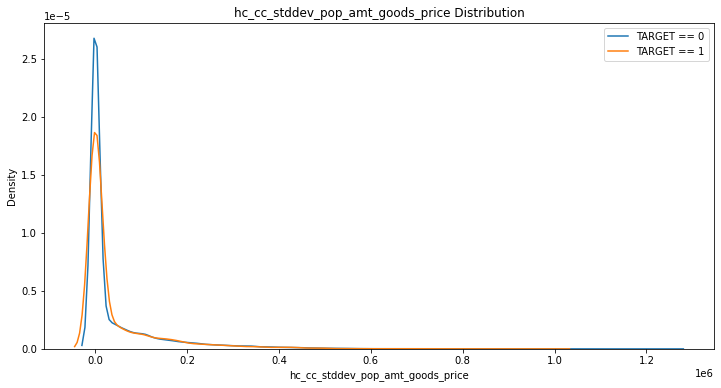

In [428]:
kde_target('hc_cc_stddev_pop_amt_goods_price', app_train)

In [429]:
app_train['hc_cc_stddev_pop_amt_goods_price'].isnull().sum()

196545

In [430]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_pop_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_pop_amt_goods_price  
0  52.715068                      45118.337870  
1  49.490411                      27283.090041  
2  54.898630                          0.000000  
3  38.290411                      47688.843707  
4  35.726027                      24863.214392  

[5 rows x 92 columns]

In [431]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [432]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [433]:
app_train['hc_cc_stddev_pop_amt_goods_price'].isnull().sum()

0

In [434]:
app_train[['TARGET', 'hc_cc_stddev_pop_amt_goods_price']].corr()

TARGET  hc_cc_stddev_pop_amt_goods_price
TARGET                            1.000000                         -0.020393
hc_cc_stddev_pop_amt_goods_price -0.020393                          1.000000

In [435]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_pop_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_pop_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_pop_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_pop_amt_goods_price']].corr()

TARGET  hc_cc_stddev_pop_amt_goods_price
TARGET                            1.000000                         -0.033867
hc_cc_stddev_pop_amt_goods_price -0.033867                          1.000000

In [436]:
## 標準化
num_cols = ['hc_cc_stddev_pop_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_pop_amt_goods_price', 'TARGET']].corr()

hc_cc_stddev_pop_amt_goods_price    TARGET
hc_cc_stddev_pop_amt_goods_price                          1.000000 -0.033867
TARGET                                                   -0.033867  1.000000

The correlation between hc_cc_stddev_pop_amt_goods_price and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1726
Median value for loan that was repaid =     0.0051


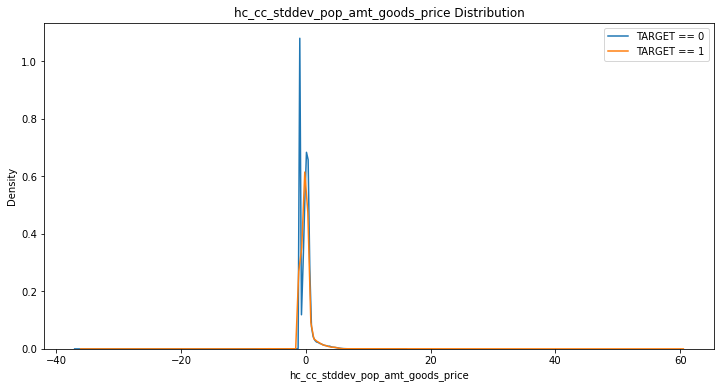

In [437]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_pop_amt_goods_price', app_train)

### hc_cc_var_pop_amt_goods_price

In [438]:
app_train[['TARGET', 'hc_cc_var_pop_amt_goods_price']].corr()

TARGET  hc_cc_var_pop_amt_goods_price
TARGET                         1.000000                      -0.006625
hc_cc_var_pop_amt_goods_price -0.006625                       1.000000

The correlation between hc_cc_var_pop_amt_goods_price and the TARGET is -0.0066
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


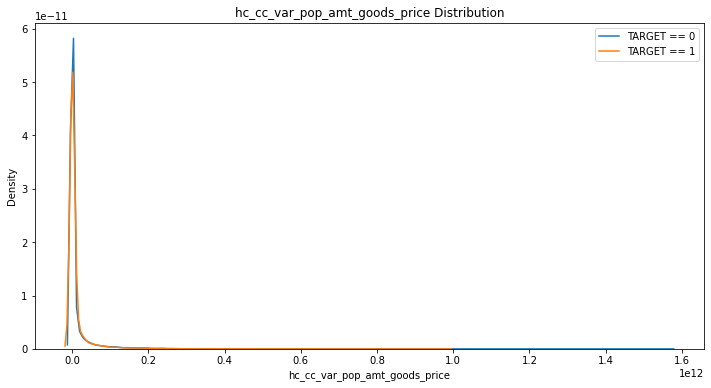

In [439]:
kde_target('hc_cc_var_pop_amt_goods_price', app_train)

In [440]:
app_train['hc_cc_var_pop_amt_goods_price'].isnull().sum()

196545

In [441]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_pop_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_pop_amt_goods_price  
0  52.715068                   9.425899e+09  
1  49.490411                   4.693259e+09  
2  54.898630                   0.000000e+00  
3  38.290411                   1.531277e+10  
4  35.726027                   6.140652e+09  

[5 rows x 92 columns]

In [442]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [443]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [444]:
app_train['hc_cc_var_pop_amt_goods_price'].isnull().sum()

0

In [445]:
app_train[['TARGET', 'hc_cc_var_pop_amt_goods_price']].corr()

TARGET  hc_cc_var_pop_amt_goods_price
TARGET                         1.000000                      -0.016189
hc_cc_var_pop_amt_goods_price -0.016189                       1.000000

In [446]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_pop_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_pop_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_pop_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_pop_amt_goods_price']].corr()

TARGET  hc_cc_var_pop_amt_goods_price
TARGET                         1.000000                      -0.033885
hc_cc_var_pop_amt_goods_price -0.033885                       1.000000

In [447]:
## 標準化
num_cols = ['hc_cc_var_pop_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_pop_amt_goods_price', 'TARGET']].corr()

hc_cc_var_pop_amt_goods_price    TARGET
hc_cc_var_pop_amt_goods_price                       1.000000 -0.033885
TARGET                                             -0.033885  1.000000

The correlation between hc_cc_var_pop_amt_goods_price and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0574


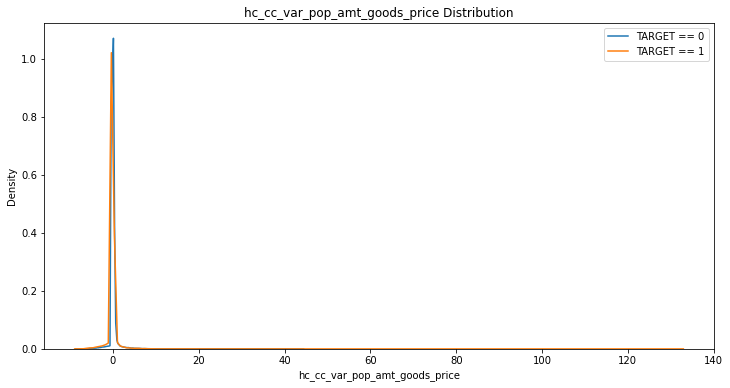

In [448]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_pop_amt_goods_price', app_train)

### hc_cc_var_samp_amt_goods_price

In [449]:
app_train[['TARGET', 'hc_cc_var_samp_amt_goods_price']].corr()

TARGET  hc_cc_var_samp_amt_goods_price
TARGET                          1.000000                       -0.006437
hc_cc_var_samp_amt_goods_price -0.006437                        1.000000

The correlation between hc_cc_var_samp_amt_goods_price and the TARGET is -0.0064
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


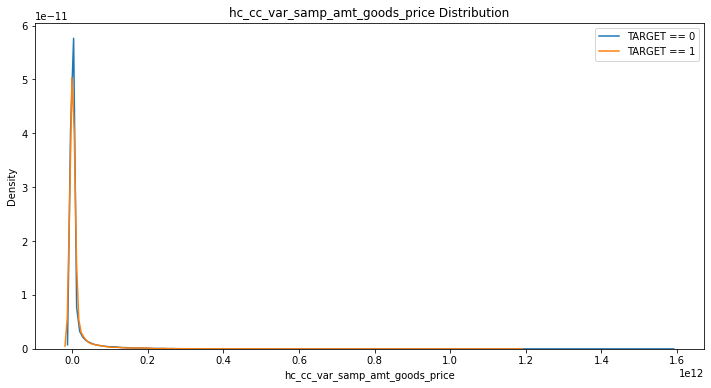

In [450]:
kde_target('hc_cc_var_samp_amt_goods_price', app_train)

In [451]:
app_train['hc_cc_var_samp_amt_goods_price'].isnull().sum()

196545

In [452]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_samp_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_samp_amt_goods_price  
0  52.715068                    9.460943e+09  
1  49.490411                    4.710960e+09  
2  54.898630                    0.000000e+00  
3  38.290411                    1.539610e+10  
4  35.726027                    6.180979e+09  

[5 rows x 92 columns]

In [453]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [454]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [455]:
app_train['hc_cc_var_samp_amt_goods_price'].isnull().sum()

0

In [456]:
app_train[['TARGET', 'hc_cc_var_samp_amt_goods_price']].corr()

TARGET  hc_cc_var_samp_amt_goods_price
TARGET                          1.000000                       -0.016055
hc_cc_var_samp_amt_goods_price -0.016055                        1.000000

In [457]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_samp_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_samp_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_samp_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_samp_amt_goods_price']].corr()

TARGET  hc_cc_var_samp_amt_goods_price
TARGET                          1.000000                       -0.033697
hc_cc_var_samp_amt_goods_price -0.033697                        1.000000

In [458]:
## 標準化
num_cols = ['hc_cc_var_samp_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_samp_amt_goods_price', 'TARGET']].corr()

hc_cc_var_samp_amt_goods_price    TARGET
hc_cc_var_samp_amt_goods_price                        1.000000 -0.033697
TARGET                                               -0.033697  1.000000

The correlation between hc_cc_var_samp_amt_goods_price and the TARGET is -0.0337
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0577


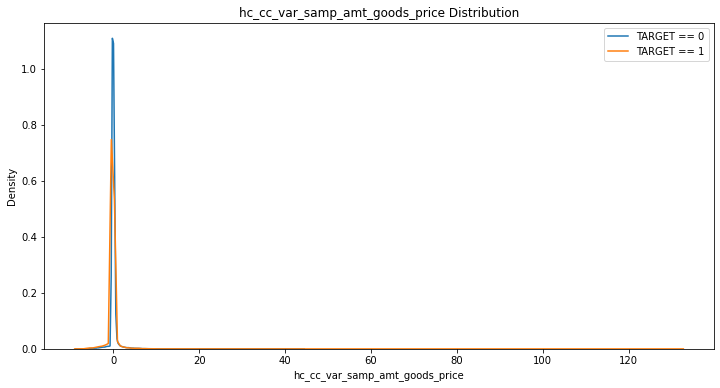

In [459]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_samp_amt_goods_price', app_train)

### hc_cc_variance_samp_amt_goods_price

In [460]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_goods_price']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_goods_price -0.006625   

                                     hc_cc_variance_samp_amt_goods_price  
TARGET                                                         -0.006625  
hc_cc_variance_samp_amt_goods_price                             1.000000

The correlation between hc_cc_variance_samp_amt_goods_price and the TARGET is -0.0066
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


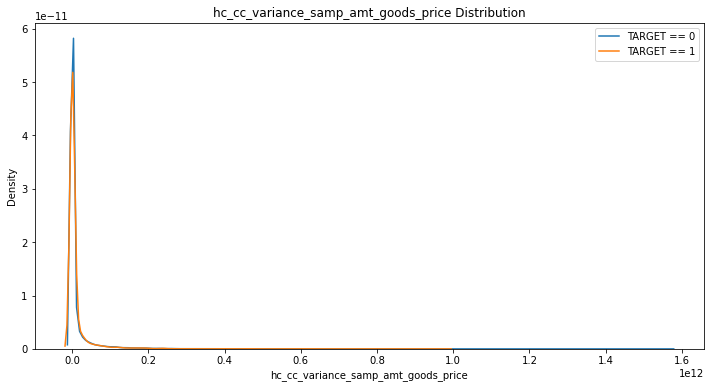

In [461]:
kde_target('hc_cc_variance_samp_amt_goods_price', app_train)

In [462]:
app_train['hc_cc_variance_samp_amt_goods_price'].isnull().sum()

196545

In [463]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_variance_samp_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_variance_samp_amt_goods_price  
0  52.715068                         9.425899e+09  
1  49.490411                         4.693259e+09  
2  54.898630                         0.000000e+00  
3  38.290411                         1.531277e+10  
4  35.726027                         6.140652e+09  

[5 rows x 92 columns]

In [464]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [465]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [466]:
app_train['hc_cc_variance_samp_amt_goods_price'].isnull().sum()

0

In [467]:
app_train[['TARGET', 'hc_cc_variance_samp_amt_goods_price']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_goods_price -0.016189   

                                     hc_cc_variance_samp_amt_goods_price  
TARGET                                                         -0.016189  
hc_cc_variance_samp_amt_goods_price                             1.000000

In [468]:
## Yao-Johnson変換
num_cols = ['hc_cc_variance_samp_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_variance_samp_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_cc_variance_samp_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_variance_samp_amt_goods_price']].corr()

TARGET  \
TARGET                               1.000000   
hc_cc_variance_samp_amt_goods_price -0.033885   

                                     hc_cc_variance_samp_amt_goods_price  
TARGET                                                         -0.033885  
hc_cc_variance_samp_amt_goods_price                             1.000000

In [469]:
## 標準化
num_cols = ['hc_cc_variance_samp_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_variance_samp_amt_goods_price', 'TARGET']].corr()

hc_cc_variance_samp_amt_goods_price  \
hc_cc_variance_samp_amt_goods_price                             1.000000   
TARGET                                                         -0.033885   

                                       TARGET  
hc_cc_variance_samp_amt_goods_price -0.033885  
TARGET                               1.000000

The correlation between hc_cc_variance_samp_amt_goods_price and the TARGET is -0.0339
Median value for loan that was not repaid = -0.1594
Median value for loan that was repaid =     -0.0574


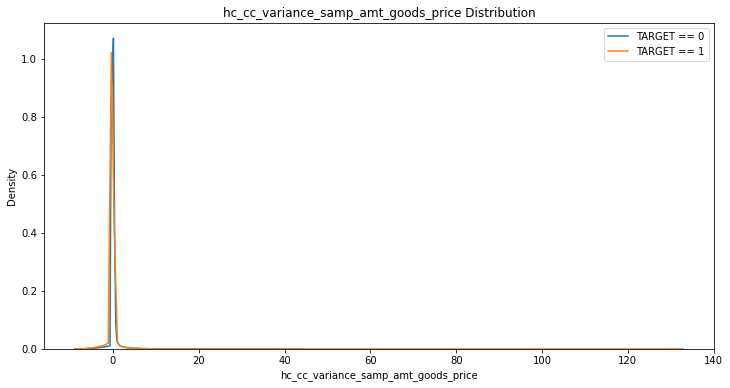

In [470]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_variance_samp_amt_goods_price', app_train)

### hc_cc_max_rate_down_payment

In [471]:
app_train['hc_cc_max_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_max_rate_down_payment, dtype: int64

In [472]:
app_train[['TARGET', 'hc_cc_max_rate_down_payment']].corr()

TARGET  hc_cc_max_rate_down_payment
TARGET                          1.0                          NaN
hc_cc_max_rate_down_payment     NaN                          NaN

In [473]:
#kde_target('hc_cc_max_rate_down_payment', app_train)

In [474]:
app_train['hc_cc_max_rate_down_payment'].isnull().sum()

196545

In [475]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_cc_max_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [476]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [477]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [478]:
#app_train['hc_cc_max_rate_down_payment'].isnull().sum()

In [479]:
#app_train[['TARGET', 'hc_cc_max_rate_down_payment']].corr()

In [480]:
## Yao-Johnson変換
#num_cols = ['hc_cc_max_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_cc_max_rate_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_cc_max_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_cc_max_rate_down_payment']].corr()

In [481]:
## 標準化
#num_cols = ['hc_cc_max_rate_down_payment']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['hc_cc_max_rate_down_payment', 'TARGET']].corr()

In [482]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('hc_cc_max_rate_down_payment', app_train)

In [483]:
columns = ['hc_cc_max_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_min_rate_down_payment

In [484]:
app_train['hc_cc_min_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_min_rate_down_payment, dtype: int64

In [485]:
columns = ['hc_cc_min_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_sum_rate_down_payment

In [486]:
app_train['hc_cc_sum_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_sum_rate_down_payment, dtype: int64

In [487]:
columns = ['hc_cc_sum_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [488]:
### hc_cc_avg_rate_down_payment

In [489]:
app_train['hc_cc_avg_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_avg_rate_down_payment, dtype: int64

In [490]:
columns = ['hc_cc_avg_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [491]:
### hc_cc_cnt_rate_down_payment

In [492]:
app_train['hc_cc_cnt_rate_down_payment'].value_counts()

0.0       110042
42.0          17
72.0          15
81.0          14
144.0         13
           ...  
670.0          1
8.0            1
232.0          1
1440.0         1
43.0           1
Name: hc_cc_cnt_rate_down_payment, Length: 372, dtype: int64

In [493]:
columns = ['hc_cc_cnt_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_rate_down_payment

In [494]:
app_train['hc_cc_stddev_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_stddev_rate_down_payment, dtype: int64

In [495]:
columns = ['hc_cc_stddev_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [496]:
### hc_cc_stddev_pop_rate_down_payment

In [497]:
app_train['hc_cc_stddev_pop_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_stddev_pop_rate_down_payment, dtype: int64

In [498]:
columns = ['hc_cc_stddev_pop_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_pop_rate_down_payment

In [499]:
app_train['hc_cc_var_pop_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_var_pop_rate_down_payment, dtype: int64

In [500]:
columns = ['hc_cc_var_pop_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_samp_rate_down_payment

In [501]:
app_train['hc_cc_var_samp_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_var_samp_rate_down_payment, dtype: int64

In [502]:
columns = ['hc_cc_var_samp_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_variance_samp_rate_down_payment

In [503]:
app_train['hc_cc_variance_samp_rate_down_payment'].value_counts()

0.0    110966
Name: hc_cc_variance_samp_rate_down_payment, dtype: int64

In [504]:
columns = ['hc_cc_variance_samp_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_max_rate_interest_primary

In [505]:
app_train['hc_cc_max_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_max_rate_interest_primary, dtype: int64

In [506]:
columns = ['hc_cc_max_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_min_rate_interest_primary

In [507]:
app_train['hc_cc_min_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_min_rate_interest_primary, dtype: int64

In [508]:
columns = ['hc_cc_min_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_sum_rate_interest_primary

In [509]:
app_train['hc_cc_sum_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_sum_rate_interest_primary, dtype: int64

In [510]:
columns = ['hc_cc_sum_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_avg_rate_interest_primary

In [511]:
app_train['hc_cc_avg_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_avg_rate_interest_primary, dtype: int64

In [512]:
columns = ['hc_cc_avg_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_cnt_rate_interest_primary

In [513]:
app_train['hc_cc_cnt_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_cnt_rate_interest_primary, dtype: int64

In [514]:
columns = ['hc_cc_cnt_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_rate_interest_primary

In [515]:
app_train['hc_cc_stddev_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_stddev_rate_interest_primary, dtype: int64

In [516]:
columns = ['hc_cc_stddev_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_pop_rate_interest_primary

In [517]:
app_train['hc_cc_stddev_pop_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_stddev_pop_rate_interest_primary, dtype: int64

In [518]:
columns = ['hc_cc_stddev_pop_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_pop_rate_interest_primary

In [519]:
app_train['hc_cc_var_pop_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_var_pop_rate_interest_primary, dtype: int64

In [520]:
columns = ['hc_cc_var_pop_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_samp_rate_interest_primary

In [521]:
app_train['hc_cc_var_samp_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_var_samp_rate_interest_primary, dtype: int64

In [522]:
columns = ['hc_cc_var_samp_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_variance_samp_rate_interest_primary

In [523]:
app_train['hc_cc_variance_samp_rate_interest_primary'].value_counts()

0.0    110966
Name: hc_cc_variance_samp_rate_interest_primary, dtype: int64

In [524]:
columns = ['hc_cc_variance_samp_rate_interest_primary']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_max_rate_interest_privileged

In [525]:
app_train['hc_cc_max_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_max_rate_interest_privileged, dtype: int64

In [526]:
columns = ['hc_cc_max_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_min_rate_interest_privileged

In [527]:
app_train['hc_cc_min_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_min_rate_interest_privileged, dtype: int64

In [528]:
columns = ['hc_cc_min_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_sum_rate_interest_privileged

In [529]:
app_train['hc_cc_sum_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_sum_rate_interest_privileged, dtype: int64

In [530]:
columns = ['hc_cc_sum_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_avg_rate_interest_privileged

In [531]:
app_train['hc_cc_avg_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_avg_rate_interest_privileged, dtype: int64

In [532]:
columns = ['hc_cc_avg_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_cnt_rate_interest_privileged

In [533]:
app_train['hc_cc_cnt_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_cnt_rate_interest_privileged, dtype: int64

In [534]:
columns = ['hc_cc_cnt_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_rate_interest_privileged

In [535]:
app_train['hc_cc_stddev_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_stddev_rate_interest_privileged, dtype: int64

In [536]:
columns = ['hc_cc_stddev_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_stddev_pop_rate_interest_privileged

In [537]:
app_train['hc_cc_stddev_pop_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_stddev_pop_rate_interest_privileged, dtype: int64

In [538]:
columns = ['hc_cc_stddev_pop_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_pop_rate_interest_privileged

In [539]:
app_train['hc_cc_var_pop_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_var_pop_rate_interest_privileged, dtype: int64

In [540]:
columns = ['hc_cc_var_pop_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_var_samp_rate_interest_privileged

In [541]:
app_train['hc_cc_var_samp_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_var_samp_rate_interest_privileged, dtype: int64

In [542]:
columns = ['hc_cc_var_samp_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_cc_variance_samp_rate_interest_privileged

In [543]:
app_train['hc_cc_variance_samp_rate_interest_privileged'].value_counts()

0.0    110966
Name: hc_cc_variance_samp_rate_interest_privileged, dtype: int64

In [544]:
columns = ['hc_cc_variance_samp_rate_interest_privileged']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [545]:
### hc_cc_max_sk_dpd

In [546]:
app_train[['TARGET', 'hc_cc_max_sk_dpd']].corr()

TARGET  hc_cc_max_sk_dpd
TARGET            1.000000          0.006655
hc_cc_max_sk_dpd  0.006655          1.000000

The correlation between hc_cc_max_sk_dpd and the TARGET is 0.0067
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


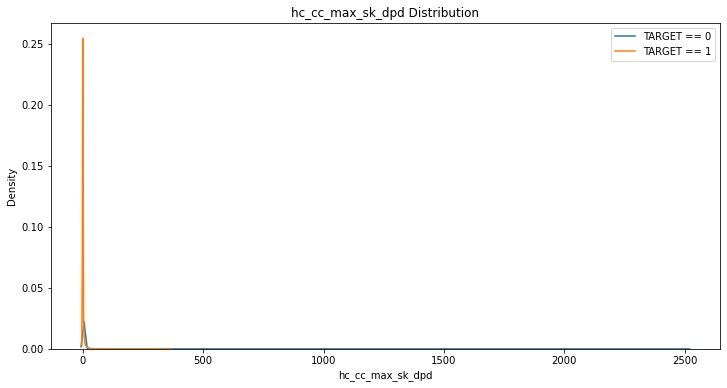

In [547]:
kde_target('hc_cc_max_sk_dpd', app_train)

In [548]:
app_train['hc_cc_max_sk_dpd'].isnull().sum()

196545

In [549]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_max_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_max_sk_dpd  
0  52.715068          0.545381  
1  49.490411          0.755017  
2  54.898630          0.000000  
3  38.290411         -0.014915  
4  35.726027          0.429619  

[5 rows x 92 columns]

In [550]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [551]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [552]:
app_train['hc_cc_max_sk_dpd'].isnull().sum()

0

In [553]:
app_train[['TARGET', 'hc_cc_max_sk_dpd']].corr()

TARGET  hc_cc_max_sk_dpd
TARGET            1.000000          0.003082
hc_cc_max_sk_dpd  0.003082          1.000000

In [554]:
## Yao-Johnson変換
num_cols = ['hc_cc_max_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_max_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_max_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_max_sk_dpd']].corr()

TARGET  hc_cc_max_sk_dpd
TARGET            1.00000           0.01009
hc_cc_max_sk_dpd  0.01009           1.00000

In [555]:
## 標準化
num_cols = ['hc_cc_max_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_max_sk_dpd', 'TARGET']].corr()

hc_cc_max_sk_dpd   TARGET
hc_cc_max_sk_dpd           1.00000  0.01009
TARGET                     0.01009  1.00000

The correlation between hc_cc_max_sk_dpd and the TARGET is 0.0101
Median value for loan that was not repaid = 0.0416
Median value for loan that was repaid =     0.0749


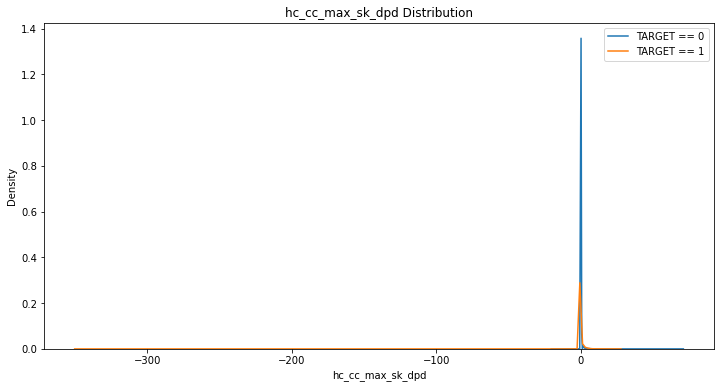

In [556]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_max_sk_dpd', app_train)

### hc_cc_min_sk_dpd

In [557]:
app_train[['TARGET', 'hc_cc_min_sk_dpd']].corr()

TARGET  hc_cc_min_sk_dpd
TARGET            1.000000         -0.002064
hc_cc_min_sk_dpd -0.002064          1.000000

The correlation between hc_cc_min_sk_dpd and the TARGET is -0.0021
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


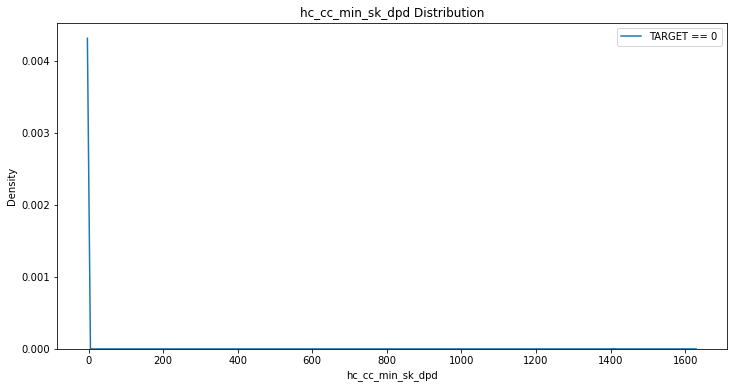

In [558]:
kde_target('hc_cc_min_sk_dpd', app_train)

In [559]:
app_train['hc_cc_min_sk_dpd'].isnull().sum()

196545

In [560]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_min_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_min_sk_dpd  
0  52.715068               0.0  
1  49.490411               0.0  
2  54.898630               0.0  
3  38.290411               0.0  
4  35.726027               0.0  

[5 rows x 92 columns]

In [561]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [562]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [563]:
app_train['hc_cc_min_sk_dpd'].isnull().sum()

0

In [564]:
app_train[['TARGET', 'hc_cc_min_sk_dpd']].corr()

TARGET  hc_cc_min_sk_dpd
TARGET            1.000000         -0.001562
hc_cc_min_sk_dpd -0.001562          1.000000

In [565]:
## Yao-Johnson変換
num_cols = ['hc_cc_min_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_min_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_min_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_min_sk_dpd']].corr()

TARGET  hc_cc_min_sk_dpd
TARGET            1.000000         -0.029089
hc_cc_min_sk_dpd -0.029089          1.000000

In [566]:
## 標準化
num_cols = ['hc_cc_min_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_min_sk_dpd', 'TARGET']].corr()

hc_cc_min_sk_dpd    TARGET
hc_cc_min_sk_dpd          1.000000 -0.029089
TARGET                   -0.029089  1.000000

The correlation between hc_cc_min_sk_dpd and the TARGET is -0.0291
Median value for loan that was not repaid = -0.5426
Median value for loan that was repaid =     -0.4527


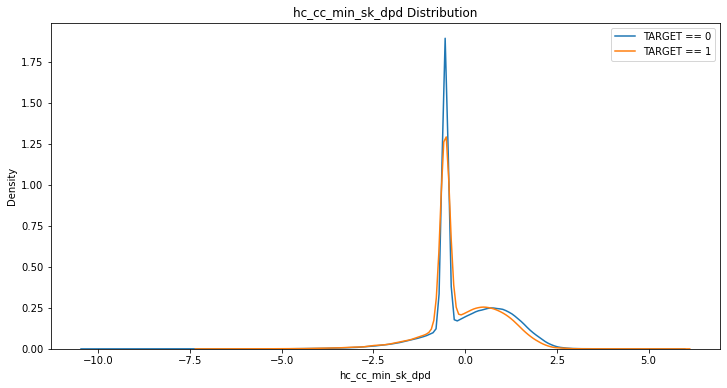

In [567]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_min_sk_dpd', app_train)

### hc_cc_sum_sk_dpd

In [568]:
app_train[['TARGET', 'hc_cc_sum_sk_dpd']].corr()

TARGET  hc_cc_sum_sk_dpd
TARGET            1.000000         -0.000859
hc_cc_sum_sk_dpd -0.000859          1.000000

The correlation between hc_cc_sum_sk_dpd and the TARGET is -0.0009
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


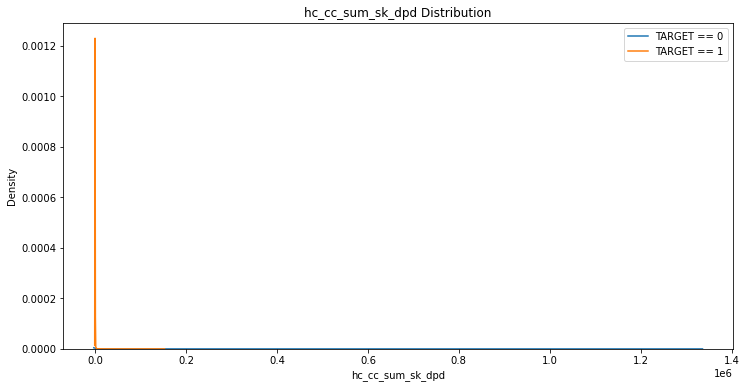

In [569]:
kde_target('hc_cc_sum_sk_dpd', app_train)

In [570]:
app_train['hc_cc_sum_sk_dpd'].isnull().sum()

196545

In [571]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_sum_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_sum_sk_dpd  
0  52.715068         23.222935  
1  49.490411         29.313670  
2  54.898630          0.000000  
3  38.290411         -3.432006  
4  35.726027         16.592172  

[5 rows x 92 columns]

In [572]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [573]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [574]:
app_train['hc_cc_sum_sk_dpd'].isnull().sum()

0

In [575]:
app_train[['TARGET', 'hc_cc_sum_sk_dpd']].corr()

TARGET  hc_cc_sum_sk_dpd
TARGET            1.00000          -0.00069
hc_cc_sum_sk_dpd -0.00069           1.00000

In [576]:
## Yao-Johnson変換
num_cols = ['hc_cc_sum_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_sum_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_sum_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_sum_sk_dpd']].corr()

TARGET  hc_cc_sum_sk_dpd
TARGET            1.000000         -0.002668
hc_cc_sum_sk_dpd -0.002668          1.000000

In [577]:
## 標準化
num_cols = ['hc_cc_sum_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_sum_sk_dpd', 'TARGET']].corr()

hc_cc_sum_sk_dpd    TARGET
hc_cc_sum_sk_dpd          1.000000 -0.002668
TARGET                   -0.002668  1.000000

The correlation between hc_cc_sum_sk_dpd and the TARGET is -0.0027
Median value for loan that was not repaid = 0.0229
Median value for loan that was repaid =     0.0244


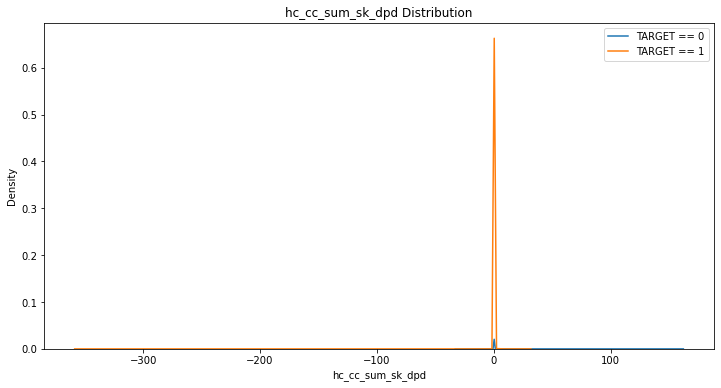

In [578]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_sum_sk_dpd', app_train)

### hc_cc_avg_sk_dpd

In [579]:
app_train[['TARGET', 'hc_cc_avg_sk_dpd']].corr()

TARGET  hc_cc_avg_sk_dpd
TARGET            1.00000          -0.00171
hc_cc_avg_sk_dpd -0.00171           1.00000

The correlation between hc_cc_avg_sk_dpd and the TARGET is -0.0017
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


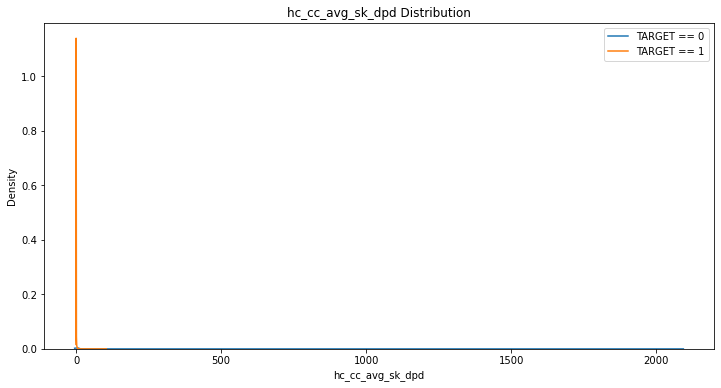

In [580]:
kde_target('hc_cc_avg_sk_dpd', app_train)

In [581]:
app_train['hc_cc_avg_sk_dpd'].isnull().sum()

196545

In [582]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_avg_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_avg_sk_dpd  
0  52.715068          0.048831  
1  49.490411          0.081581  
2  54.898630          0.000000  
3  38.290411         -0.003755  
4  35.726027          0.052214  

[5 rows x 92 columns]

In [583]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [584]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [585]:
app_train['hc_cc_avg_sk_dpd'].isnull().sum()

0

In [586]:
app_train[['TARGET', 'hc_cc_avg_sk_dpd']].corr()

TARGET  hc_cc_avg_sk_dpd
TARGET            1.000000         -0.001768
hc_cc_avg_sk_dpd -0.001768          1.000000

In [587]:
## Yao-Johnson変換
num_cols = ['hc_cc_avg_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_avg_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_avg_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_avg_sk_dpd']].corr()

TARGET  hc_cc_avg_sk_dpd
TARGET            1.000000         -0.021769
hc_cc_avg_sk_dpd -0.021769          1.000000

In [588]:
## 標準化
num_cols = ['hc_cc_avg_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_avg_sk_dpd', 'TARGET']].corr()

hc_cc_avg_sk_dpd    TARGET
hc_cc_avg_sk_dpd          1.000000 -0.021769
TARGET                   -0.021769  1.000000

The correlation between hc_cc_avg_sk_dpd and the TARGET is -0.0218
Median value for loan that was not repaid = -0.0469
Median value for loan that was repaid =     0.1175


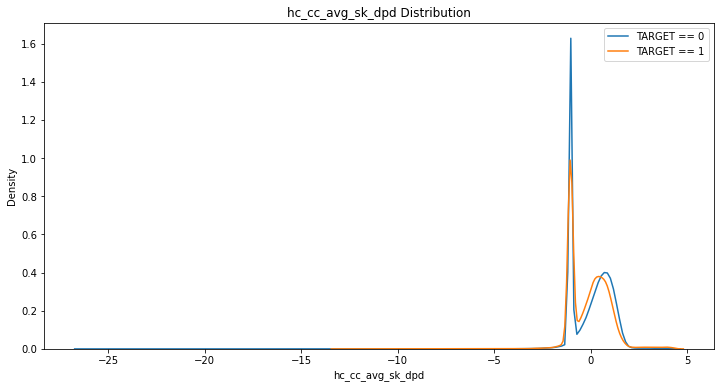

In [589]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_avg_sk_dpd', app_train)

### hc_cc_cnt_sk_dpd

In [590]:
app_train[['TARGET', 'hc_cc_cnt_sk_dpd']].corr()

TARGET  hc_cc_cnt_sk_dpd
TARGET            1.000000         -0.014268
hc_cc_cnt_sk_dpd -0.014268          1.000000

The correlation between hc_cc_cnt_sk_dpd and the TARGET is -0.0143
Median value for loan that was not repaid = 166.0000
Median value for loan that was repaid =     182.0000


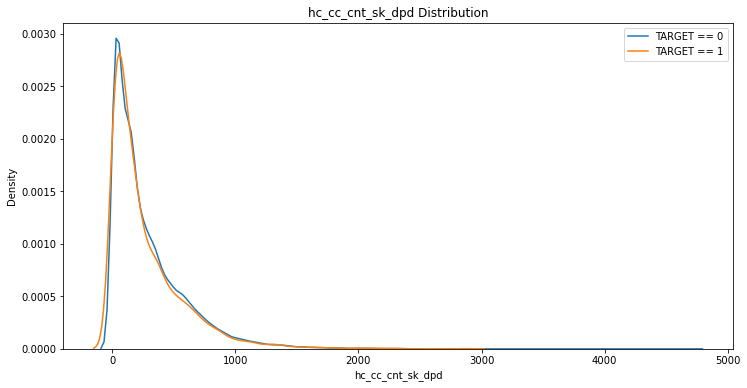

In [591]:
kde_target('hc_cc_cnt_sk_dpd', app_train)

In [592]:
app_train['hc_cc_cnt_sk_dpd'].isnull().sum()

196545

In [593]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_cnt_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_cnt_sk_dpd  
0  52.715068        346.863769  
1  49.490411        258.150973  
2  54.898630        336.000000  
3  38.290411        251.822610  
4  35.726027        200.678982  

[5 rows x 92 columns]

In [594]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [595]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [596]:
app_train['hc_cc_cnt_sk_dpd'].isnull().sum()

0

In [597]:
app_train[['TARGET', 'hc_cc_cnt_sk_dpd']].corr()

TARGET  hc_cc_cnt_sk_dpd
TARGET            1.000000         -0.018386
hc_cc_cnt_sk_dpd -0.018386          1.000000

In [598]:
## Yao-Johnson変換
num_cols = ['hc_cc_cnt_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_cnt_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_cnt_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_cnt_sk_dpd']].corr()

TARGET  hc_cc_cnt_sk_dpd
TARGET            1.000000         -0.026526
hc_cc_cnt_sk_dpd -0.026526          1.000000

In [599]:
## 標準化
num_cols = ['hc_cc_cnt_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_cnt_sk_dpd', 'TARGET']].corr()

hc_cc_cnt_sk_dpd    TARGET
hc_cc_cnt_sk_dpd          1.000000 -0.026526
TARGET                   -0.026526  1.000000

The correlation between hc_cc_cnt_sk_dpd and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0551
Median value for loan that was repaid =     0.0722


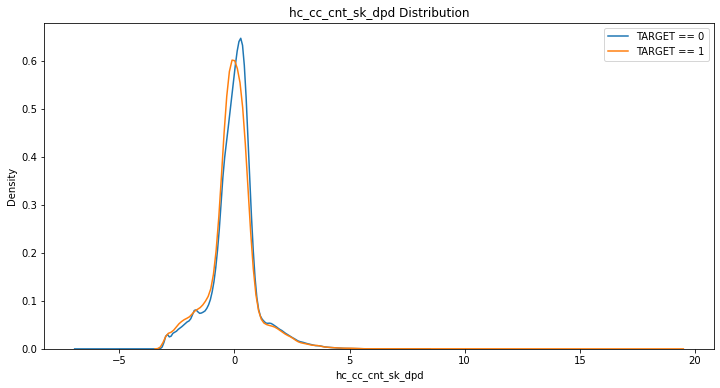

In [600]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_cnt_sk_dpd', app_train)

### hc_cc_stddev_sk_dpd

In [601]:
app_train[['TARGET', 'hc_cc_stddev_sk_dpd']].corr()

TARGET  hc_cc_stddev_sk_dpd
TARGET               1.000000             0.007505
hc_cc_stddev_sk_dpd  0.007505             1.000000

The correlation between hc_cc_stddev_sk_dpd and the TARGET is 0.0075
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


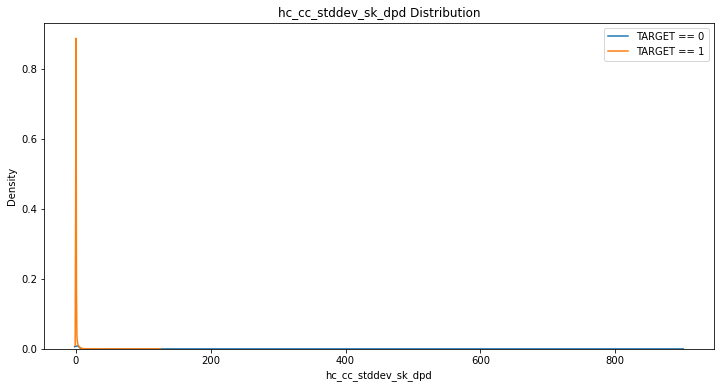

In [602]:
kde_target('hc_cc_stddev_sk_dpd', app_train)

In [603]:
app_train['hc_cc_stddev_sk_dpd'].isnull().sum()

196545

In [604]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_sk_dpd  
0  52.715068             0.141245  
1  49.490411             0.201576  
2  54.898630             0.000000  
3  38.290411            -0.003450  
4  35.726027             0.125669  

[5 rows x 92 columns]

In [605]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [606]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [607]:
app_train['hc_cc_stddev_sk_dpd'].isnull().sum()

0

In [608]:
app_train[['TARGET', 'hc_cc_stddev_sk_dpd']].corr()

TARGET  hc_cc_stddev_sk_dpd
TARGET               1.000000             0.003983
hc_cc_stddev_sk_dpd  0.003983             1.000000

In [609]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_sk_dpd']].corr()

TARGET  hc_cc_stddev_sk_dpd
TARGET               1.000000             0.016554
hc_cc_stddev_sk_dpd  0.016554             1.000000

In [610]:
## 標準化
num_cols = ['hc_cc_stddev_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_sk_dpd', 'TARGET']].corr()

hc_cc_stddev_sk_dpd    TARGET
hc_cc_stddev_sk_dpd             1.000000  0.016554
TARGET                          0.016554  1.000000

The correlation between hc_cc_stddev_sk_dpd and the TARGET is 0.0166
Median value for loan that was not repaid = 0.0388
Median value for loan that was repaid =     0.0493


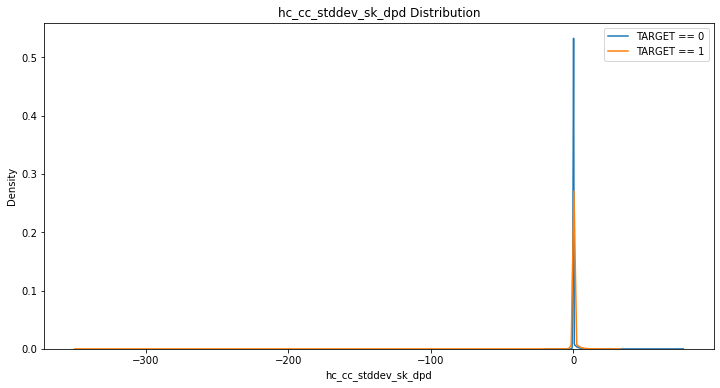

In [611]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_sk_dpd', app_train)

### hc_cc_stddev_pop_sk_dpd

In [612]:
app_train[['TARGET', 'hc_cc_stddev_pop_sk_dpd']].corr()

TARGET  hc_cc_stddev_pop_sk_dpd
TARGET                   1.000000                 0.007505
hc_cc_stddev_pop_sk_dpd  0.007505                 1.000000

The correlation between hc_cc_stddev_pop_sk_dpd and the TARGET is 0.0075
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


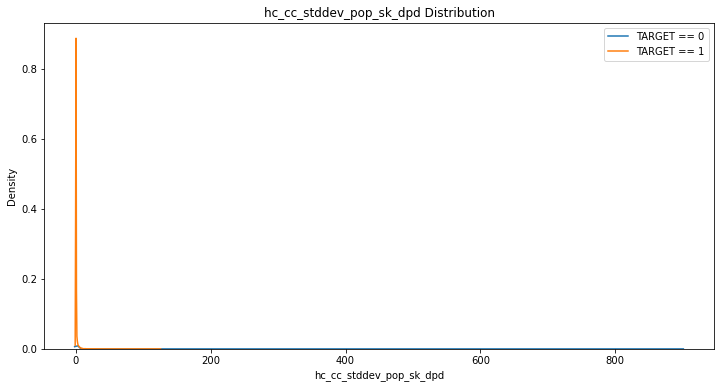

In [613]:
kde_target('hc_cc_stddev_pop_sk_dpd', app_train)

In [614]:
app_train['hc_cc_stddev_pop_sk_dpd'].isnull().sum()

196545

In [615]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_stddev_pop_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_stddev_pop_sk_dpd  
0  52.715068                 0.141245  
1  49.490411                 0.201576  
2  54.898630                 0.000000  
3  38.290411                -0.003450  
4  35.726027                 0.125669  

[5 rows x 92 columns]

In [616]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [617]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [618]:
app_train['hc_cc_stddev_pop_sk_dpd'].isnull().sum()

0

In [619]:
app_train[['TARGET', 'hc_cc_stddev_pop_sk_dpd']].corr()

TARGET  hc_cc_stddev_pop_sk_dpd
TARGET                   1.000000                 0.003983
hc_cc_stddev_pop_sk_dpd  0.003983                 1.000000

In [620]:
## Yao-Johnson変換
num_cols = ['hc_cc_stddev_pop_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_stddev_pop_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_stddev_pop_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_stddev_pop_sk_dpd']].corr()

TARGET  hc_cc_stddev_pop_sk_dpd
TARGET                   1.000000                 0.016554
hc_cc_stddev_pop_sk_dpd  0.016554                 1.000000

In [621]:
## 標準化
num_cols = ['hc_cc_stddev_pop_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_stddev_pop_sk_dpd', 'TARGET']].corr()

hc_cc_stddev_pop_sk_dpd    TARGET
hc_cc_stddev_pop_sk_dpd                 1.000000  0.016554
TARGET                                  0.016554  1.000000

The correlation between hc_cc_stddev_pop_sk_dpd and the TARGET is 0.0166
Median value for loan that was not repaid = 0.0388
Median value for loan that was repaid =     0.0493


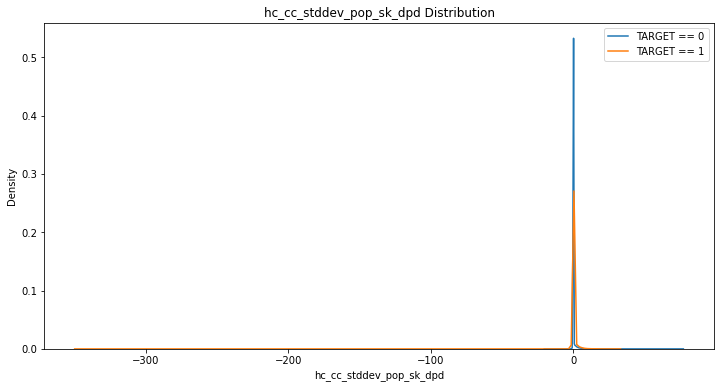

In [622]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_stddev_pop_sk_dpd', app_train)

### hc_cc_var_pop_sk_dpd

In [623]:
app_train[['TARGET', 'hc_cc_var_pop_sk_dpd']].corr()

TARGET  hc_cc_var_pop_sk_dpd
TARGET                1.000000             -0.002493
hc_cc_var_pop_sk_dpd -0.002493              1.000000

The correlation between hc_cc_var_pop_sk_dpd and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


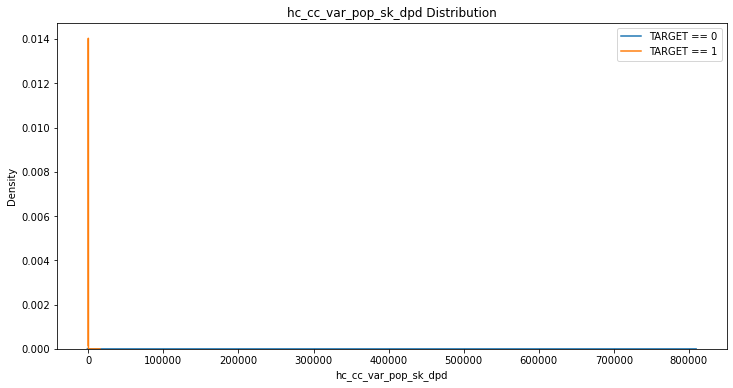

In [624]:
kde_target('hc_cc_var_pop_sk_dpd', app_train)

In [625]:
app_train['hc_cc_var_pop_sk_dpd'].isnull().sum()

196545

In [626]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_var_pop_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_var_pop_sk_dpd  
0  52.715068              0.560578  
1  49.490411              1.159853  
2  54.898630              0.000000  
3  38.290411              1.485686  
4  35.726027              1.074932  

[5 rows x 92 columns]

In [627]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [628]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [629]:
app_train['hc_cc_var_pop_sk_dpd'].isnull().sum()

0

In [630]:
app_train[['TARGET', 'hc_cc_var_pop_sk_dpd']].corr()

TARGET  hc_cc_var_pop_sk_dpd
TARGET                1.000000             -0.001607
hc_cc_var_pop_sk_dpd -0.001607              1.000000

In [631]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_pop_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_pop_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_pop_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_pop_sk_dpd']].corr()

TARGET  hc_cc_var_pop_sk_dpd
TARGET                1.000000             -0.005093
hc_cc_var_pop_sk_dpd -0.005093              1.000000

In [632]:
## 標準化
num_cols = ['hc_cc_var_pop_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_pop_sk_dpd', 'TARGET']].corr()

hc_cc_var_pop_sk_dpd    TARGET
hc_cc_var_pop_sk_dpd              1.000000 -0.005093
TARGET                           -0.005093  1.000000

The correlation between hc_cc_var_pop_sk_dpd and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0197
Median value for loan that was repaid =     0.0199


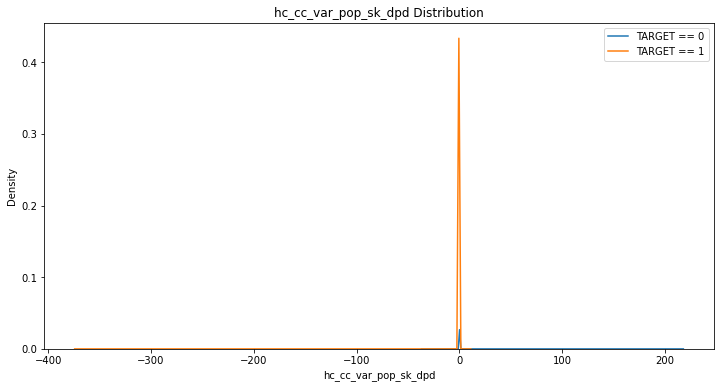

In [633]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_pop_sk_dpd', app_train)

### hc_cc_var_samp_sk_dpd

In [634]:
app_train[['TARGET', 'hc_cc_var_samp_sk_dpd']].corr()

TARGET  hc_cc_var_samp_sk_dpd
TARGET                 1.000000              -0.002495
hc_cc_var_samp_sk_dpd -0.002495               1.000000

The correlation between hc_cc_var_samp_sk_dpd and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


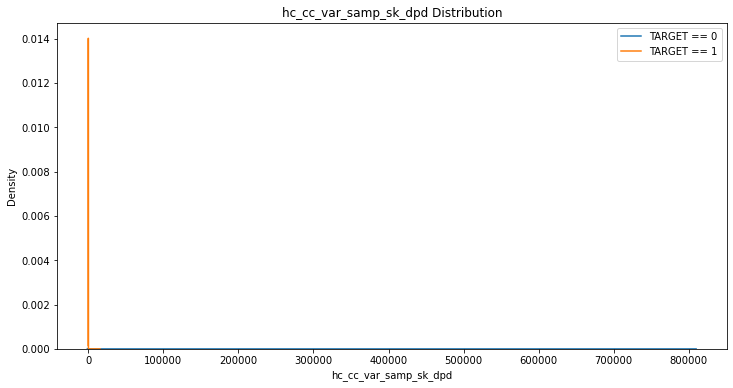

In [635]:
kde_target('hc_cc_var_samp_sk_dpd', app_train)

In [636]:
app_train['hc_cc_var_samp_sk_dpd'].isnull().sum()

196545

In [637]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_cc_var_samp_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [638]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [639]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [640]:
app_train['hc_cc_var_samp_sk_dpd'].isnull().sum()

196545

In [641]:
app_train[['TARGET', 'hc_cc_var_samp_sk_dpd']].corr()

TARGET  hc_cc_var_samp_sk_dpd
TARGET                 1.000000              -0.002495
hc_cc_var_samp_sk_dpd -0.002495               1.000000

In [642]:
## Yao-Johnson変換
num_cols = ['hc_cc_var_samp_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_var_samp_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_var_samp_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_var_samp_sk_dpd']].corr()

TARGET  hc_cc_var_samp_sk_dpd
TARGET                 1.000000               0.064333
hc_cc_var_samp_sk_dpd  0.064333               1.000000

In [643]:
## 標準化
num_cols = ['hc_cc_var_samp_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_var_samp_sk_dpd', 'TARGET']].corr()

hc_cc_var_samp_sk_dpd    TARGET
hc_cc_var_samp_sk_dpd               1.000000  0.064333
TARGET                              0.064333  1.000000

The correlation between hc_cc_var_samp_sk_dpd and the TARGET is 0.0643
Median value for loan that was not repaid = -0.2871
Median value for loan that was repaid =     -0.2871


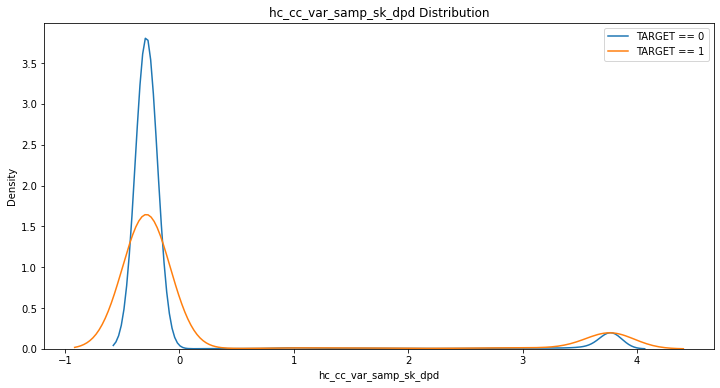

In [644]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_var_samp_sk_dpd', app_train)

In [645]:
columns = ['hc_cc_var_samp_sk_dpd']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [646]:
### hc_cc_variance_samp_sk_dpd

In [647]:
app_train[['TARGET', 'hc_cc_variance_samp_sk_dpd']].corr()

TARGET  hc_cc_variance_samp_sk_dpd
TARGET                      1.000000                   -0.002493
hc_cc_variance_samp_sk_dpd -0.002493                    1.000000

The correlation between hc_cc_variance_samp_sk_dpd and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


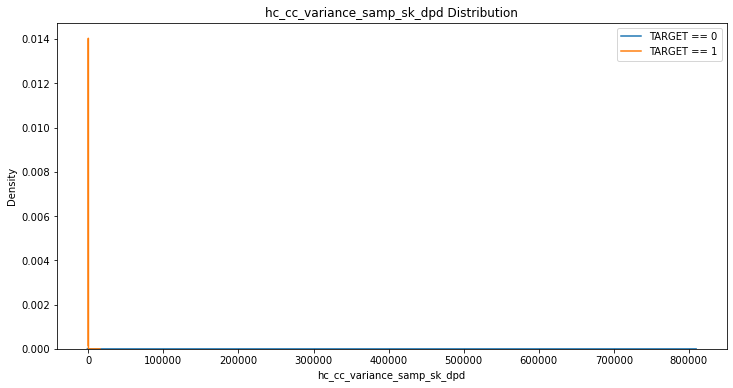

In [648]:
kde_target('hc_cc_variance_samp_sk_dpd', app_train)

In [649]:
app_train['hc_cc_variance_samp_sk_dpd'].isnull().sum()

196545

In [650]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_cc_variance_samp_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_cc_variance_samp_sk_dpd  
0  52.715068                    0.560578  
1  49.490411                    1.159853  
2  54.898630                    0.000000  
3  38.290411                    1.485686  
4  35.726027                    1.074932  

[5 rows x 92 columns]

In [651]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [652]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [653]:
app_train['hc_cc_variance_samp_sk_dpd'].isnull().sum()

0

In [654]:
app_train[['TARGET', 'hc_cc_variance_samp_sk_dpd']].corr()

TARGET  hc_cc_variance_samp_sk_dpd
TARGET                      1.000000                   -0.001607
hc_cc_variance_samp_sk_dpd -0.001607                    1.000000

In [655]:
## Yao-Johnson変換
num_cols = ['hc_cc_variance_samp_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_cc_variance_samp_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_cc_variance_samp_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_cc_variance_samp_sk_dpd']].corr()

TARGET  hc_cc_variance_samp_sk_dpd
TARGET                      1.000000                   -0.005093
hc_cc_variance_samp_sk_dpd -0.005093                    1.000000

In [656]:
## 標準化
num_cols = ['hc_cc_variance_samp_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_cc_variance_samp_sk_dpd', 'TARGET']].corr()

hc_cc_variance_samp_sk_dpd    TARGET
hc_cc_variance_samp_sk_dpd                    1.000000 -0.005093
TARGET                                       -0.005093  1.000000

The correlation between hc_cc_variance_samp_sk_dpd and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0197
Median value for loan that was repaid =     0.0199


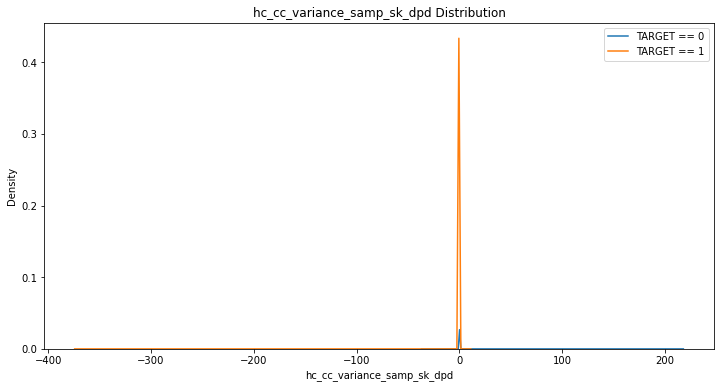

In [657]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_cc_variance_samp_sk_dpd', app_train)

## CSVをEXPORT

In [658]:
app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  hc_cc_variance_samp_amt_goods_price  \
0               0.0  ...                             0.072153   
1               0.0  ...                            -0.122170   
2               0.0  ...                            -0.339457   
3               0.0  ...                             0.302557   
4               0.0  ...                            -0.061496   

   hc_cc_max_sk_dpd  hc_cc_min_sk_dpd  hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  \
0         -0.092452         -0.542562         -0.071338         -0.658197   
1          0.040341         -0.542562         -0.063978         -0.425159   
2         -0.490258         -0.542562         -0.107335         -1.041926   
3         -0.502566         -0.542562         -0.118714         -1.073412   
4         -0.169832         -0.542562         -0.079878         -0.633275   

   hc_cc_cnt_sk_dpd  hc_cc_stddev_sk_dpd  hc_cc_stddev_pop_sk_dpd  \
0          0.660628            -0.107150                -0.107150   
1          0.195167             0.018062                 0.018062   
2          0.607837            -0.416993                -0.416993   
3          0.158474            -0.424884                -0.424884   
4         -0.160944            -0.140129                -0.140129   

   hc_cc_var_pop_sk_dpd  hc_cc_variance_samp_sk_dpd  
0             -0.062809                   -0.062809  
1             -0.060394                   -0.060394  
2             -0.065272                   -0.065272  
3             -0.059147                   -0.059147  
4             -0.060726                   -0.060726  

[5 rows x 141 columns]

In [659]:
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  hc_cc_variance_samp_amt_goods_price  hc_cc_max_sk_dpd  \
0  ...                            -0.103721          0.018572   
1  ...                            -0.339457         -0.490258   
2  ...                             0.012317          0.335717   
3  ...                            -0.339457         -0.490258   
4  ...                            -0.285055         -0.490258   

   hc_cc_min_sk_dpd  hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  hc_cc_cnt_sk_dpd  \
0          1.619737          0.058061          0.500514         -0.059825   
1         -0.542562         -0.107335         -1.041926         -1.612094   
2          1.333542          0.075292          1.206400          0.039305   
3         -0.542562         -0.107335         -1.041926         -2.863600   
4         -0.542562         -0.107335         -1.041926          0.883235   

   hc_cc_stddev_sk_dpd  hc_cc_stddev_pop_sk_dpd  hc_cc_var_pop_sk_dpd  \
0            -0.005434                -0.005434              0.018874   
1            -0.416993                -0.416993             -0.065272   
2             0.235850                 0.235850              0.049737   
3            -0.416993                -0.416993             -0.065272   
4            -0.416993                -0.416993             -0.065272   

   hc_cc_variance_samp_sk_dpd  
0                    0.018874  
1                   -0.065272  
2                    0.049737  
3                   -0.065272  
4                   -0.065272  

[5 rows x 142 columns]

In [660]:
remove_columns = list(app_test_origin.columns)
remove_columns.remove('SK_ID_CURR')
remove_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_M

In [661]:
app_train.drop(remove_columns, axis=1, inplace=True)
app_test.drop(remove_columns, axis=1, inplace=True)
app_br_train = app_train.copy()
app_br_test = app_test.copy()
app_br_test.head()

SK_ID_CURR  hc_cc_max_amt_annuity  hc_cc_min_amt_annuity  \
0      100001               0.026630              -0.012961   
1      100005              -0.519630              -0.477915   
2      100013              -0.336843               0.100084   
3      100028               1.206486               1.366091   
4      100038               0.295734               0.470440   

   hc_cc_sum_amt_annuity  hc_cc_avg_amt_annuity  hc_cc_cnt_amt_annuity  \
0               0.374583               0.005041               0.660628   
1              -0.203410              -0.531846               0.195167   
2               0.086577              -0.167394               0.607837   
3               0.721264               1.282281               0.158474   
4              -0.077255               0.360648              -0.160944   

   hc_cc_stddev_amt_annuity  hc_cc_stddev_pop_amt_annuity  \
0                  0.345668                      0.345668   
1                  0.179494                      0.179494   
2                 -0.420376                     -0.420376   
3                  0.283808                      0.283808   
4                  0.120888                      0.120888   

   hc_cc_var_pop_amt_annuity  hc_cc_var_samp_amt_annuity  ...  \
0                  -0.011930                   -0.013946  ...   
1                  -0.046359                   -0.048021  ...   
2                  -0.256528                   -0.257778  ...   
3                   0.135389                    0.134199  ...   
4                   0.007290                    0.006969  ...   

   hc_cc_variance_samp_amt_goods_price  hc_cc_max_sk_dpd  hc_cc_min_sk_dpd  \
0                             0.072153         -0.092452         -0.542562   
1                            -0.122170          0.040341         -0.542562   
2                            -0.339457         -0.490258         -0.542562   
3                             0.302557         -0.502566         -0.542562   
4                            -0.061496         -0.169832         -0.542562   

   hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  hc_cc_cnt_sk_dpd  hc_cc_stddev_sk_dpd  \
0         -0.071338         -0.658197          0.660628            -0.107150   
1         -0.063978         -0.425159          0.195167             0.018062   
2         -0.107335         -1.041926          0.607837            -0.416993   
3         -0.118714         -1.073412          0.158474            -0.424884   
4         -0.079878         -0.633275         -0.160944            -0.140129   

   hc_cc_stddev_pop_sk_dpd  hc_cc_var_pop_sk_dpd  hc_cc_variance_samp_sk_dpd  
0                -0.107150             -0.062809                   -0.062809  
1                 0.018062             -0.060394                   -0.060394  
2                -0.416993             -0.065272                   -0.065272  
3                -0.424884             -0.059147                   -0.059147  
4                -0.140129             -0.060726                   -0.060726  

[5 rows x 50 columns]

In [662]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only-cc_train_axis-24.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [663]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only-cc_test_axis-24.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [664]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [665]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [666]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[23:08:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.64518	eval-auc:0.63493
[1]	train-auc:0.65889	eval-auc:0.64486
[2]	train-auc:0.66573	eval-auc:0.64999
[3]	train-auc:0.67219	eval-auc:0.65212
[4]	train-auc:0.67802	eval-auc:0.65453
[5]	train-auc:0.67992	eval-auc:0.65632
[6]	train-auc:0.68173	eval-auc:0.65591
[7]	train-auc:0.68419	eval-auc:0.65679
[8]	train-auc:0.68728	eval-auc:0.65806
[9]	train-auc:0.68994	eval-auc:0.65925
[10]	train-auc:0.69160	eval-auc:0.65895
[11]	train-auc:0.69239	eval-auc:0.65929
[12]	train-auc:0.69413	eval-auc:0.66102
[13]	train-auc:0.69603	eval-auc:0.66185
[14

[12]	train-auc:0.69959	eval-auc:0.65342
[13]	train-auc:0.70197	eval-auc:0.65392
[14]	train-auc:0.70415	eval-auc:0.65471
[15]	train-auc:0.70566	eval-auc:0.65499
[16]	train-auc:0.70787	eval-auc:0.65588
[17]	train-auc:0.70933	eval-auc:0.65585
[18]	train-auc:0.71145	eval-auc:0.65664
[19]	train-auc:0.71249	eval-auc:0.65731
[20]	train-auc:0.71398	eval-auc:0.65724
[21]	train-auc:0.71575	eval-auc:0.65746
[22]	train-auc:0.71754	eval-auc:0.65800
[23]	train-auc:0.71822	eval-auc:0.65800
[24]	train-auc:0.71941	eval-auc:0.65823
[25]	train-auc:0.72114	eval-auc:0.65903
[26]	train-auc:0.72317	eval-auc:0.65935
[27]	train-auc:0.72481	eval-auc:0.65962
[28]	train-auc:0.72675	eval-auc:0.65994
[29]	train-auc:0.72869	eval-auc:0.66044
[30]	train-auc:0.73019	eval-auc:0.66036
[31]	train-auc:0.73206	eval-auc:0.66063
[32]	train-auc:0.73395	eval-auc:0.66053
[33]	train-auc:0.73578	eval-auc:0.66085
[34]	train-auc:0.73750	eval-auc:0.66118
[35]	train-auc:0.73934	eval-auc:0.66116
[36]	train-auc:0.74163	eval-auc:0.66165


In [667]:
remove_columns = ['TARGET']
app_br_train.drop(remove_columns, axis=1, inplace=True)
app_br_train.head()

SK_ID_CURR  hc_cc_max_amt_annuity  hc_cc_min_amt_annuity  \
0      100002               0.130436               0.278855   
1      100003               3.073367               3.501101   
2      100004              -0.884197              -0.960884   
3      100006              -0.236102               0.200009   
4      100007              -0.382012              -0.677668   

   hc_cc_sum_amt_annuity  hc_cc_avg_amt_annuity  hc_cc_cnt_amt_annuity  \
0              -0.222551               0.181728              -0.059825   
1              -0.351766               3.282963              -1.612094   
2              -0.306013              -0.949926               0.039305   
3              -1.194544              -0.064456              -2.863600   
4              -0.094323              -0.905506               0.883235   

   hc_cc_stddev_amt_annuity  hc_cc_stddev_pop_amt_annuity  \
0                 -0.236151                     -0.236151   
1                 -0.420376                     -0.420376   
2                 -1.052749                     -1.052749   
3                 -0.420376                     -0.420376   
4                  0.077989                      0.077989   

   hc_cc_var_pop_amt_annuity  hc_cc_var_samp_amt_annuity  ...  \
0                   0.000589                    0.001008  ...   
1                  -0.256528                   -0.257778  ...   
2                  -0.129146                   -0.130128  ...   
3                  -0.256528                   -0.257778  ...   
4                  -0.227102                   -0.228378  ...   

   hc_cc_variance_samp_amt_goods_price  hc_cc_max_sk_dpd  hc_cc_min_sk_dpd  \
0                            -0.103721          0.018572          1.619737   
1                            -0.339457         -0.490258         -0.542562   
2                             0.012317          0.335717          1.333542   
3                            -0.339457         -0.490258         -0.542562   
4                            -0.285055         -0.490258         -0.542562   

   hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  hc_cc_cnt_sk_dpd  hc_cc_stddev_sk_dpd  \
0          0.058061          0.500514         -0.059825            -0.005434   
1         -0.107335         -1.041926         -1.612094            -0.416993   
2          0.075292          1.206400          0.039305             0.235850   
3         -0.107335         -1.041926         -2.863600            -0.416993   
4         -0.107335         -1.041926          0.883235            -0.416993   

   hc_cc_stddev_pop_sk_dpd  hc_cc_var_pop_sk_dpd  hc_cc_variance_samp_sk_dpd  
0                -0.005434              0.018874                    0.018874  
1                -0.416993             -0.065272                   -0.065272  
2                 0.235850              0.049737                    0.049737  
3                -0.416993             -0.065272                   -0.065272  
4                -0.416993             -0.065272                   -0.065272  

[5 rows x 50 columns]

In [668]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  hc_cc_variance_samp_amt_goods_price  hc_cc_max_sk_dpd  \
0  ...                            -0.103721          0.018572   
1  ...                            -0.339457         -0.490258   
2  ...                             0.012317          0.335717   
3  ...                            -0.339457         -0.490258   
4  ...                            -0.285055         -0.490258   

   hc_cc_min_sk_dpd  hc_cc_sum_sk_dpd  hc_cc_avg_sk_dpd  hc_cc_cnt_sk_dpd  \
0          1.619737          0.058061          0.500514         -0.059825   
1         -0.542562         -0.107335         -1.041926         -1.612094   
2          1.333542          0.075292          1.206400          0.039305   
3         -0.542562         -0.107335         -1.041926         -2.863600   
4         -0.542562         -0.107335         -1.041926          0.883235   

   hc_cc_stddev_sk_dpd  hc_cc_stddev_pop_sk_dpd  hc_cc_var_pop_sk_dpd  \
0            -0.005434                -0.005434              0.018874   
1            -0.416993                -0.416993             -0.065272   
2             0.235850                 0.235850              0.049737   
3            -0.416993                -0.416993             -0.065272   
4            -0.416993                -0.416993             -0.065272   

   hc_cc_variance_samp_sk_dpd  
0                    0.018874  
1                   -0.065272  
2                    0.049737  
3                   -0.065272  
4                   -0.065272  

[5 rows x 142 columns]

In [669]:
columns = list(app_train.columns)
columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVIN

In [670]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [671]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [672]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[23:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72721	eval-auc:0.70602
[1]	train-auc:0.74756	eval-auc:0.72387
[2]	train-auc:0.75569	eval-auc:0.73090
[3]	train-auc:0.76027	eval-auc:0.73315
[4]	train-auc:0.76354	eval-auc:0.73511
[5]	train-auc:0.76584	eval-auc:0.73633
[6]	train-auc:0.76859	eval-auc:0.73813
[7]	train-auc:0.77232	eval-auc:0.73949
[8]	train-auc:0.77435	eval-auc:0.74073
[9]	train-auc:0.77648	eval-auc:0.74130
[10]	train-auc:0.77816	eval-auc:0.74113
[11]	train-auc:0.77935	eval-auc:0.74117
[12]	train-auc:0.78055	eval-auc:0.74177
[13]	train-auc:0.78216	eval-auc:0.74233
[14

[12]	train-auc:0.78163	eval-auc:0.74006
[13]	train-auc:0.78367	eval-auc:0.74045
[14]	train-auc:0.78517	eval-auc:0.74089
[15]	train-auc:0.78677	eval-auc:0.74121
[16]	train-auc:0.78850	eval-auc:0.74197
[17]	train-auc:0.79005	eval-auc:0.74254
[18]	train-auc:0.79201	eval-auc:0.74306
[19]	train-auc:0.79322	eval-auc:0.74377
[20]	train-auc:0.79492	eval-auc:0.74475
[21]	train-auc:0.79642	eval-auc:0.74561
[22]	train-auc:0.79753	eval-auc:0.74583
[23]	train-auc:0.79885	eval-auc:0.74588
[24]	train-auc:0.80016	eval-auc:0.74624
[25]	train-auc:0.80229	eval-auc:0.74667
[26]	train-auc:0.80444	eval-auc:0.74773
[27]	train-auc:0.80565	eval-auc:0.74798
[28]	train-auc:0.80692	eval-auc:0.74836
[29]	train-auc:0.80830	eval-auc:0.74865
[30]	train-auc:0.80949	eval-auc:0.74920
[31]	train-auc:0.81108	eval-auc:0.74958
[32]	train-auc:0.81259	eval-auc:0.74980
[33]	train-auc:0.81420	eval-auc:0.75008
[34]	train-auc:0.81577	eval-auc:0.74995
[35]	train-auc:0.81710	eval-auc:0.75034
[36]	train-auc:0.81844	eval-auc:0.75047


In [673]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [674]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [675]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [676]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [677]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [678]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [679]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.070172       0.065396       0.078161       0.039918       0.062944
1       0.139517       0.148628       0.101930       0.134383       0.105324
2       0.019788       0.024051       0.021431       0.024229       0.020430
3       0.041833       0.036732       0.035755       0.048219       0.051596
4       0.145488       0.127378       0.130838       0.092610       0.148109

In [680]:
submit_all = app_test[["SK_ID_CURR"]].astype(int).copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.063318
1      100005  0.125957
2      100013  0.021986
3      100028  0.042827
4      100038  0.128885

In [681]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_hc_only-cc_test_axis-24.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.012664
1      100005  0.025191
2      100013  0.004397
3      100028  0.008565
4      100038  0.025777

In [682]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64